# Notebook to compute the LSST's passbands and the impact of the atmospheric parameters on the colors of reference sources 

In this notebook we are going to take the reference spectra from the pysynphot's spectral atlases and make them pass through the LSST's throughput and the simulated atmospheres from the previous notebooks. 

This notebook requires [pysynphot](https://pysynphot.readthedocs.io/en/latest/) 


# Load necessary packages 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pysynphot as S
from scipy.interpolate import interp1d
from scipy import integrate
from astropy.io import fits
from scipy.optimize import curve_fit
#import quadpy

# allow interactive plots
#%matplotlib widget

In [2]:
S.refs.showref()

graphtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/57g1733im_tmg.fits
 comptable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/5as18041m_tmc.fits
thermtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/3241637sm_tmt.fits
      area: 45238.93416
   waveset: Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True


# Define LaTeX commands 

$\newcommand{\AA}{\mathit{\unicode{x212B}}}$
Angstrom symbol: $\AA$

# Set LSST's parameters 

In [3]:
WLMIN=3400. # Minimum wavelength : PySynPhot works with Angstrom
WLMAX=10600. # Minimum wavelength : PySynPhot works with Angstrom

NBINS=int(WLMAX-WLMIN) # Number of bins between WLMIN and WLMAX
BinWidth=(WLMAX-WLMIN)/float(NBINS) # Bin width in Angstrom
WL=np.linspace(WLMIN,WLMAX,NBINS)   # Array of wavelength in Angstrom
# from key numbers
Reff=642.3/2. # effective radius in cm
Seff= np.pi*Reff**2  # in cm2
print(Seff)
exptime=30.0

324015.4546769212


In [4]:
S.refs.setref(area=Seff, waveset=None) # set by default to 6.4230 m effective aperture 
S.refs.set_default_waveset(minwave=WLMIN, maxwave=WLMAX, num=NBINS, delta=BinWidth, log=False)
S.refs.showref()

graphtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/57g1733im_tmg.fits
 comptable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/5as18041m_tmc.fits
thermtable: /home/martin/auxtel_lsst/External/pysynphot_data/grp/redcat/trds/mtab/3241637sm_tmt.fits
      area: 324015.4546769212
   waveset: Min: 3400.0, Max: 10600.0, Num: None, Delta: 1.0, Log: False


# Set wavelength units 

In [5]:
waveunits = 'angstrom'
wavelabel = r'$\AA$'

# Define general paths 

In [6]:
outdir_plots0 = 'output_plots/'
if os.path.exists(outdir_plots0)==False:
    os.mkdir(outdir_plots0)
outdir_files = 'output_files/'
if os.path.exists(outdir_files)==False:
    os.mkdir(outdir_files)

# Load LSST's throughput 

https://github.com/lsst/throughputs/tree/main/baseline

In [7]:
throughput_path = 'data/lsst/'
throughput_label = 'hardware_{0}.dat'

In [8]:
filters = ['u','g','r','i','z','Y']
filter_names = {0:'u',1:'g',2:'r',3:'i',4:'z',5:'Y'}
filter_colors = {0:'b',1:'g',2:'darkgreen',3:'orange',4:'darkorange',5:'r'}

Write the throughputs in pysynphot format 

In [9]:
lsst_bp0 = []
for i,f in enumerate(filters):
    throughput_ = np.loadtxt(throughput_path+throughput_label.format(f.lower()))
    wl = throughput_[:,0]*10.
    lsst_bp0.append(S.ArrayBandpass(wl, throughput_[:,1] , name=f))
    assert str(lsst_bp0[i].waveunits)==waveunits


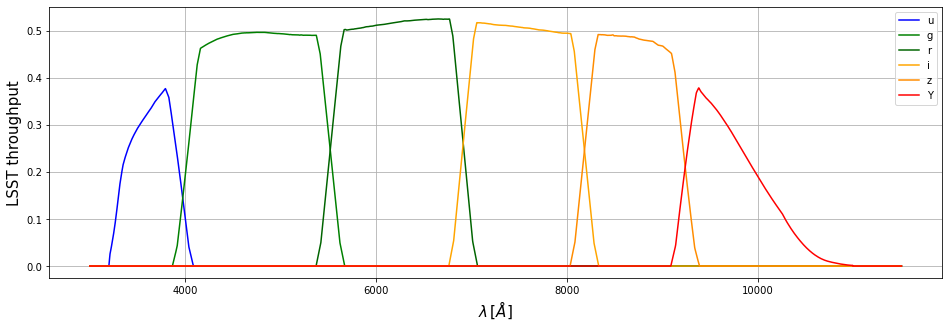

In [10]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
for index in range(len(lsst_bp0)):
    ax.plot(lsst_bp0[index].wave,lsst_bp0[index].throughput,label=filter_names[index],color=filter_colors[index])
    
ax.grid()
plt.xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
plt.ylabel('LSST throughput',fontsize=15)
plt.legend()

In [11]:
for filter in lsst_bp0:
    assert (filter.wave==lsst_bp0[0].wave).all()

In [12]:
wl_lsst = lsst_bp0[0].wave

# Load Euclid's filters 

In [13]:
euclid_path = './data/euclid/'

euclid_file_Y = 'NISP-PHOTO-PASSBANDS-V1-Y_throughput.dat'
euclid_file_J = 'NISP-PHOTO-PASSBANDS-V1-J_throughput.dat'
euclid_file_H = 'NISP-PHOTO-PASSBANDS-V1-H_throughput.dat'

In [14]:
fYe = np.loadtxt(os.path.join(euclid_path,euclid_file_Y))
fJe = np.loadtxt(os.path.join(euclid_path,euclid_file_J))
fHe = np.loadtxt(os.path.join(euclid_path,euclid_file_H))

In [15]:
eu_filters = ['Ye','Je','He']
eu_colors = {'Ye':'grey','Je':'brown','He':'k'}

9050.0 12450.0
1.91012e-08 0.784344
10050.0 16950.0
-1.79183e-05 0.80494
14050.0 21450.0
-0.000125533 0.792756


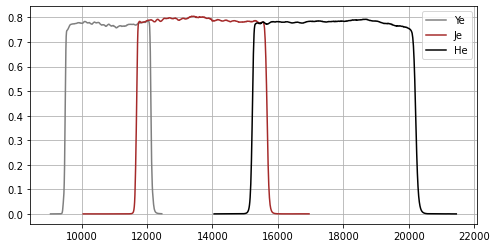

In [16]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

for filter_ in eu_filters:
    f_ = eval('f{0}'.format(filter_))
    wl_ = f_[:,0]*10
    T_ = f_[:,1]
    ax.plot(wl_,T_,label=filter_,color=eu_colors[filter_])
    print(np.min(wl_),np.max(wl_))
    print(np.min(T_),np.max(T_))
    
ax.grid()
ax.legend(loc="best")

# Load SWIFT's filters 

Reference: https://arxiv.org/pdf/0811.1205 

Files: http://svo2.cab.inta-csic.es/svo/theory/fps3/index.php?mode=browse&gname=Swift&asttype= 

In [17]:
swift_path = './data/swift/'

swift_file_uvw2 = 'Swift_UVOT.UVW2_fil.dat'
swift_file_uvm2 = 'Swift_UVOT.UVM2_fil.dat'
swift_file_uvw1 = 'Swift_UVOT.UVW1_fil.dat'

In [18]:
suvw2 = np.loadtxt(os.path.join(swift_path,swift_file_uvw2))
suvm2 = np.loadtxt(os.path.join(swift_path,swift_file_uvm2))
suvw1 = np.loadtxt(os.path.join(swift_path,swift_file_uvw1))

In [19]:
swift_filters = ['UVW2','UVM2','UVW1']
swift_colors = {'UVW2':'cyan','UVM2':'magenta','UVW1':'purple'}

1600.0 4310.0
0.00199501 0.43275
1600.0 3110.0
0.000999287 0.375385
1600.0 5970.0
0.00139696 0.40478


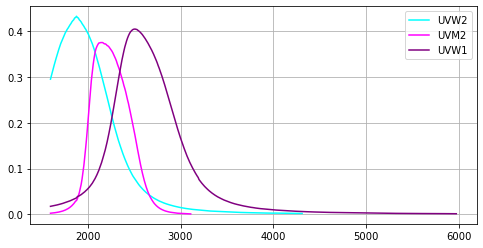

In [20]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

for filter_ in swift_filters:
    f_ = eval('s{0}'.format(filter_.lower()))
    wl_ = f_[:,0]
    T_ = f_[:,1]
    ax.plot(wl_,T_,label=filter_,color=swift_colors[filter_])
    print(np.min(wl_),np.max(wl_))
    print(np.min(T_),np.max(T_))
    
ax.grid()
ax.legend(loc="best")

## Define common wavelength range 

In [21]:
wl_lsst[-1],wl_lsst[-2]

(11500.000000001932, 11499.000000001934)

In [22]:
eu_max_wls = []
for filter_ in eu_filters:
    f_ = eval('f{0}'.format(filter_))
    wl_ = f_[:,0]*10
    
    eu_max_wls.append(np.max(wl_))
    
eu_max_wl = np.max(np.array(eu_max_wls))
print(eu_max_wl)

21450.0


In [23]:
swift_min_wls = []
for filter_ in swift_filters:
    f_ = eval('s{0}'.format(filter_.lower()))
    wl_ = f_[:,0]
    
    swift_min_wls.append(np.min(wl_))
    
swift_min_wl = np.min(np.array(swift_min_wls))
print(swift_min_wl)

1600.0


## Define common wavelength, $\lambda_{baseline}$ 

In [24]:
dwl = np.unique(np.diff(lsst_bp0[0].wave))
np.mean(dwl)

1.000000000000273

### We introduce $\lambda_0$ and $\lambda_{\infty}$ for later purposes 

In [25]:
lambda_0 = 0.0
lambda_inf = 1e8

In [26]:
#extended_wl = np.arange(wl_lsst[0],eu_max_wl)
#wl_baseline = np.arange(swift_min_wl,eu_max_wl)
wl_baseline = np.arange(lambda_0+1.,eu_max_wl)
print(len(wl_baseline),wl_baseline[0],wl_baseline[-1])

21449 1.0 21449.0


In [27]:
wl_baseline

array([1.0000e+00, 2.0000e+00, 3.0000e+00, ..., 2.1447e+04, 2.1448e+04,
       2.1449e+04])

## Effective wavelengths 

For each filter we can define the effective wavelength, $\lambda_b^{eff}$, as 

$$\lambda_b^{eff} = \frac{\int \lambda \, T_{tel,b}(\lambda) \, d\lambda}{\int T_{tel,b}(\lambda) \, d\lambda} \, . $$

In [28]:
def calc_eff_lambda(T):
    assert (np.isnan(T.throughput)==True).any()==False
    
    wl_ = T.wave
    trans_ = T.throughput
    
    num_ = np.trapz(wl_*trans_,x=wl_)
    den_ = np.trapz(trans_,x=wl_)
    
    return num_/den_

# Interpolate all filters to evaluate them at $\lambda_{baseline}$ 

In [29]:
lsst_bp = []
eff_lambda = {}
for fi_ in range(len(filters)):
    print(filters[fi_])
    wl_ = lsst_bp0[fi_].wave
    T_ = lsst_bp0[fi_].throughput
    T_[T_<=1e-3] = 0.
    print(len(wl_),len(T_))
    
    finterp_ = interp1d(wl_,T_,bounds_error=False,fill_value=0.)
    T_2 = finterp_(wl_baseline)
    
    lsst_i = S.ArrayBandpass(wl_baseline,T_2, name='LSST {0}'.format(filters[fi_]))
    lsst_bp.append(lsst_i)
    eff_wl_ = calc_eff_lambda(lsst_i)
    eff_lambda[filters[fi_]] = eff_wl_
    assert str(lsst_i.waveunits)==waveunits
    

u
8501 8501
g
8501 8501
r
8501 8501
i
8501 8501
z
8501 8501
Y
8501 8501


In [30]:
eff_lambda

{'u': 3646.662679925946,
 'g': 4775.691487833466,
 'r': 6221.859926396509,
 'i': 7538.740989090991,
 'z': 8695.989678941447,
 'Y': 9703.267866775377}

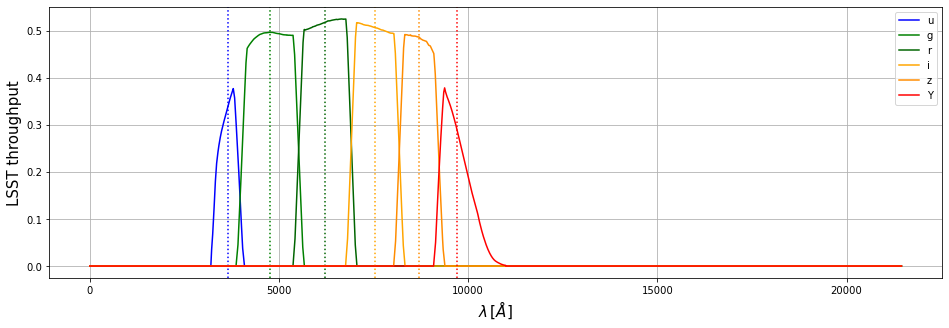

In [31]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)
for i,filter in enumerate(filters):
    ax.plot(lsst_bp[i].wave,lsst_bp[i].throughput,label=filter_names[i],color=filter_colors[i])
    ax.axvline(x=eff_lambda[filter],ls=':',color=filter_colors[i],alpha=1.0)
ax.grid()
plt.xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
plt.ylabel('LSST throughput',fontsize=15)
plt.legend()

In [32]:
euclid_bp = []
eu_eff_lambda = {}
for filter_ in eu_filters:
    print(filter_)
    f_ = eval('f{0}'.format(filter_))
    wl_ = f_[:,0]*10
    T_ = f_[:,1]
    T_[T_<=1e-3] = 0.
    print(len(wl_),len(T_))
    
    finterp_ = interp1d(wl_,T_,bounds_error=False,fill_value=0.)
    T_2 = finterp_(wl_baseline)
    
    eu_i = S.ArrayBandpass(wl_baseline,T_2, name='Euclid {0}'.format(filter_))
    eu_eff_wl_ = calc_eff_lambda(eu_i)
    eu_eff_lambda[filter_] = eu_eff_wl_
    assert str(eu_i.waveunits)==waveunits
    euclid_bp.append(eu_i)


Ye
341 341
Je
691 691
He
741 741


In [33]:
eu_eff_lambda

{'Ye': 10812.418203760846, 'Je': 13669.513885076847, 'He': 17707.85747696563}

In [34]:
euclid_bp[0].wave.max()

21449.0

In [35]:
swift_bp = []
swift_eff_lambda = {}
for filter_ in swift_filters:
    print(filter_)
    f_ = eval('s{0}'.format(filter_.lower()))
    wl_ = f_[:,0]
    T_ = f_[:,1]
    T_[T_<=1e-3] = 0.
    print(len(wl_),len(T_))
    
    finterp_ = interp1d(wl_,T_,bounds_error=False,fill_value=0.)
    T_2 = finterp_(wl_baseline)
    
    s_i = S.ArrayBandpass(wl_baseline,T_2, name='SWIFT {0}'.format(filter_))
    swift_eff_wl_ = calc_eff_lambda(s_i)
    swift_eff_lambda[filter_] = swift_eff_wl_
    assert str(s_i.waveunits)==waveunits
    swift_bp.append(s_i)


UVW2
272 272
UVM2
152 152
UVW1
438 438


In [36]:
swift_eff_lambda

{'UVW2': 2048.1172088131475,
 'UVM2': 2254.554140044102,
 'UVW1': 2676.8884517473484}

In [37]:
swift_bp[0].wave.min()

1.0

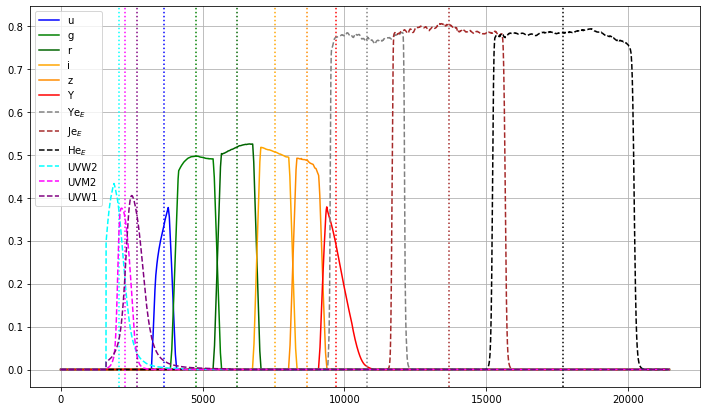

In [38]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111)

for i,filter_ in enumerate(filters):
    ax.plot(lsst_bp[i].wave,lsst_bp[i].throughput,label=filter_names[i],color=filter_colors[i])
    ax.axvline(x=eff_lambda[filter_],ls=':',color=filter_colors[i],alpha=1.0)
    
for i,filter_ in enumerate(eu_filters):
    ax.plot(euclid_bp[i].wave,euclid_bp[i].throughput,ls='--',color=eu_colors[filter_],label=filter_+r'$_E$')
    ax.axvline(x=eu_eff_lambda[filter_],ls=':',color=eu_colors[filter_],alpha=1.0)
    
for i,filter_ in enumerate(swift_filters):
    ax.plot(euclid_bp[i].wave,swift_bp[i].throughput,ls='--',color=swift_colors[filter_],label=filter_)
    ax.axvline(x=swift_eff_lambda[filter_],ls=':',color=swift_colors[filter_],alpha=1.0)
    
ax.grid()
ax.legend(loc="best")

# Load simulated transparencies 

Select variable parameter and specify airmass and clouds 

In [39]:
variable_param = 'pwv'
am0 = 1.2
cloud0 = 0.0
pwv0 = 3.0
aero0 = 0.04

Specify which distribution follows the simulated parameter. Options: 
* linear_distribution-discrete: generated following a linear function and with pre-established step (e.g., PWV = 1.0, 2.0, 3.0, ....) 
* linear_distribution-continuous: generated following a linear function and specifying only the value range and number of simulations (e.g., PWV = 1.0, 1.25, 1.5, ....) 
* uniform_distribution: generated following a uniform random distribution (work in progress) 
* specific_distribution: generated following random distributions specific to each parameter (work in progress) 


In [40]:
param_dist = 'linear_distribution-discrete'

In [41]:
outdir_plots_ = os.path.join('output_plots/',param_dist.split('-')[0])
if os.path.exists(outdir_plots_)==False:
    os.mkdir(outdir_plots_)

outdir_plots = os.path.join('output_plots/',param_dist.replace('-','/'))
if os.path.exists(outdir_plots)==False:
    os.mkdir(outdir_plots)

In [42]:
if variable_param=='airmass' or variable_param=='cloud':
    t_file = 'simulated_transparencies_varying_{0}.fits'.format(variable_param)
    t_file_ref = 'simulated_transparencies_varying_{0}_ref.fits'.format(variable_param)
else:
    t_file = 'simulated_transparencies_varying_{0}_airmass_{1}_cloud_{2}.fits'.format(variable_param,am0,cloud0)
    t_file_ref = 'simulated_transparencies_varying_{0}_airmass_{1}_cloud_{2}_ref.fits'.format(variable_param,am0,cloud0)

t_path = os.path.join('./simulated_transparencies/',param_dist.replace('-','/'))
t_in = os.path.join(t_path,t_file)
t_in_ref = os.path.join(t_path,t_file_ref)
t = fits.open(t_in)
t_ref = fits.open(t_in_ref)

In [43]:
head = t[0].header
data = t[0].data
print(data.shape)
data_ref = t_ref[0].data
print(data_ref.shape)

(10, 956)
(2, 956)


In [44]:
n_atmp = head['ID_RES']
n_sim = head['NTRANSP']
print(n_atmp, n_sim)

5 9


In [45]:
wl_t = data[0][n_atmp:]*10.

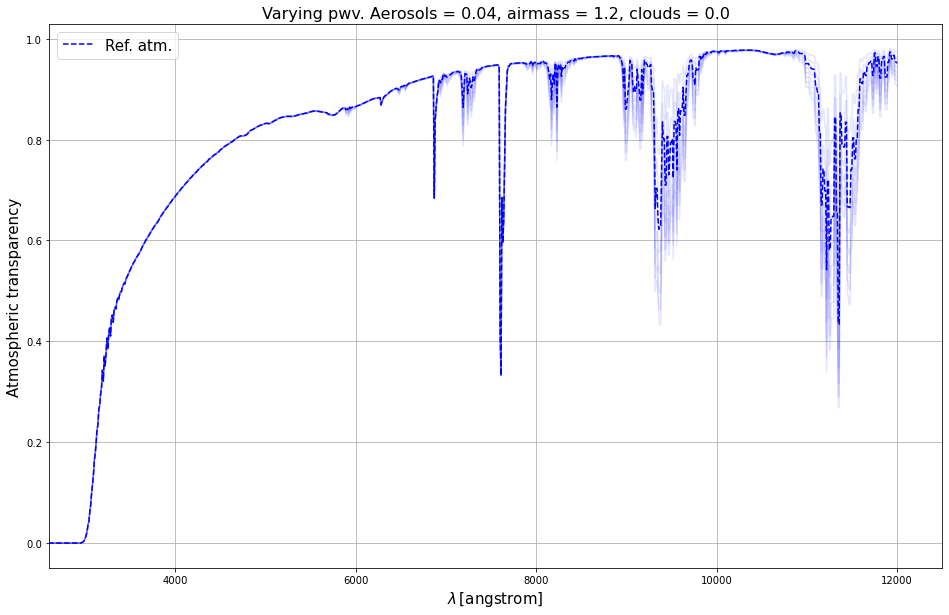

In [46]:
fig=plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
for atm_i in range(1,n_sim):
    ax.plot(wl_t,data[atm_i][n_atmp:],color='b',alpha=0.1)
ax.plot(wl_t,data_ref[1][n_atmp:],ls='--',color='b',label='Ref. atm.')
plt.xlim(2600.,12500.)
plt.grid()
plt.xlabel('$\\lambda \,$'+'[angstrom]',fontsize=15)
plt.ylabel('Atmospheric transparency',fontsize=15)
plt.title('Varying {0}. Aerosols = {1}, airmass = {2}, clouds = {3}'.format(variable_param,aero0,am0,cloud0),fontsize=16)
plt.legend(fontsize=15)
plt.savefig(os.path.join(outdir_plots,'atm_transparencies_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0)))

# Check range of values of variable parameter 

In [47]:
print(head)

SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  956                                                  NAXIS2  =                   10                                                  NTRANSP =                    9                                                  ID_AM   =                    4                                                  ID_VAOD =                    1                                                  ID_PWV  =                    0                                                  ID_O3   =                    2                                                  ID_CLD  =                    3                                                  ID_RES  =                    5                                                  END                                     

In [48]:
params_index = {'pwv':0,'aerosol':1,'ozone':2,'cloud':3,'airmass':4}

In [49]:
var_index = params_index[variable_param]

In [50]:
#data[1:,1]
data[1:,var_index]

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

# Select data for variable parameter of these simulations 

In [51]:
atm_vals = data[1:,var_index]

In [52]:
np.save('output_files/atm_vals_{0}_airmass_{1}_cloud_{2}.npy'.format(variable_param,am0,cloud0),atm_vals)

# Convert simulated transparencies into pysynphot format 

In [53]:
atm_transp = []
for i in range(1,n_sim+1):
    finterp_i = interp1d(wl_t,data[i][n_atmp:],bounds_error=False,fill_value=0.)
    atm_interp_i = finterp_i(wl_baseline)
    #atm_i = S.ArrayBandpass(wl_t,data[i][n_atmp:], name='Atm. transp. {0}'.format(i))
    atm_i = S.ArrayBandpass(wl_baseline,atm_interp_i, name='Atm. transp. {0}'.format(i))
    assert str(atm_i.waveunits)==waveunits
    atm_transp.append(atm_i)

In [54]:
finterp_ref = interp1d(wl_t,data_ref[1][n_atmp:],bounds_error=False,fill_value=0.)
atm_interp_ref = finterp_ref(wl_baseline)
#atm_i = S.ArrayBandpass(wl_t,data[i][n_atmp:], name='Atm. transp. {0}'.format(i))
atm_transp_ref = S.ArrayBandpass(wl_baseline,atm_interp_ref, name='Atm. transp. {0}'.format(i))
assert str(atm_transp_ref.waveunits)==waveunits

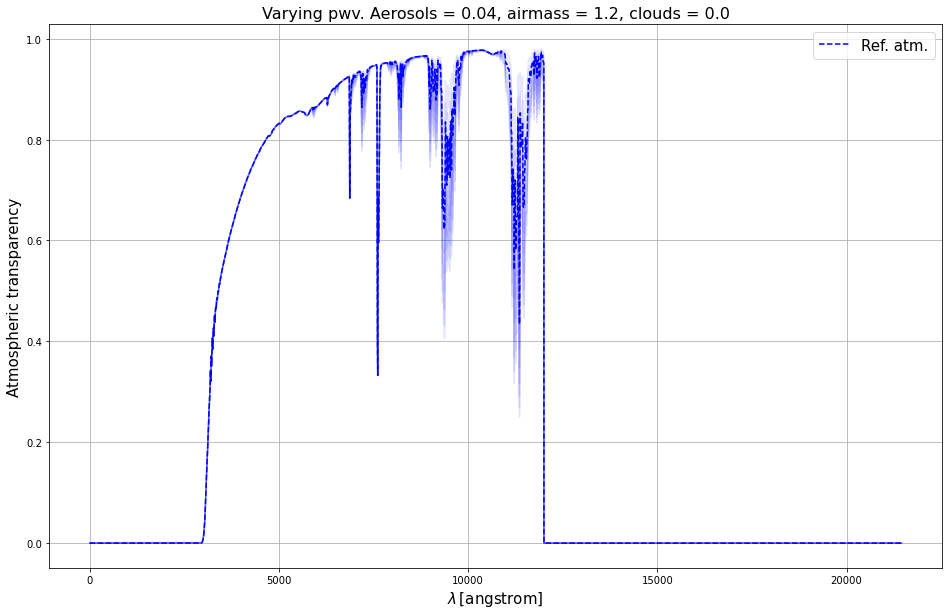

In [55]:
fig=plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
for i in range(n_sim):
    ax.plot(atm_transp[i].wave,atm_transp[i].throughput,color='b',alpha=0.1)
ax.plot(atm_transp_ref.wave,atm_transp_ref.throughput,ls='--',color='b',label='Ref. atm.')
#plt.xlim(2600.,12500.)
ax.grid()
ax.set_xlabel('$\\lambda \,$'+'[angstrom]',fontsize=15)
ax.set_ylabel('Atmospheric transparency',fontsize=15)
ax.set_title('Varying {0}. Aerosols = {1}, airmass = {2}, clouds = {3}'.format(variable_param,aero0,am0,cloud0),fontsize=16)
ax.legend(fontsize=15)

# Compute total bandpass (atmosphere(s) x LSST throughput) 

In [56]:
total_passband = {}
#for bpname in filters:
#    total_passband[bpname] = []

for index,bp in enumerate(lsst_bp):
    total_passband[filters[index]] = []
    for i in range(n_sim):
        total_pass = bp*atm_transp[i]
        total_passband[filters[index]].append(total_pass)

In [57]:
total_passband_ref = {}
for index,bp in enumerate(lsst_bp):
    total_pass = bp*atm_transp_ref
    total_passband_ref[filters[index]] = total_pass

In [58]:
print(len(total_passband['u']))
print(total_passband['u'][0])

9
(LSST u * Atm. transp. 1)


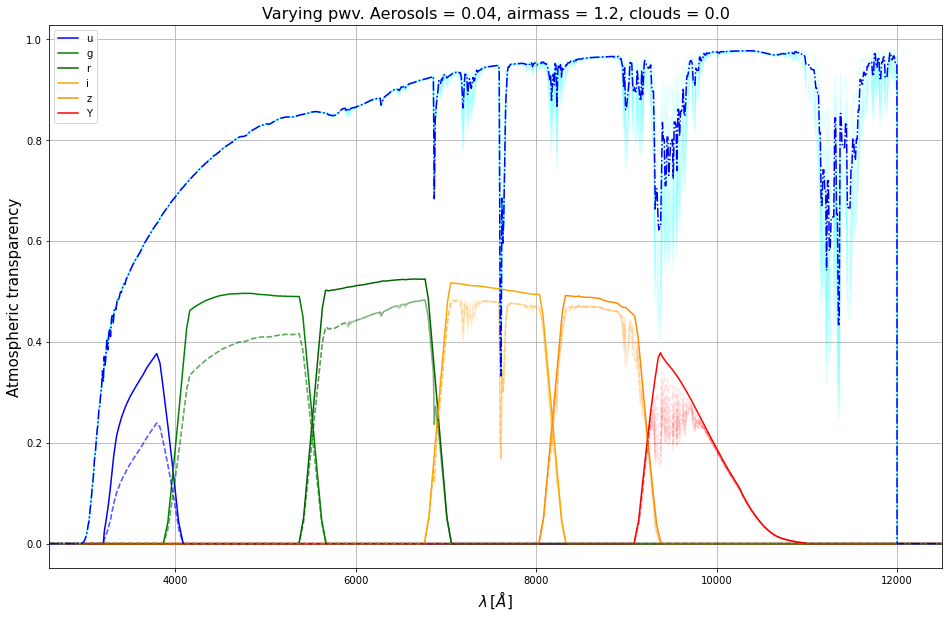

In [59]:
fig=plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
for index,bp in enumerate(lsst_bp):
    ax.plot(bp.wave,bp.throughput,label=filter_names[index],color=filter_colors[index])

for isim in range(n_sim):
    ax.plot(atm_transp[isim].wave,atm_transp[isim].throughput,alpha=0.1,color='cyan')
    for index,bpname in enumerate(filters):
        ax.plot(total_passband[bpname][isim].wave,total_passband[bpname][isim].throughput,ls='--',color=filter_colors[index],alpha=0.1)
ax.plot(atm_transp_ref.wave,atm_transp_ref.throughput,ls='-.',color='b')        
plt.xlim(2600.,12500.)
plt.grid()
plt.xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
plt.ylabel('Atmospheric transparency',fontsize=15)
plt.legend()
plt.title('Varying {0}. Aerosols = {1}, airmass = {2}, clouds = {3}'.format(variable_param,aero0,am0,cloud0),fontsize=16)
plt.savefig(os.path.join(outdir_plots,'total_passbands_varying_{0}_airmass_{1}_clouds_{2}.png'.format(variable_param,am0,cloud0)))

Plot the atmospheric transparencies corresponding to the minimum and maximum atmospheric parameter that we are varying: 

In [60]:
min_val_ = np.min(atm_vals)
max_val_ = np.max(atm_vals)
ref_val_ = eval('{0}0'.format(variable_param))
print(min_val_,max_val_,ref_val_)

1.0 9.0 3.0


In [61]:
min_ind_ = np.where(atm_vals==min_val_)[0][0]
max_ind_ = np.where(atm_vals==max_val_)[0][0]
ref_ind_ = np.where(atm_vals==ref_val_)[0][0]

In [62]:
atm_transp[min_ind_].throughput

array([0., 0., 0., ..., 0., 0., 0.])

In [63]:
min_transp = atm_transp[min_ind_]
max_transp = atm_transp[max_ind_]
ref_transp = atm_transp[ref_ind_]

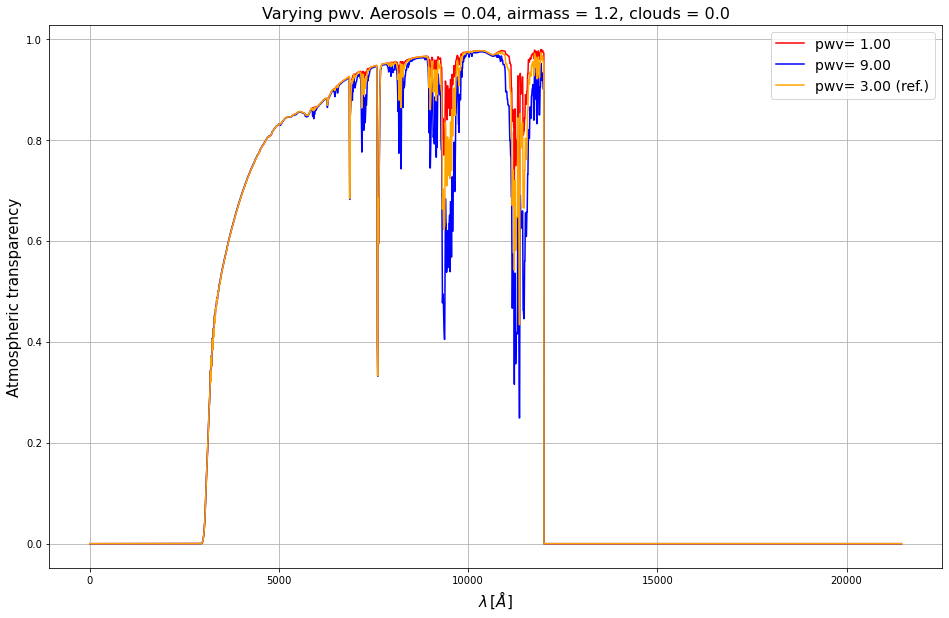

In [64]:
fig=plt.figure(figsize=(16,10))
plt.plot(min_transp.wave,min_transp.throughput,color='r',label=variable_param+'= {0:.2f}'.format(min_val_))
plt.plot(max_transp.wave,max_transp.throughput,color='b',label=variable_param+'= {0:.2f}'.format(max_val_))
plt.plot(ref_transp.wave,ref_transp.throughput,color='orange',label=variable_param+'= {0:.2f} (ref.)'.format(ref_val_))
plt.xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
plt.ylabel('Atmospheric transparency',fontsize=15)
plt.grid()
plt.legend(fontsize=14)
plt.title('Varying {0}. Aerosols = {1}, airmass = {2}, clouds = {3}'.format(variable_param,aero0,am0,cloud0),fontsize=16)
plt.savefig(os.path.join(outdir_plots,'atm_transparencies_varying_{0}_airmass_{1}_clouds_{2}_min_max_values.png'.format(variable_param,am0,cloud0)))

# Define paths to spectral atlases 

In [65]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_dict = {
    'calspec':os.path.join(pysynphot_root_path,'calspec'),
    'bpgs':os.path.join(pysynphot_root_path,'grid/bpgs'),
    'jacoby':os.path.join(pysynphot_root_path,'grid/jacobi'),
    'pickles':os.path.join(pysynphot_root_path,'grid/pickles/dat_uvk')
}

atlas_dir = 'spectral_atlases/'
file_dict = {
    'calspec':'',
    'bpgs':os.path.join(atlas_dir,'atlas_bpgs.txt'),
    'jacoby':os.path.join(atlas_dir,'atlas_jacoby.txt'),
    'pickles':os.path.join(atlas_dir,'atlas_pickles.txt')
}


# Select a spectral atlas 

Options: 
* calspec (HST calibration spectra): work in progress, need to separate stars from AGNs and other sources 
* bpgs (Bruzual-Persson-Gunn-Stryker): 175 spectra 
* jacobi (Jacoby-Hunter-Christian): 161 spectra 
* pickles (Pickles): 131 spectra 

In [66]:
atlas_name = 'pickles'

atlas_path = path_dict[atlas_name]
atlas_file = file_dict[atlas_name]

# Find the spectra files and information 

In [67]:
#path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
atlas_seds = pd.read_csv(atlas_file)
atlas_seds

,File,Type,Teff,Name
0,pickles_uk_1.fits,O5V,39810.70,unknown
1,pickles_uk_2.fits,O9V,35481.40,unknown
2,pickles_uk_3.fits,B0V,28183.80,unknown
3,pickles_uk_4.fits,B1V,22387.20,unknown
4,pickles_uk_5.fits,B3V,19054.60,unknown
...,...,...,...,...
126,pickles_uk_127.fits,G8I,4591.98,unknown
127,pickles_uk_128.fits,K2I,4255.98,unknown
128,pickles_uk_129.fits,K3I,NaN,unknown
129,pickles_uk_130.fits,K4I,3990.25,unknown


# Load with pysynphot the spectra from the selected atlas and interpolate to evaluate at $\lambda_{baseline}$ 

In [68]:
sed_list = np.array(atlas_seds['File'])
print(len(sed_list))

131


In [69]:
full_sed_dict = {}
type_dict = {}
wl_spec_0 = S.FileSpectrum(os.path.join(atlas_path,sed_list[0])).wave
wl_same = []
for i,sed in enumerate(sed_list):
    #print('-------')
    #print(sed)
    spec0_ = S.FileSpectrum(os.path.join(atlas_path,sed))
    spec0_.convert('photlam')
    #print(spec0_.fluxunits)
    assert str(spec0_.waveunits)==waveunits
    wl_same.append((spec0_.wave==wl_spec_0).all())
    finterp_ = interp1d(spec0_.wave,spec0_.flux,bounds_error=False,fill_value=0.)
    interp_spec_ = finterp_(wl_baseline)
    spec_ = S.ArraySpectrum(wl_baseline,interp_spec_)
    #spec_.convert('photlam')
    full_sed_dict[sed[:-5]] = spec_
    type_dict[sed[:-5]] = atlas_seds['Type'][i]
    
wl_same = np.array(wl_same)
print((wl_same==True).all())
#wl_spec = wl_spec_0

True


In [70]:
select_type = 'M'

In [71]:
sed_dict = {}

for key in type_dict:
    if select_type=='all':
        sed_dict = full_sed_dict
    else:
        if select_type in type_dict[key]:
            sed_dict[key] = full_sed_dict[key]

In [72]:
sed_dict

{'pickles_uk_38': <pysynphot.spectrum.ArraySourceSpectrum at 0x7fd6b6e7bb80>,
 'pickles_uk_39': <pysynphot.spectrum.ArraySourceSpectrum at 0x7fd6b6e09c70>,
 'pickles_uk_40': <pysynphot.spectrum.ArraySourceSpectrum at 0x7fd6b6e6fdf0>,
 'pickles_uk_41': <pysynphot.spectrum.ArraySourceSpectrum at 0x7fd6b6e11dc0>,
 'pickles_uk_42': <pysynphot.spectrum.ArraySourceSpectrum at 0x7fd6b6e7beb0>,
 'pickles_uk_43': <pysynphot.spectrum.ArraySourceSpectrum at 0x7fd6b6e6f760>,
 'pickles_uk_44': <pysynphot.spectrum.ArraySourceSpectrum at 0x7fd6b6e09220>,
 'pickles_uk_45': <pysynphot.spectrum.ArraySourceSpectrum at 0x7fd6b6e11970>,
 'pickles_uk_95': <pysynphot.spectrum.ArraySourceSpectrum at 0x7fd6b6e39e80>,
 'pickles_uk_96': <pysynphot.spectrum.ArraySourceSpectrum at 0x7fd6b6e32e20>,
 'pickles_uk_97': <pysynphot.spectrum.ArraySourceSpectrum at 0x7fd6b6e39730>,
 'pickles_uk_98': <pysynphot.spectrum.ArraySourceSpectrum at 0x7fd6b6e257c0>,
 'pickles_uk_99': <pysynphot.spectrum.ArraySourceSpectrum at 0x7

In [73]:
example_id = 'pickles_uk_104'

In [74]:
sed_dict = {example_id:sed_dict[example_id]}
sed_dict

{'pickles_uk_104': <pysynphot.spectrum.ArraySourceSpectrum at 0x7fd6b6e327c0>}

In [75]:
type_dict = {example_id:type_dict[example_id]}
type_dict

{'pickles_uk_104': 'M9III'}

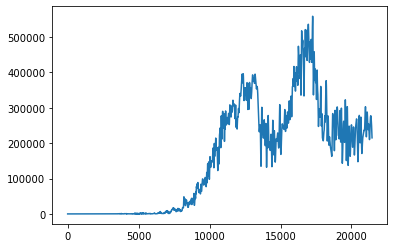

In [76]:
plt.plot(sed_dict[example_id].wave,sed_dict[example_id].flux)
sed_dict[example_id].fluxunits

In [77]:
sed_dict[example_id].wave

array([1.0000e+00, 2.0000e+00, 3.0000e+00, ..., 2.1447e+04, 2.1448e+04,
       2.1449e+04])

# Define also the spectral types 

In [78]:
spectral_types = ['O','B','A','F','G','K','M']
if select_type=='all':
    pass
else:
    spectral_types = list(select_type)
spectral_types

['M']

<img align="center" src = Stellar_Classification_Chart.png width=750 style="padding: 10px"> 

https://upload.wikimedia.org/wikipedia/commons/3/37/Stellar_Classification_Chart.png

# Organise spectra by spectral type 

In [79]:
spec_by_type = {}
for i in range(len(spectral_types)):
    spec_type = spectral_types[i]
    
    type_list_ = []
    spec_by_type[spec_type] = []
    for sed_ in type_dict.keys():
        if spec_type in type_dict[sed_]:
            type_list_.append(type_dict[sed_])
            spec_by_type[spec_type].append(sed_dict[sed_])
    print(spec_type, type_list_)
    print(len(type_list_))
    print('-----------')

M ['M9III']
1
-----------


Now we can plot them by spectral type separately 

In [80]:
type_colors = {'O':'b','B':'dodgerblue','A':'cyan','F':'g','G':'gold','K':'r','M':'brown'}

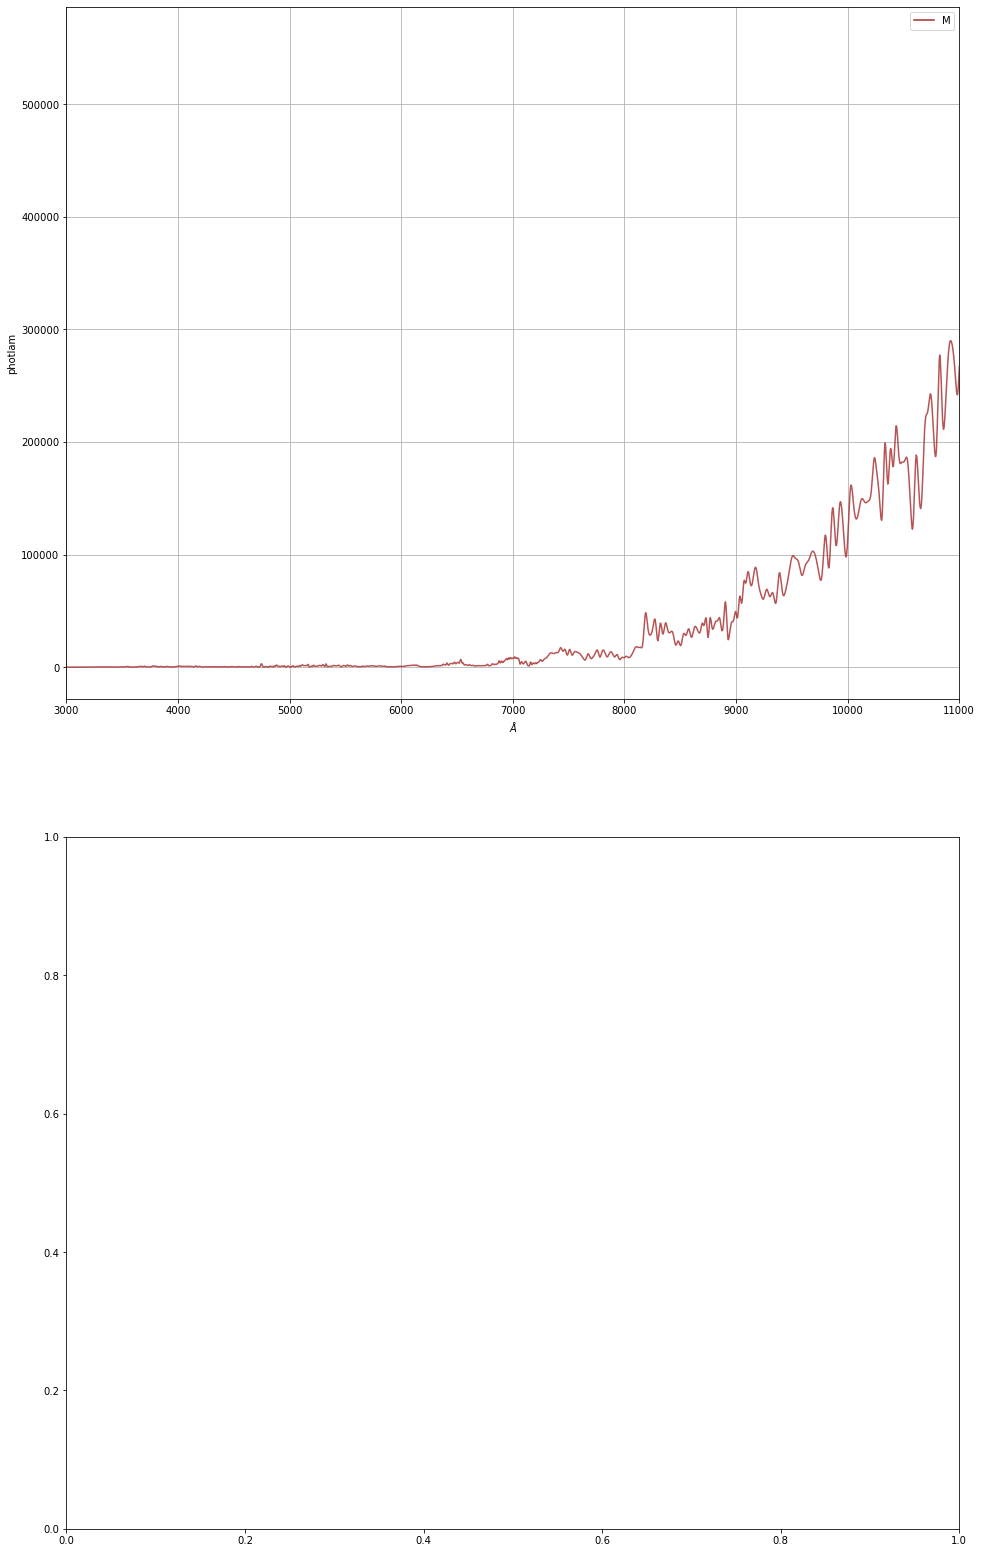

In [81]:
num_rows = len(spectral_types)+1
fig, axs = plt.subplots(num_rows, 1, figsize=(16,28))

for row,st in enumerate(spectral_types):
    for spec in spec_by_type[st]:
        spec.convert('photlam')
        axs[row].plot(spec.wave,spec.flux,color=type_colors[st],alpha=0.8)
    axs[row].plot([],[],label=st,color=type_colors[st])
    axs[row].grid()
    #axs[row].set_yscale("log")
    axs[row].set_xlabel(wavelabel)
    axs[row].set_ylabel(spec.fluxunits)
    axs[row].legend()
    axs[row].set_xlim(3000,11000)
    #axs[row].set_ylim(10,10000)
    #axs[row].set_yscale("log")
            

# Now we assign an ID to each object and we also classify these IDs by spectral type 

In [82]:
id_dict = {}
for i,sed in enumerate(sed_dict.keys()):
    #id_dict[sed[:-5]] = '{0}'.format(i+1).zfill(len(str(len(sed_list))))
    id_dict[sed] = '{0}'.format(i+1).zfill(len(str(len(sed_list))))

In [83]:
id_by_type = {}
for i in range(len(spectral_types)):
    spec_type = spectral_types[i]
    
    id_list_ = []
    id_by_type[spec_type] = []
    for sed_ in id_dict.keys():
        if spec_type in type_dict[sed_]:
            id_list_.append(id_dict[sed_])
            id_by_type[spec_type].append(sed_)
    print(spec_type, id_list_)
    print(len(id_list_))
    print('-----------')

M ['001']
1
-----------


# Calculate fluxes through total passbands 

Let's start with one spectrum of a type A star as example 

In [84]:
# Example with one spectrum 
test_type = 'M'
test_spec = 0
example_spec = spec_by_type[test_type][test_spec]
example_id = id_by_type[test_type][test_spec]
print(example_spec,example_id)

UnnamedArraySpectrum pickles_uk_104


In [85]:
obs_flux_t_dict = {}
obs_flux_std_dict = {}

for ised in sed_dict.keys():
    #print(ised)
    sed_ = sed_dict[ised]
    
    obstotal_dict_ = {}
    for filter_ in filters:
        obstotal_dict_[filter_] = []

    for filter_ in filters:
        #print(filter.name.upper())
        for i in range(n_sim):
            #total_pass = filter*atm_transp[i]
            #obs = S.Observation(spec,total_pass,force='taper')
            obstotal_ = S.Observation(sed_,total_passband[filter_][i],force='taper')
            obstotal_dict_[filter_].append(obstotal_)
    
    obs_flux_t_dict[ised] = obstotal_dict_

    obstotal_dict_ref_ = {}
    for filter_ in filters:
        obstotal_ = S.Observation(sed_,total_passband_ref[filter_],force='taper')
        obstotal_dict_ref_[filter_] = obstotal_
        if ised=='pickles_uk_131':
            print(filter_,np.trapz(obstotal_.flux,x=obstotal_.wave))
        
    obs_flux_std_dict[ised] = obstotal_dict_ref_
    

In [86]:
obs_flux_std_dict[example_id]['u'].wave

array([5.0000e-01, 1.0000e+00, 2.0000e+00, ..., 2.1448e+04, 2.1449e+04,
       2.1450e+04])

# Calculate magnitudes with our own function 

Physical constants 

In [87]:
c_light = S.units.C #speed of light [Angstrom /s] 
print(c_light)
h_planck = S.units.H #Planck's constant [erg*s] 
print(h_planck)

2.99792458e+18
6.6262e-27


In [88]:
# Reference flux value for an AB source in erg / s / cm2 / Hz 
f_ref = 3.63*10**(-20)

In [89]:
# Pivot wavelength [cm] 
wl_piv = 5.4929*10**(-5)

In [90]:
C = f_ref/(h_planck*wl_piv*10**8.)
print(C)

997.3334660532323


Definition of functions 

In [91]:
# The SED of an AB source (that is, constant flux in frequency units) expressed in photons / s / cm^2 / Angstrom 
def ABnphot(wl):
    #return 997.2*5500./wl
    return C*wl_piv*10**8./wl

We check that this function actually creates a spectrum with the properties of an AB source, that is, a flat spectrum in fnu units (erg/s/cm2/Hz) 

Text(0, 0.5, 'Flux [Jy]')

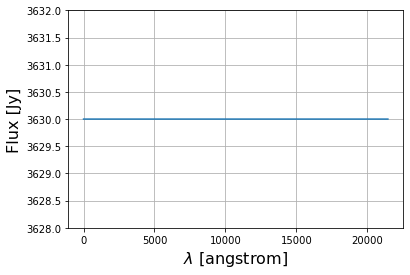

In [92]:
checkab = ABnphot(example_spec.wave)
checkab_ = S.ArraySpectrum(example_spec.wave, checkab, name='Flat AB spectrum')
#plt.plot(checkab_.wave,checkab_.flux)
checkab_.convert('fnu')
plt.plot(checkab_.wave,checkab_.flux*10**23.)
plt.ylim(3.628*10.**3,3.632*10**3.)
plt.grid()
plt.xlabel(r'$\lambda$ [angstrom]',fontsize=16)
plt.ylabel('Flux [Jy]',fontsize=16)

Now, we define our function to compute the AB magnitudes: 

$$m_{AB} = -2.5 \log_{10} \frac{\int F_{\nu}^E(\lambda) \cdot S_{eff} \cdot t_{exp} \cdot S_{passband}(\lambda) \frac{d\lambda}{h \lambda}}{\int F_{\nu, AB}^E \cdot S_{eff} \cdot t_{exp} \cdot S_{throughput}(\lambda) \frac{d\lambda}{h \lambda}} = -2.5 \log_{10} \frac{\varphi}{\Phi_{AB}} \, . $$ 

Now, we want to compute the error for the AB magnitudes. The denominator is constant for a given $S_{throughput}(\lambda)$, so we assume it does not contribute to the error. Then, we can approximate $\varphi$ as 

$$\varphi \approx \sum_i F_{\nu}^E(\lambda_i) \cdot S_{eff} \cdot t_{exp} \cdot S_{passband}(\lambda_i) \frac{\Delta \lambda_i}{h \lambda_i} = \sum_i n_i \cdot S_{passband}(\lambda_i) \cdot \Delta \lambda_i \, , $$ 

where $n_i$ is 

$$n_i = \frac{F_{\nu}^E(\lambda_i) \cdot S_{eff} \cdot t_{exp}}{h \lambda_i} \, ,$$

the number of photo-electrons received within a given bin of wavelength, $\Delta \lambda_i$. Then, we can assume that $n_i$ is a Poisson random variable, so 

$$\sigma^2_{n_i} = n_i . $$ 

Taking this into account, we can write the error of $\varphi$ as 

$$\sigma^2_{\varphi} = \sum_i \left( \frac{\partial \varphi}{\partial n_i} \right)^2 \sigma^2_{n_i} = \sum_i n_i \cdot \left( S_{passband}(\lambda_i) \cdot \Delta \lambda_i \right)^2 \, , $$ 

Finally, the error on $m_{AB}$ is given by 
$$\sigma^2_{m_{AB}} = \left( \frac{\partial m_{AB}}{\partial \varphi} \right)^2 \sigma^2_{\varphi} = \left( \frac{-2.5}{\varphi \log 10} \right)^2 \cdot \sum_i n_i \cdot \left( S_{passband}(\lambda_i) \cdot \Delta \lambda_i \right)^2 \, . $$ 


In [93]:
def int_flux(spec,passband,filter=None,input_funits='photlam',return_mag=False,return_error=False,
             PhiAB=None,renormalize=None,verbose=False):
    f_units = str(spec.fluxunits)
    assert f_units==input_funits
    if f_units!='fnu' and f_units!='photlam':
        if verbose:
            print('ATTENTION: converting flux units to fnu')
        spec.convert('fnu')
    f_units = str(spec.fluxunits)
    #print(f_units)
    observation = S.Observation(spec,passband,force='taper')
    if verbose:
        print('Observation units = ', observation.fluxunits)
    nan_mask = np.isnan(observation.flux)
    
    obs_wave_ = observation.wave[~nan_mask]
    obs_flux_ = observation.flux[~nan_mask]
    #wave_min = np.min(observation.wave[~nan_mask])
    #wave_max = np.max(observation.wave[~nan_mask])
    
    if renormalize!=None:
        renorm = np.power(10.,-1.*renormalize/2.5)
    else:
        renorm = 1.0
    
    if f_units=='fnu':
        num = np.trapz(obs_flux_*renorm/obs_wave_,x=obs_wave_)*Seff*exptime/h_planck
    elif f_units=='photlam':
        num = np.trapz(obs_flux_*renorm,x=obs_wave_)*Seff*exptime
    
    if return_error:
        if f_units!='fnu':
            raise Exception('This needs to be coded yet')
        
        finterp_pb = interp1d(passband.wave,passband.throughput,bounds_error=False,fill_value=0.)
        pb_interp = finterp_pb(spec.wave)
        
        delta_lambda = list(np.diff(spec.wave))
        delta_lambda.append(spec.wave[-1]-spec.wave[-2])
        delta_lambda = np.array(delta_lambda)
        assert len(delta_lambda)==len(spec.wave)
        
        assert str(spec.fluxunits)=='fnu'
        n_i = spec.flux*renorm*Seff*exptime/(spec.wave*h_planck)
        print('n_i = ', n_i)
        #print('Number of collected photoelectrons = {0:.2e}'.format(np.sum(n_i*pb_interp)))
        err2_num = np.sum(n_i*(np.array(pb_interp)*delta_lambda)**2.)
    
    spec.convert(f_units)
    
    if verbose:
        print('Numerator = {0:.2e}'.format(num))
    if return_error and verbose:
        print('Variance of the numerator = {0:.2e}'.format(err2_num))
    
    if return_mag:
        
        if PhiAB is None:
            assert filter is not None
            flatsp_nphot = ABnphot(spec.wave)
            flatsp_ = S.ArraySpectrum(spec.wave, flatsp_nphot, name='Flat AB spectrum')

            flatsp_.convert('fnu')
            ab_obs = S.Observation(flatsp_,filter,force='taper')
            if verbose:
                print('AB observation units = ', ab_obs.fluxunits)

            ab_wave_ = ab_obs.wave[~nan_mask]
            ab_flux_ = ab_obs.flux[~nan_mask]

            den = np.trapz(ab_flux_/ab_wave_,x=ab_wave_)*Seff*exptime/h_planck
        else:
            den = PhiAB
            if verbose:
                print('ATTENTION: using external Phi_AB. Not computing it')

        if verbose:
            print('Denominator = {0:.2e}'.format(den))
        mab = -2.5*np.log10(num/den)
        if verbose:
            print('AB magnitude = ', mab)
            print('---------')
    
    if return_mag==False:
        if return_error:
            return num,np.sqrt(err2_num)
        else:
            return num
    else:
        if return_error:
            if f_units!='fnu':
                raise Exception('This needs to be coded yet')
            err2_mab = (2.5**2./np.log(10.)**2.)*err2_num/num**2.
            err_mab = np.sqrt(err2_mab)
            return num,mab,np.sqrt(err2_num),err_mab
        else:
            return num,mab
    

To avoid computing $\Phi_{AB}$ each time, we define that integral once and we give it to our function each time it is needed 

In [94]:
flatsp_nphot = ABnphot(example_spec.wave)

In [95]:
flat_spec = S.ArraySpectrum(example_spec.wave, flatsp_nphot, name='Flat AB spectrum')

In [96]:
flat_spec.fluxunits

In [97]:
Phi_AB = []
for filter in lsst_bp:
    Phi_AB_b = int_flux(flat_spec,filter)
    Phi_AB.append(Phi_AB_b)
    print(Phi_AB_b)
Phi_AB = np.array(Phi_AB)

3088380552010.815
8219700730652.069
6160604227593.574
4552576767524.609
3081702665648.3027
1647811503986.3528


In [98]:
for filter in lsst_bp:
    nn,mm = int_flux(flat_spec,filter,filter=filter,input_funits='photlam',return_mag=True,verbose=True)
    print(nn,mm)

Observation units =  photlam
Numerator = 3.09e+12
AB observation units =  fnu
Denominator = 3.09e+12
AB magnitude =  -0.0
---------
3088380552010.815 -0.0
Observation units =  photlam
Numerator = 8.22e+12
AB observation units =  fnu
Denominator = 8.22e+12
AB magnitude =  -0.0
---------
8219700730652.069 -0.0
Observation units =  photlam
Numerator = 6.16e+12
AB observation units =  fnu
Denominator = 6.16e+12
AB magnitude =  -0.0
---------
6160604227593.574 -0.0
Observation units =  photlam
Numerator = 4.55e+12
AB observation units =  fnu
Denominator = 4.55e+12
AB magnitude =  -2.4108186663832173e-16
---------
4552576767524.609 -2.4108186663832173e-16
Observation units =  photlam
Numerator = 3.08e+12
AB observation units =  fnu
Denominator = 3.08e+12
AB magnitude =  -0.0
---------
3081702665648.3027 -0.0
Observation units =  photlam
Numerator = 1.65e+12
AB observation units =  fnu
Denominator = 1.65e+12
AB magnitude =  -0.0
---------
1647811503986.3528 -0.0


In [99]:
for i,filter in enumerate(lsst_bp):
    nn,mm = int_flux(flat_spec,filter,input_funits='photlam',return_mag=True,verbose=True,PhiAB=Phi_AB[i])
    print(nn,mm)

Observation units =  photlam
Numerator = 3.09e+12
ATTENTION: using external Phi_AB. Not computing it
Denominator = 3.09e+12
AB magnitude =  -0.0
---------
3088380552010.815 -0.0
Observation units =  photlam
Numerator = 8.22e+12
ATTENTION: using external Phi_AB. Not computing it
Denominator = 8.22e+12
AB magnitude =  -0.0
---------
8219700730652.069 -0.0
Observation units =  photlam
Numerator = 6.16e+12
ATTENTION: using external Phi_AB. Not computing it
Denominator = 6.16e+12
AB magnitude =  -0.0
---------
6160604227593.574 -0.0
Observation units =  photlam
Numerator = 4.55e+12
ATTENTION: using external Phi_AB. Not computing it
Denominator = 4.55e+12
AB magnitude =  -0.0
---------
4552576767524.609 -0.0
Observation units =  photlam
Numerator = 3.08e+12
ATTENTION: using external Phi_AB. Not computing it
Denominator = 3.08e+12
AB magnitude =  -0.0
---------
3081702665648.3027 -0.0
Observation units =  photlam
Numerator = 1.65e+12
ATTENTION: using external Phi_AB. Not computing it
Denomina

NOTE: we store the integrated fluxes, $\vec{\varphi}_i(t)$ and magnitudes, $\vec{m}_i(t)$, through the standard atmosphere separately for checking purposes. In general, we will only have the integrated fluxes through the current atmosphere 

In [100]:
Phi_AB

array([3.08838055e+12, 8.21970073e+12, 6.16060423e+12, 4.55257677e+12,
       3.08170267e+12, 1.64781150e+12])

In [101]:
phi_t_dict = {}
phi_std_dict = {}
mag_t_dict = {}
mag_std_dict = {}

for ised in sed_dict.keys():
    sed_ = sed_dict[ised]
    
    phi_dict_std_ = {}
    mag_dict_std_ = {}
    for index,filter_ in enumerate(filters):
        num_,mag_ = int_flux(sed_,total_passband_ref[filter_],
                        return_mag=True,PhiAB=Phi_AB[index])
        phi_dict_std_[filter_] = num_
        mag_dict_std_[filter_] = mag_
    phi_std_dict[ised] = phi_dict_std_
    mag_std_dict[ised] = mag_dict_std_
        
    phi_dict_t_ = {}
    mag_dict_t_ = {}
    
    for index,filter_ in enumerate(filters):
        phi_dict_t_[filter_] = []
        mag_dict_t_[filter_] = []
        for i in range(n_sim):
            num_,mag_ = int_flux(sed_,total_passband[filter_][i],
                           return_mag=True,PhiAB=Phi_AB[index])
            phi_dict_t_[filter_].append(num_)
            mag_dict_t_[filter_].append(mag_)
        
        phi_t_dict[ised] = phi_dict_t_
        mag_t_dict[ised] = mag_dict_t_
    #print('###########################################################')
    

In [102]:
#phi_t_dict[example_id]

In [103]:
#mag_t_dict[example_id]

u
g
r
i
z
Y
photlam


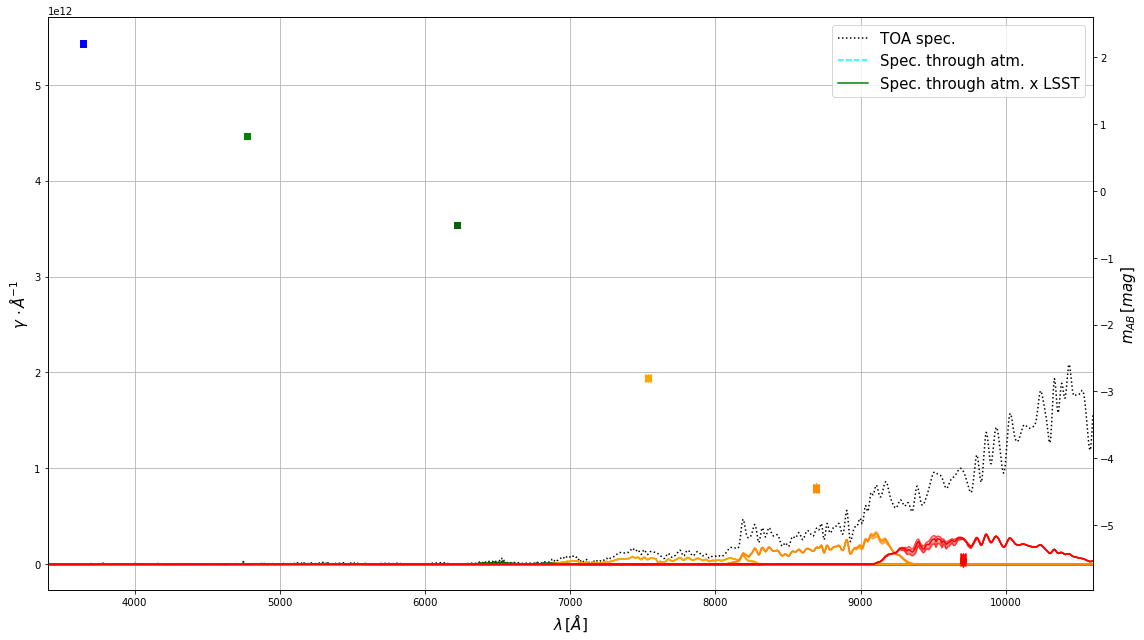

In [104]:
fig=plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111)

ax1.plot(sed_dict[example_id].wave,sed_dict[example_id].flux*Seff*exptime,ls=':',color='k',alpha=1.0)

ax2 = ax1.twinx()

for index,filter in enumerate(filters):
    print(filter)
    obs = obs_flux_std_dict[example_id][filter]
    ax1.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=1.0)
    for i in range(n_sim):
        obs = obs_flux_t_dict[example_id][filter][i]
        if i==min_ind_ or i==max_ind_:
            alpha = 0.7
        else:
            alpha = 0.2
        ax1.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=alpha)
        

ax1.set_xlim(WLMIN,WLMAX)
#ax1.set_ylim(0.,2e10)
ax1.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax1.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
ax1.grid()
ax1.plot([],[],ls=':',color='k',label='TOA spec.')
ax1.plot([],[],ls='--',color='cyan',label='Spec. through atm.')
ax1.plot([],[],ls='-',color='g',label='Spec. through atm. x LSST')

for index,filter in enumerate(filters):
    ax2.scatter(eff_lambda[filter],mag_std_dict[example_id][filter],marker='o',color=filter_colors[index])
    for i in range(n_sim):
        if i==min_ind_:
            marker = 'v'
        elif i==max_ind_:
            marker = '^'
        else:
            marker = 'x'
        ax2.scatter(eff_lambda[filter],mag_t_dict[example_id][filter][i],marker=marker,color=filter_colors[index])

ax2.set_ylabel(r'$m_{AB} \, [mag]$',fontsize=15)
ax1.legend(fontsize=15)
plt.tight_layout()
print(spec.fluxunits)

u
g
r
i
z
Y
photlam


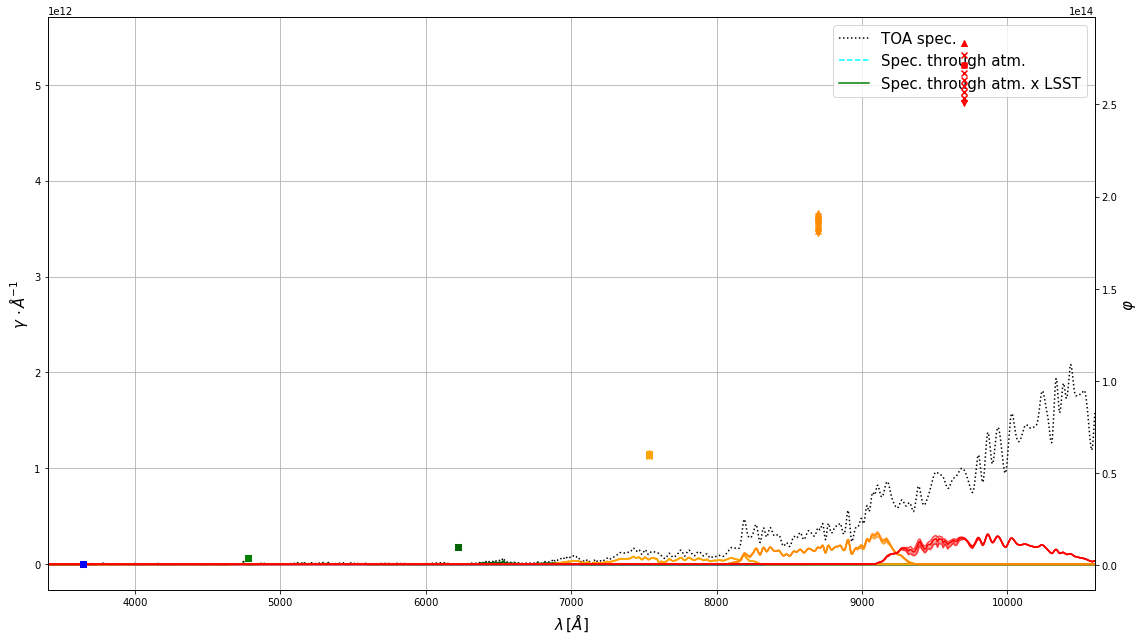

In [105]:
fig=plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111)

ax1.plot(sed_dict[example_id].wave,sed_dict[example_id].flux*Seff*exptime,ls=':',color='k',alpha=1.0)

ax2 = ax1.twinx()

for index,filter in enumerate(filters):
    print(filter)
    obs = obs_flux_std_dict[example_id][filter]
    ax1.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=1.0)
    for i in range(n_sim):
        obs = obs_flux_t_dict[example_id][filter][i]
        if i==min_ind_ or i==max_ind_:
            alpha = 0.7
        else:
            alpha = 0.2
        ax1.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=alpha)
        

ax1.set_xlim(WLMIN,WLMAX)
#ax1.set_ylim(0.,1.75e10)
#ax2.set_ylim(0,7.5e12)
ax1.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax1.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
ax1.grid()
ax1.plot([],[],ls=':',color='k',label='TOA spec.')
ax1.plot([],[],ls='--',color='cyan',label='Spec. through atm.')
ax1.plot([],[],ls='-',color='g',label='Spec. through atm. x LSST')

for index,filter in enumerate(filters):
    ax2.scatter(eff_lambda[filter],phi_std_dict[example_id][filter],marker='o',color=filter_colors[index])
    for i in range(n_sim):
        if i==min_ind_:
            marker = '^'
        elif i==max_ind_:
            marker = 'v'
        else:
            marker = 'x'
        ax2.scatter(eff_lambda[filter],phi_t_dict[example_id][filter][i],marker=marker,color=filter_colors[index])

ax2.set_ylabel(r'$\varphi$',fontsize=15)
ax1.legend(fontsize=15)
plt.tight_layout()
print(spec.fluxunits)

### We store the observed integrated flux, $\vec{\varphi}_i(t)$ 

We store it for 2 cases: 
- Variable / current total passband 
- Standard total passband 

In [106]:
wl_eff = []
for filter in filters:
    print(filter)
    wl_eff.append(eff_lambda[filter])
wl_eff = np.array(wl_eff)

u
g
r
i
z
Y


# Polynomial fit of the integrated fluxes 

We have 6 bands, *ugrizY*, so we have 6 integrated fluxes, $\varphi_b$. Then, we consider the observed vector $\vec{\varphi}$. We can think of these integrated fluxes as the signal of very low resolution spectra, i.e. with very wide wavelength bins. Considering this, we associate each $\varphi_b$ with the effective wavelength, $\lambda_b^{eff}$, defined as before. 

Now, let us suppose that for a given source at a given moment we have integrated flux measurements in $N_{obs}$ bands, with $N_{obs} \leq 6$. Then, let us consider that TOA SED of the source can be described by a function $\hat{F}(\lambda)$. We consider this function to be a polynomial of order $n = N_{obs}-1$, i.e., 

$$\hat{F}(\lambda) = \sum_{i=0}^n a_i \lambda^i \, . $$ 

For a given band, $b$, the function $\hat{F}(\lambda)$ should meet 

$$\int \hat{F}(\lambda) \cdot T_b(\lambda) \cdot S_{eff} \cdot t_{exp} \frac{d\lambda}{h \lambda} = \varphi_b \, , $$ 

where $\hat{F}(\lambda)$ is *fnu* units, i.e., $erg \, s^{-1} cm^{-2} Hz^{-1}$ (note the counter-intuitive notation). If we expand $\hat{F}(\lambda)$ in its polynomial form, we can rewrite this expression as 

$$ \sum_{i=0}^n a_i \phi_b^i = \varphi_b \, , $$ 

where 

$$ \phi_b^i(t) = \int \lambda^{i-1} \cdot T_b(\lambda,t) \cdot S_{eff} \cdot t_{exp} \frac{d\lambda}{h} \, . $$ 

For $N \geq 2$ we will have a system of linear equations on the coefficients $a_i$: 

$$\begin{cases} 
\sum_{i=0}^n a_i \phi_{b_1}^i = \varphi_{b_1} \, \\ \qquad \vdots \\ \sum_{i=0}^n a_i \phi_{b_N}^i = \varphi_{b_N} \, . 
\end{cases}$$ 

If we express this in matrix notation, we have 

$$\begin{bmatrix} \phi_{b_1}^0 & \cdots & \phi_{b_1}^n \\ \vdots & \ddots & \vdots \\ \phi_{b_N}^0 & \cdots & \phi_{b_N}^n \end{bmatrix} \, \begin{bmatrix} a_0 \\ \vdots \\ a_n \end{bmatrix} = \begin{bmatrix} \varphi_{b_1} \\ \vdots \\ \varphi_{b_N} \end{bmatrix} \, , $$ 

or in vector notation, 

$$ M_{\phi} \vec{a} = \vec{\varphi} \, , $$ 

We note that for this matrix product $N \times (n+1) \cdot (n+1) \times 1 = N $, where $N = N_{obs}$. Then, we can find the coefficients by solving 

$$ \vec{a} = M_{\phi}^{-1} \vec{\varphi} \, . $$ 

Note that the matrix $M_{\phi}$ depends only on the atmospheric conditions, parameterized by $t$, so it only needs to be calculated for a given set of conditions, not for each source. Therefore, $M_{\phi} = M_{\phi}(t)$. 


## Contour conditions: 

### Approach only valid for blue objects (we are not going to use it for now, but we leave it here just to have it localized): 
To ensure that the fitted spectrum follows the same trend as the original spectrum at least within a reasonable range of wavelengths, we are going to do the following: we need to impose that $\hat{F}(\lambda)$ tends to 0 at least when for the wavelengths close to the bluest and reddest filters. To do this, let us consider two delta filters centered at two given wavelength, $\lambda_b$ and $\lambda_r$, which are smaller than the smallest wavelength of the bluer filter and bigger than the biggest wavelength of the redder one, respetively. We can write this as 

$$T_{\delta_b}(\lambda) = \delta(\lambda - \lambda_b) \, ,$$ 

and 

$$T_{\delta_r}(\lambda) = \delta(\lambda - \lambda_r) \, .$$ 

Following the same logic as before, the function $\hat{F}(\lambda)$ will have to meet the condition 

$$\sum_{i=0}^n a_i \phi^i_{\delta} = 0 \, $$

where $\phi^i_{\delta}$ are given by 

$$\phi_{\delta}^i = \int \lambda^{i-1} \cdot \delta(\lambda-\lambda_{\delta}) \cdot S_{eff} \cdot t_{exp} \frac{d\lambda}{h} \, = \lambda_{\delta}^{i-1} \cdot S_{eff} \cdot t_{exp}/h \, , $$ 

where the subscript $\delta$ corresponds to both $b$ and $r$, respectively. 

If we account for the two artificial delta passbands, we will have for a given object at a given moment $N_{obs} + 2$ integrated fluxes and therefore the order of the polynomial $\hat{F}(\lambda)$ will be $n = N_{obs}+1$. We can then add these two conditions to the previous matrix, so we have 

$$\begin{bmatrix} \phi_{\delta_b}^0 & \cdots & \phi_{\delta_b}^n \\ \phi_{b_1}^0 & \cdots & \phi_{b_1}^n \\ \vdots & \ddots & \vdots \\ \phi_{b_N}^0 & \cdots & \phi_{b_N}^n \\ \phi_{\delta_r}^0 & \cdots & \phi_{\delta_r}^n \end{bmatrix} \, \begin{bmatrix} a_0 \\ \vdots \\ a_n \end{bmatrix} = \begin{bmatrix} \varphi_{\delta_b} \\ \varphi_{b_1} \\ \vdots \\ \varphi_{b_N} \\ \varphi_{\delta_r} \end{bmatrix} \, . $$ 

Then, we use this matrix the same way as described above. 

### Using Euclid's filters 

Suppose we take the integrated fluxes for the $z$ and $Y$ bands only and we follow the same procedure to find $\hat{F}(\lambda)$. To distinguish 1st order spectrum from the polynomial one, we will refer to it as $\tilde{F}^r(\lambda)$ and it will have the form 

$$\tilde{F}^r(\lambda) = \tilde{a}^r_0 + \tilde{a}^r_1 \lambda \, . $$

Then, using this fitted spectrum we can estimate the integrated fluxes for the Euclid's filters, $\tilde{\Phi}_E$: 

$$\tilde{\Phi}_E = \int \tilde{F}^r(\lambda) \cdot T_E(\lambda) \cdot S_{eff} \cdot t_{exp} \frac{d\lambda}{h \lambda}  \, . $$

This should add to some degree information about the shape / trend of the spectrum we are working with at the redder wavelengths. 

Once we have these estimated values, we incorporate them as additional filters to the matrix $M_{\phi}$. To do this, we are going to consider only one out of the three Euclid's filters: $J_E$.  

### Using SWIFT's filters 

We can do the same thing as with the Euclid's filters but for the bluer wavelengths by using the filters from SWIFT. In this case, we take the integrated fluxes for the $u$ and $g$ bands only and we define a linear function for the blue end as 

$$\tilde{F}^b(\lambda) = \tilde{a}^b_0 + \tilde{a}^b_1 \lambda \, . $$

From this function, we estimate the integrated fluxes from the SWIFT's filters, $\tilde{\Phi}_S$. In particular, we focus on the filter $UVM2$. 

### Total system of equations 

By following the two previous steps, we are increasing the order of the polynomial $\hat{F}(\lambda)$ that we use to estimate the TOA SED. Doing this, we have $n = N_{obs} - 1 + 2 = N_{obs} + 1$ and the matrix equation will be the following: 

$$\begin{bmatrix} \tilde{\phi}_{UWM2}^0 & \cdots & \tilde{\phi}_{UVM2}^n & \tilde{\phi}_{UVM2}^{n+1} \\ \phi_{b_1}^0 & \cdots & \phi_{b_1}^n & \phi_{b_1}^{n+1} \\ \vdots & \ddots & \vdots & \vdots \\ \phi_{b_N}^0 & \cdots & \phi_{b_N}^n & \phi_{b_N}^{n+1} \\ \tilde{\phi}_{J_E}^0 & \cdots & \tilde{\phi}_{J_E}^n & \tilde{\phi}_{J_E}^{n+1} \end{bmatrix} \, \begin{bmatrix} a_0 \\ \vdots \\ a_n \\ a_{n+1}\end{bmatrix} = \begin{bmatrix} \tilde{\Phi}_{UVM2} \\ \varphi_{b_1} \\ \vdots \\ \varphi_{b_N} \\ \tilde{\Phi}_{J_E} \end{bmatrix} \, . $$ 

Note that the matrix elements $\tilde{\phi}_E$, i.e. those corresponding to the Euclid's filters, should not depend on $t$, since we consider the Euclid's total passbands to correspond only to TOA observations. 


### We define $M_{\phi}$ by calculating the matrix elements, $\phi^i_b$ 

In [107]:
def phi_ij(wavelength,passband,i):
    
    T_b = passband.throughput
    assert len(wavelength)==len(T_b)
    
    phi_ij = np.trapz((wavelength**i)*T_b,x=wavelength)*Seff*exptime
    
    return phi_ij

In [108]:
def phi_ij_delta(wavelength,i):
    
    phi_ij = (wavelength**i)*Seff*exptime
    
    return phi_ij

In [109]:
def poly_f(l,a,output_funits='photlam',all_positive=False):
    val_ = 0.
    for i in range(len(a)):
        val_ = val_+a[i]*l**i
    
    if output_funits=='fnu':
        A = h_planck*l
    elif output_funits=='flam':
        A = l**2./c_light
    elif output_funits=='photlam':
        A = 1.
    else:
        A = 1.
    val_ = A*val_
    if all_positive:
        val_[val_<0.] = 0.
    
    return val_

### Compute TRUE integrated fluxes and magnitudes through Euclid's filters 

In [110]:
phi_eu_dict = {}
mag_eu_dict = {}

for ised in sed_dict.keys():
    sed_ = sed_dict[ised]
    
    phi_dict_std_ = {}
    mag_dict_std_ = {}
    for index,filter_ in enumerate(eu_filters):
        num_,mag_ = int_flux(sed_,euclid_bp[index],
                        return_mag=True,PhiAB=Phi_AB[index])
        phi_dict_std_[filter_] = num_
        mag_dict_std_[filter_] = mag_
    phi_eu_dict[ised] = phi_dict_std_
    mag_eu_dict[ised] = mag_dict_std_
    
    #print('###########################################################')
    

### Compute TRUE integrated fluxes and magnitudes through SWIFT's filters 

In [111]:
phi_swift_dict = {}
mag_swift_dict = {}

for ised in sed_dict.keys():
    sed_ = sed_dict[ised]
    
    phi_dict_std_ = {}
    mag_dict_std_ = {}
    for index,filter_ in enumerate(swift_filters):
        num_,mag_ = int_flux(sed_,swift_bp[index],
                        return_mag=True,PhiAB=Phi_AB[index])
        phi_dict_std_[filter_] = num_
        mag_dict_std_[filter_] = mag_
    phi_swift_dict[ised] = phi_dict_std_
    mag_swift_dict[ised] = mag_dict_std_
    
    #print('###########################################################')
    

# Black body spectrum 

<img align="center" src = blackbody.gif width=350 style="padding: 10px"> 

http://burro.cwru.edu/academics/Astr221/Light/blackbody.gif

The amount of energy emited by a black body at given temperature, $T$, per unit time, area, solid angle and wavelength is given by the Planck's law: 

$$B(\lambda,T) = \frac{2hc^2}{\lambda^5}\frac{1}{e^{hc/\lambda k T}-1} \, . $$

Since the objects that we work with as black bodies are far, far away, we can consider them as puntual, so we assume that the integrating solid angle is $d\Omega$. Therefore, we consider the units of this spectrum to be 

$$\newcommand{\AA}{\mathcal{\unicode{x212B}}}$$
$$B(\lambda,T) = \left[ \frac{erg}{s \cdot cm^2 \cdot \AA } \right]$$


In [112]:
#Boltzmann's constant [erg / K]
k_boltzmann = S.planck.K*1e7
print(k_boltzmann,c_light,h_planck)

1.38062e-16 2.99792458e+18 6.6262e-27


In [113]:
#bb0.fluxunits, example_spec.fluxunits

erg -> Nphoton = erg / (h c/lambda)

In [114]:
from astropy import units as u

In [115]:
from astropy import constants

In [116]:
constants.c

<<class 'astropy.constants.codata2018.CODATA2018'> name='Speed of light in vacuum' value=299792458.0 uncertainty=0.0 unit='m / s' reference='CODATA 2018'>

In [117]:
constants.h

<<class 'astropy.constants.codata2018.CODATA2018'> name='Planck constant' value=6.62607015e-34 uncertainty=0.0 unit='J s' reference='CODATA 2018'>

In [118]:
constants.k_B

<<class 'astropy.constants.codata2018.CODATA2018'> name='Boltzmann constant' value=1.380649e-23 uncertainty=0.0 unit='J / K' reference='CODATA 2018'>

In [119]:
constants.h*constants.c/(1000.*u.meter*constants.k_B*5000.*u.Kelvin)

<Quantity 2.87755376e-09>

https://nuclear-power.com/wp-content/uploads/blackbody-radiation-chart-min.png

In [120]:
h_planck,c_light,k_boltzmann

(6.6262e-27, 2.99792458e+18, 1.38062e-16)

In [121]:
example_spec.waveunits

In [122]:
def black_body(l,T,output_funits='photlam'):
    if output_funits=='photlam':
        A = l/(h_planck*c_light)
    elif output_funits=='flam':
        A = 1.
    #factor = 1e16
    factor = 1.
    numerator = 2.*factor*h_planck*(c_light**2.)/(l**5.)
    denominator = np.exp(h_planck*c_light/(l*k_boltzmann*T))-1.
    B = A*numerator/denominator
    #bb_spec_ = S.ArraySpectrum(l,B,name='Black body spectrum, T={0}K'.format(T))
    #return bb_spec_
    #return l,B
    return B

In [123]:
Ttest = 10000

/tmp/ipykernel_210277/2487732627.py:9: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(h_planck*c_light/(l*k_boltzmann*T))-1.
/tmp/ipykernel_210277/2487732627.py:9: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(h_planck*c_light/(l*k_boltzmann*T))-1.
/tmp/ipykernel_210277/2487732627.py:9: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(h_planck*c_light/(l*k_boltzmann*T))-1.
/tmp/ipykernel_210277/2487732627.py:9: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(h_planck*c_light/(l*k_boltzmann*T))-1.
/tmp/ipykernel_210277/2487732627.py:9: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(h_planck*c_light/(l*k_boltzmann*T))-1.


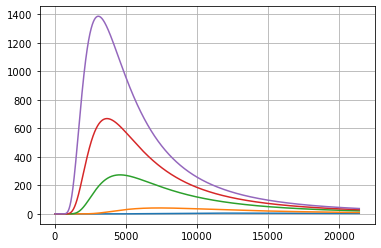

In [124]:
for t_ in [3000,5000,8000,10000,12000]:
    plt.plot(example_spec.wave,black_body(example_spec.wave,t_))
plt.grid()

### Now we define the best fit black body spectrum by fitting it to the data 

In [125]:
def calc_chi2(data,model,error=None):
    
    assert len(data)==len(model)
    
    chi2 = 0.
    for i in range(len(data)):
        if error is not None:
            chi2 = chi2+np.sum((data[i]-model[i])**2./error[i]**2.)
        else:
            chi2 = chi2+np.sum((data[i]-model[i])**2.)
    return chi2
        

In [126]:
def sampler_bb(l,phi_mes,passband,filters_mes,input_funits='photlam',phi_err=None,T=[2000,30000],Tstep=100,verbose=False):
    
    if isinstance(phi_mes,dict):
        data_vec = []
        for filter_ in filters_mes:
            data_vec.append(phi_mes[filter_])
        data_vec = np.array(data_vec)
    else:
        data_vec = phi_mes
    
    if phi_err is not None:
        data_vec_err = []
        for filter_ in filters_mes:
            data_vec_err.append(phi_err[filter_])
        data_vec_err = np.array(data_vec_err)
    else:
        data_vec_err = None
    
    temps = np.arange(T[0],T[-1],Tstep)
    chi2s = []
    for temp_ in temps:
        bb_ = black_body(l,temp_,output_funits=input_funits)
        bb_spec_ = S.ArraySpectrum(l,bb_)
        model_vec_ = []
        for filter_ in filters_mes:
            num_ = int_flux(bb_spec_,passband[filter_],return_error=False,verbose=verbose)
            model_vec_.append(num_)
        model_vec_ = np.array(model_vec_)
        
        chi2_ = calc_chi2(data_vec,model_vec_,error=data_vec_err)
        
        chi2s.append(chi2_)
        
    chi2s = np.array(chi2s)
    
    return temps, chi2s
    

In [127]:
phi_std_dict

{'pickles_uk_104': {'u': 404477186659.83966,
  'g': 3861098844395.599,
  'r': 9875558724140.51,
  'i': 60217523722917.02,
  'z': 188030339506342.66,
  'Y': 271531245787124.34}}

### Now, we compute the best fit black body spectra for the real spectrum passing through 

- the standard atmosphere; 
- the minimum value atmosphere; 
- the maximum value atmosphere. 


In [156]:
T_interval = [15000,50000]
Tstep = 100

In [157]:
filters_b = ['u']
filters_r = ['z','Y']

In [158]:
test_phi = []
for filter_ in filters_r:
    test_phi.append(phi_std_dict[example_id][filter_])
test_phi = np.array(test_phi)

In [159]:
Temps_std, chi2s_std = sampler_bb(wl_baseline,phi_std_dict[example_id],total_passband_ref,filters_r,phi_err=None,T=T_interval,Tstep=Tstep,verbose=False)
print('--------------')

/tmp/ipykernel_210277/2487732627.py:9: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(h_planck*c_light/(l*k_boltzmann*T))-1.


--------------


In [160]:
chi2s_std

array([1.07623348e+29, 1.07607591e+29, 1.07591816e+29, 1.07576023e+29,
       1.07560214e+29, 1.07544389e+29, 1.07528547e+29, 1.07512690e+29,
       1.07496816e+29, 1.07480928e+29, 1.07465025e+29, 1.07449107e+29,
       1.07433175e+29, 1.07417229e+29, 1.07401269e+29, 1.07385295e+29,
       1.07369309e+29, 1.07353309e+29, 1.07337296e+29, 1.07321272e+29,
       1.07305234e+29, 1.07289185e+29, 1.07273124e+29, 1.07257052e+29,
       1.07240968e+29, 1.07224873e+29, 1.07208767e+29, 1.07192650e+29,
       1.07176523e+29, 1.07160386e+29, 1.07144238e+29, 1.07128081e+29,
       1.07111914e+29, 1.07095737e+29, 1.07079551e+29, 1.07063356e+29,
       1.07047151e+29, 1.07030938e+29, 1.07014716e+29, 1.06998486e+29,
       1.06982247e+29, 1.06966000e+29, 1.06949745e+29, 1.06933483e+29,
       1.06917212e+29, 1.06900934e+29, 1.06884648e+29, 1.06868355e+29,
       1.06852054e+29, 1.06835747e+29, 1.06819433e+29, 1.06803112e+29,
       1.06786784e+29, 1.06770449e+29, 1.06754108e+29, 1.06737761e+29,
      

In [161]:
Tfit_std = Temps_std[chi2s_std==np.min(chi2s_std)]
print(np.min(chi2s_std),Tfit_std)

1.0186880636633837e+29 [49900]


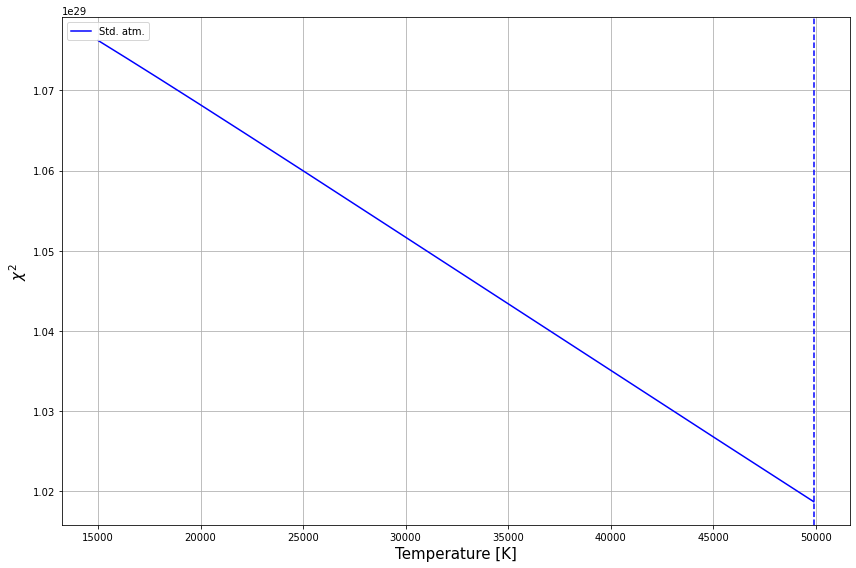

In [162]:
fig=plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

ax.plot(Temps_std,chi2s_std,color='b',label='Std. atm.')
ax.axvline(x=Tfit_std,ls='--',color='b')
ax.grid()
ax.set_xlabel('Temperature [K]',fontsize=15)
ax.set_ylabel(r'$\chi^2$',fontsize=15)
ax.legend(loc="best")
plt.tight_layout()

In [163]:
example_spec.fluxunits

In [164]:
bb_spec_std = black_body(wl_baseline,Tfit_std)

/tmp/ipykernel_210277/2487732627.py:9: RuntimeWarning: overflow encountered in exp
  denominator = np.exp(h_planck*c_light/(l*k_boltzmann*T))-1.


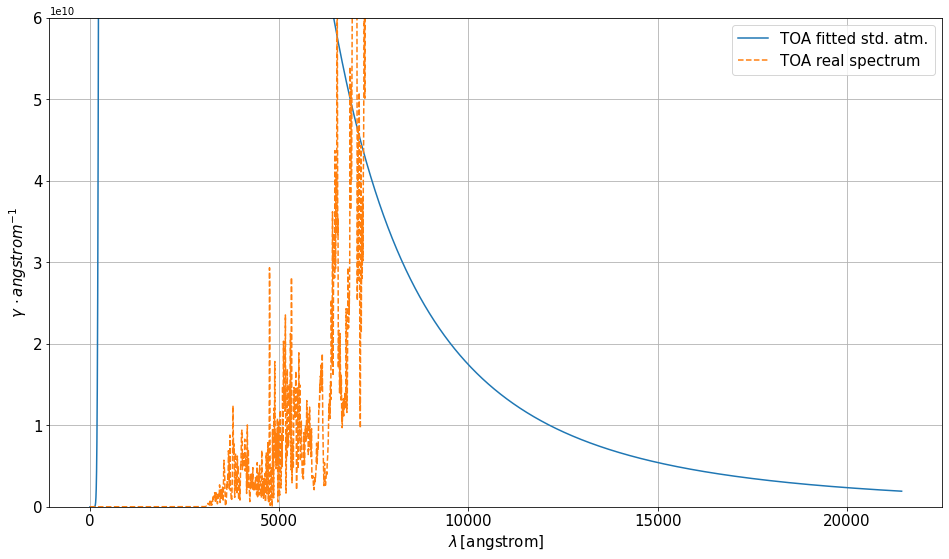

In [165]:
fig=plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)

ax.plot(wl_baseline,bb_spec_std*Seff*exptime,label='TOA fitted std. atm.')
ax.plot(example_spec.wave,example_spec.flux*Seff*exptime,ls='--',label='TOA real spectrum')
#ax.plot(wl_baseline,black_body(wl_baseline,8000)*Seff*exptime)
#ax.set_xlim(WLMIN,WLMAX)
ax.set_ylim(0.,6e10)
ax.grid()
ax.set_xlabel('$\\lambda \, [$'+str(obs.waveunits)+']',fontsize=15)
ax.set_ylabel('$\gamma \, \cdot angstrom^{-1}$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(fontsize=15)


### We compute $\tilde{F}^r(\lambda)$ using the information from the $z$ and $Y$ bands and $\tilde{F}^b(\lambda)$ using the information from the $u$ and $g$

To do this, we compute the reduced matrices $\tilde{M}^r_{\phi}(t)$ and $\tilde{M}^b_{\phi}(t)$ and solve (separately) the systems 

$$\begin{bmatrix} \tilde{\phi}_{z}^0 & \tilde{\phi}_{z}^1 \\ \tilde{\phi}_{Y}^0 & \tilde{\phi}_{Y}^1 \end{bmatrix} \, \begin{bmatrix} \tilde{a}^r_0 \\ \tilde{a}^r_1 \end{bmatrix} = \begin{bmatrix} \varphi_{z} \\ \varphi_{Y} \end{bmatrix} \, , $$ 

and 

$$\begin{bmatrix} \tilde{\phi}_{u}^0 & \tilde{\phi}_{u}^1 \\ \tilde{\phi}_{g}^0 & \tilde{\phi}_{g}^1 \end{bmatrix} \, \begin{bmatrix} \tilde{a}^b_0 \\ \tilde{a}^b_1 \end{bmatrix} = \begin{bmatrix} \varphi_{u} \\ \varphi_{g} \end{bmatrix} \, . $$ 

**NOTE:** this is done for each atm. condition, $t$. 


In [138]:
lin_filters_r = ['i','z','Y'] 
lin_filters_b = ['u','g','r']

In [139]:
# This is done only for checking purposes 
lin_M_phi_std_r = np.zeros((len(lin_filters_r),len(lin_filters_r)))
lin_M_phi_std_b = np.zeros((len(lin_filters_b),len(lin_filters_b)))

for i in range(len(lin_filters_r)):
    for j in range(len(lin_filters_r)):
        b = lin_filters_r[i]
        phi_ij_ = phi_ij(wl_baseline,total_passband_ref[b],j)
        lin_M_phi_std_r[i,j] = phi_ij_
        
for i in range(len(lin_filters_b)):
    for j in range(len(lin_filters_b)):
        b = lin_filters_b[i]
        phi_ij_ = phi_ij(wl_baseline,total_passband_ref[b],j)
        lin_M_phi_std_b[i,j] = phi_ij_

In [140]:
lin_M_phi_t_dict_r = {}
lin_M_phi_t_dict_b = {}

for isim in range(n_sim):
    
    M_phi_t_ = np.zeros((len(lin_filters_r),len(lin_filters_r)))

    for i in range(len(lin_filters_r)):
        for j in range(len(lin_filters_r)):
            b = lin_filters_r[i]
            phi_ij_ = phi_ij(wl_baseline,total_passband[b][isim],j)
            M_phi_t_[i,j] = phi_ij_

    lin_M_phi_t_dict_r[isim] = M_phi_t_
    
    
    M_phi_t_ = np.zeros((len(lin_filters_b),len(lin_filters_b)))

    for i in range(len(lin_filters_b)):
        for j in range(len(lin_filters_b)):
            b = lin_filters_b[i]
            phi_ij_ = phi_ij(wl_baseline,total_passband[b][isim],j)
            M_phi_t_[i,j] = phi_ij_

    lin_M_phi_t_dict_b[isim] = M_phi_t_



In [141]:
lin_M_phi_std_r.shape

(3, 3)

In [142]:
lin_M_phi_t_dict_r[0].shape

(3, 3)

In [143]:
lin_M_phi_inv_std_r = np.linalg.inv(lin_M_phi_std_r)
lin_M_phi_inv_std_b = np.linalg.inv(lin_M_phi_std_b)

lin_M_phi_inv_t_dict_r = {}
lin_M_phi_inv_t_dict_b = {}
for isim in range(n_sim):
    lin_M_phi_inv_t_dict_r[isim] = np.linalg.inv(lin_M_phi_t_dict_r[isim])
    lin_M_phi_inv_t_dict_b[isim] = np.linalg.inv(lin_M_phi_t_dict_b[isim])



In [144]:
lin_M_phi_inv_std_r

array([[ 5.68377860e-09, -1.28680168e-08,  1.08202461e-08],
       [-1.23770351e-12,  3.03582534e-12, -2.69123535e-12],
       [ 6.70811850e-17, -1.75857445e-16,  1.66193794e-16]])

### Compute the coefficients of the linear fits: 

In [145]:
lin_a_vec_std_dict_r = {}
lin_a_vec_std_dict_b = {}
lin_a_vec_t_dict_r = {}
lin_a_vec_t_dict_b = {}

for ised in sed_dict.keys():
    phi_std_ = []
    for filter_ in lin_filters_r:
        phi_std_.append(phi_std_dict[ised][filter_])
    phi_std_ampli_ = np.array(phi_std_)
    
    lin_a_vec_std_dict_r[ised] = np.matmul(lin_M_phi_inv_std_r,phi_std_ampli_)
    
    phi_std_ = []
    for filter_ in lin_filters_b:
        phi_std_.append(phi_std_dict[ised][filter_])
    phi_std_ampli_ = np.array(phi_std_)
    lin_a_vec_std_dict_b[ised] = np.matmul(lin_M_phi_inv_std_b,phi_std_ampli_)
    
    lin_a_vec_t_dict_r[ised] = []
    lin_a_vec_t_dict_b[ised] = []
    for isim in range(n_sim):
        phi_t_ = []
        for filter_ in lin_filters_r:
            phi_t_.append(phi_t_dict[ised][filter_][isim])
        phi_t_ampli_ = np.array(phi_t_)
        
        lin_a_vec_t_dict_r[ised].append(np.matmul(lin_M_phi_inv_t_dict_r[isim],phi_t_ampli_))
        
    lin_a_vec_t_dict_b[ised] = []
    for isim in range(n_sim):
        phi_t_ = []
        for filter_ in lin_filters_b:
            phi_t_.append(phi_t_dict[ised][filter_][isim])
        phi_t_ampli_ = np.array(phi_t_)
        
        lin_a_vec_t_dict_b[ised].append(np.matmul(lin_M_phi_inv_t_dict_b[isim],phi_t_ampli_))
    
    
#print(a_vec_std_dict)

In [146]:
len(lin_a_vec_t_dict_r[example_id][0])

3

In [147]:
lin_a_vec_t_dict_r[example_id],lin_a_vec_t_dict_b[example_id]

([array([-2.34503992e+04,  5.78547734e+00, -2.96196389e-04]),
  array([-2.32027313e+04,  5.72417815e+00, -2.92422659e-04]),
  array([-2.30058498e+04,  5.67551570e+00, -2.89430214e-04]),
  array([-2.28367070e+04,  5.63374120e+00, -2.86862829e-04]),
  array([-2.26862310e+04,  5.59659569e+00, -2.84580763e-04]),
  array([-2.25497906e+04,  5.56292801e+00, -2.82512926e-04]),
  array([-2.24245343e+04,  5.53203035e+00, -2.80615667e-04]),
  array([-2.23085753e+04,  5.50343483e+00, -2.78860159e-04]),
  array([-2.22001564e+04,  5.47670579e+00, -2.77219545e-04])],
 [array([ 4.67198196e+02, -5.35304028e-01,  1.13303663e-04]),
  array([ 4.67159144e+02, -5.35284908e-01,  1.13301363e-04]),
  array([ 4.67121693e+02, -5.35266523e-01,  1.13299146e-04]),
  array([ 4.67085998e+02, -5.35248934e-01,  1.13297015e-04]),
  array([ 4.67052405e+02, -5.35232283e-01,  1.13294986e-04]),
  array([ 4.67063745e+02, -5.35234459e-01,  1.13294817e-04]),
  array([ 4.67200909e+02, -5.35289253e-01,  1.13299834e-04]),
  array

### Evaluate the linear fits 

To do this, we need to evaluate on the range of wavelengths that covers the Euclid's filters 

In [148]:
lin_spec_std_dict_r = {}
lin_spec_std_dict_b = {}
lin_spec_t_dict_r = {}
lin_spec_t_dict_b = {}

for ised in sed_dict.keys():
    #print(len(lin_a_vec_std_dict[ised]))
    lin_spec_std_dict_r[ised] = poly_f(wl_baseline,lin_a_vec_std_dict_r[ised],all_positive=False)
    lin_spec_std_dict_b[ised] = poly_f(wl_baseline,lin_a_vec_std_dict_b[ised],all_positive=False)
    
    lin_spec_t_dict_r[ised] = []
    lin_spec_t_dict_b[ised] = []
    for isim in range(n_sim):
        #print(len(lin_a_vec_t_dict[ised][isim]))
        lin_spec_t_dict_r[ised].append(poly_f(wl_baseline,lin_a_vec_t_dict_r[ised][isim],all_positive=False))
        lin_spec_t_dict_b[ised].append(poly_f(wl_baseline,lin_a_vec_t_dict_b[ised][isim],all_positive=False))
        

In [149]:
lin_a_vec_std_dict_b[example_id]

array([ 4.67121693e+02, -5.35266523e-01,  1.13299146e-04])

In [150]:
lin_spec_std_dict_b[example_id]

array([  466.58653982,   466.0516132 ,   465.51691317, ...,
       41101.90014715, 41106.22484748, 41110.5497744 ])

#### Define linear function for linear fits: 

We manually set to 0 the negative values that may arise from this function. This is done specially for the blue part of the spectrum, since given the low transmission of the filter $u$, the fitted linear function may be very steep for red objects 


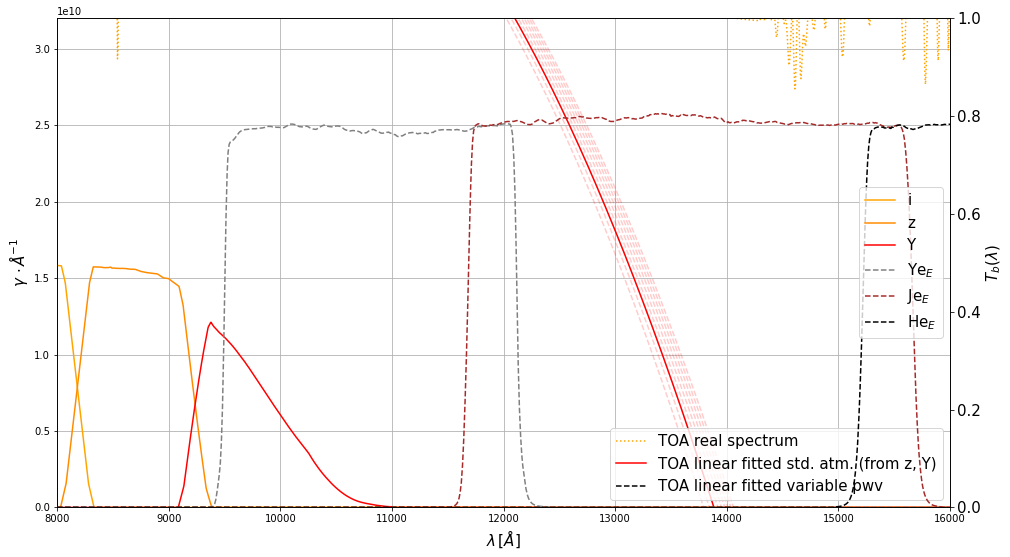

In [151]:
fig=plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)

ax.plot(sed_dict[example_id].wave,sed_dict[example_id].flux*Seff*exptime,ls=':',color='orange',label='TOA real spectrum')
ax.plot(wl_baseline,lin_spec_std_dict_r[example_id]*Seff*exptime,ls='-',color='r',label='TOA linear fitted std. atm. (from z, Y)')
for isim in range(n_sim):
    ax.plot(wl_baseline,lin_spec_t_dict_r[example_id][isim]*Seff*exptime,ls='--',color='r',alpha=0.2)
ax.plot([],[],ls='--',color='k',label='TOA linear fitted variable {0}'.format(variable_param))

#ax.set_xlim(WLMIN,WLMAX)
ax.set_xlim(8000.,16000.)
ax.set_ylim(0.,3.2e10)
ax.grid()

ax2 = ax.twinx()
for i,filter_ in enumerate(lin_filters_r):
    j = len(filters)-len(lin_filters_r)+i
    ax2.plot(lsst_bp[j].wave,lsst_bp[j].throughput,label=filter_names[j],color=filter_colors[j])

for i,filter_ in enumerate(eu_filters):
    ax2.plot(euclid_bp[i].wave,euclid_bp[i].throughput,ls='--',color=eu_colors[filter_],label=filter_+r'$_E$')

ax2.set_ylim(0.,1.)

ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
ax2.set_ylabel(r'$T_b(\lambda)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(loc="lower right",fontsize=15)
ax2.legend(loc="center right",fontsize=15)


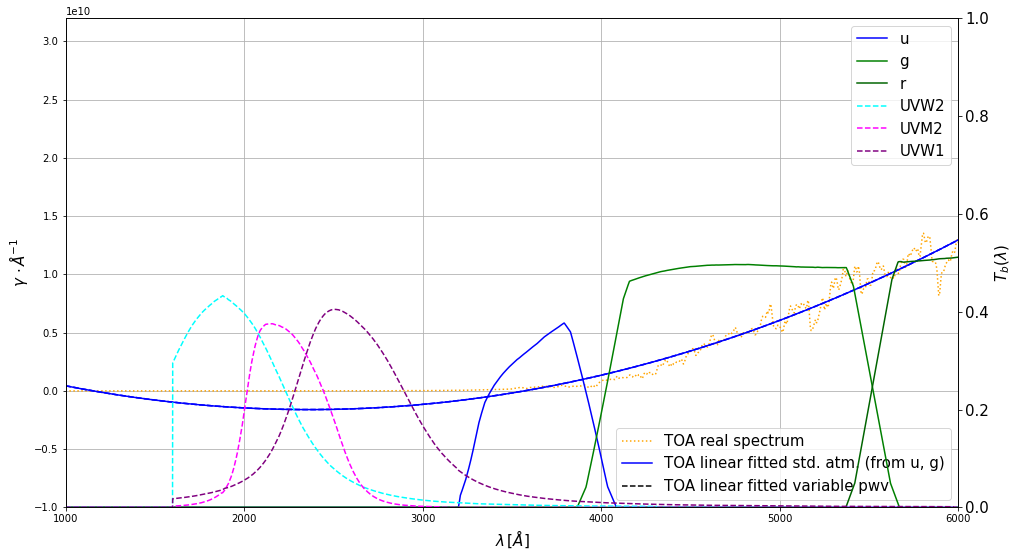

In [152]:
fig=plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)

ax.plot(sed_dict[example_id].wave,sed_dict[example_id].flux*Seff*exptime,ls=':',color='orange',label='TOA real spectrum')
ax.plot(wl_baseline,lin_spec_std_dict_b[example_id]*Seff*exptime,ls='-',color='b',label='TOA linear fitted std. atm. (from u, g)')
for isim in range(n_sim):
    ax.plot(wl_baseline,lin_spec_t_dict_b[example_id][isim]*Seff*exptime,ls='--',color='b',alpha=0.2)
ax.plot([],[],ls='--',color='k',label='TOA linear fitted variable {0}'.format(variable_param))

#ax.set_xlim(WLMIN,WLMAX)
ax.set_xlim(1000.,6000.)
ax.set_ylim(-1e10,3.2e10)
ax.grid()

ax2 = ax.twinx()

for i,filter_ in enumerate(lin_filters_b):
    ax2.plot(lsst_bp[i].wave,lsst_bp[i].throughput,label=filter_names[i],color=filter_colors[i])

for i,filter_ in enumerate(swift_filters):
    ax2.plot(swift_bp[i].wave,swift_bp[i].throughput,ls='--',color=swift_colors[filter_],label=filter_)

ax2.set_ylim(0.,1.)

ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
ax2.set_ylabel(r'$T_b(\lambda)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(loc="lower right",fontsize=15)
ax2.legend(loc="upper right",fontsize=15)


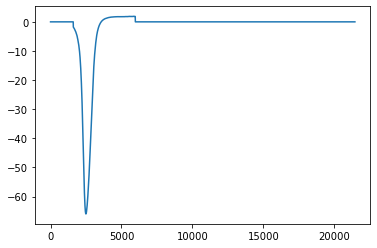

In [153]:
plt.plot(wl_baseline,lin_spec_std_dict_b[example_id]*swift_bp[2].throughput)

In [154]:
for i in range(len(swift_filters)):
    print(swift_filters[i],(lin_spec_std_dict_b[example_id]*swift_bp[i].throughput>0.).any())

UVW2 True
UVM2 False
UVW1 True


In [155]:
np.trapz(lin_spec_std_dict_b[example_id]*swift_bp[2].throughput,x=wl_baseline)

-42295.54317326329

Warning, 2414 of 21449 bins contained negative fluxes; they have been set to zero.


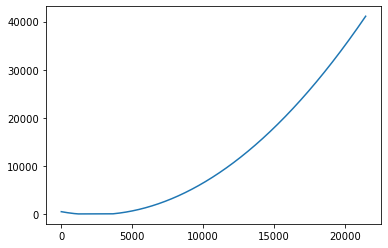

In [156]:
cosa = S.ArraySpectrum(wl_baseline,lin_spec_std_dict_b[example_id])
cosa.convert('photlam')
plt.plot(cosa.wave,cosa.flux)

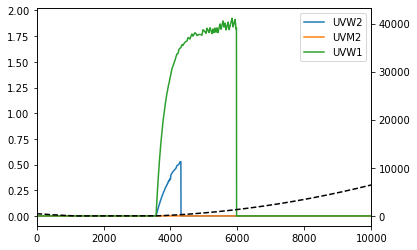

In [157]:
fig = plt.figure()
ax = fig.add_subplot(111)
for i,sw_ in enumerate(swift_bp):
    obs_cosa = S.Observation(cosa,sw_)
    ax.plot(obs_cosa.wave,obs_cosa.flux,label=swift_filters[i])
ax.set_xlim(0,10000)
ax.legend()

ax2 = ax.twinx()
ax2.plot(cosa.wave,cosa.flux,ls='--',color='k')

array([-2, -1,  0,  1,  2])

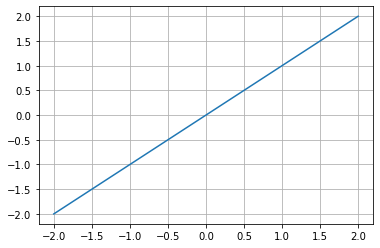

In [158]:
def ffun(x):
    return x
xx = np.arange(-2,3)
plt.plot(xx,ffun(xx))
plt.grid()
xx

In [159]:
np.trapz(ffun(xx),x=xx),np.trapz(ffun(xx[:3]),x=xx[:3]),np.trapz(ffun(xx[2:]),x=xx[2:])

(0.0, -2.0, 2.0)

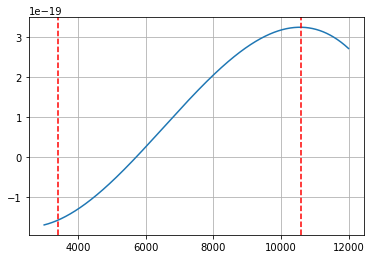

In [160]:
plt.plot(np.arange(wl[0],12000.),poly_f(np.arange(wl[0],12000.),lin_a_vec_std_dict_r[example_id],output_funits='fnu'))
plt.axvline(x=WLMIN,ls='--',color='r')
plt.axvline(x=WLMAX,ls='--',color='r')
plt.grid()

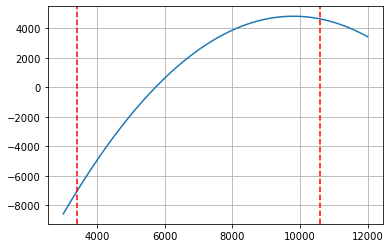

In [161]:
plt.plot(np.arange(wl[0],12000.),poly_f(np.arange(wl[0],12000.),lin_a_vec_std_dict_r[example_id],output_funits='photlam'))
plt.axvline(x=WLMIN,ls='--',color='r')
plt.axvline(x=WLMAX,ls='--',color='r')
plt.grid()

### Set the linear spectra in pysynphot format 

In [162]:
lin_dict_r = {}
lin_dict_b = {}

for ised in sed_dict.keys():
    lin_dict_r[ised] = {}
    lin0_ = S.ArraySpectrum(wl_baseline,lin_spec_std_dict_r[ised])
    lin_dict_r[ised]['std'] = lin0_
    
    lin_dict_b[ised] = {}
    lin0_ = S.ArraySpectrum(wl_baseline,lin_spec_std_dict_b[ised])
    lin_dict_b[ised]['std'] = lin0_
    
    for isim in range(n_sim):
        lin0_ = S.ArraySpectrum(wl_baseline,lin_spec_t_dict_r[ised][isim])
        lin_dict_r[ised][isim] = lin0_
        
        lin0_ = S.ArraySpectrum(wl_baseline,lin_spec_t_dict_b[ised][isim])
        lin_dict_b[ised][isim] = lin0_
        
    

Warning, 13289 of 21449 bins contained negative fluxes; they have been set to zero.
Warning, 13397 of 21449 bins contained negative fluxes; they have been set to zero.
Warning, 2414 of 21449 bins contained negative fluxes; they have been set to zero.
Warning, 13337 of 21449 bins contained negative fluxes; they have been set to zero.
Warning, 2414 of 21449 bins contained negative fluxes; they have been set to zero.
Warning, 13289 of 21449 bins contained negative fluxes; they have been set to zero.
Warning, 2414 of 21449 bins contained negative fluxes; they have been set to zero.
Warning, 13247 of 21449 bins contained negative fluxes; they have been set to zero.
Warning, 2414 of 21449 bins contained negative fluxes; they have been set to zero.
Warning, 13210 of 21449 bins contained negative fluxes; they have been set to zero.
Warning, 2415 of 21449 bins contained negative fluxes; they have been set to zero.
Warning, 13175 of 21449 bins contained negative fluxes; they have been set to zer

In [163]:
example_id

'pickles_uk_131'

In [164]:
phi_std_dict[example_id]['Y']/Seff/exptime

1264389.0884283462

In [165]:
int_flux(sed_dict[example_id],total_passband_ref['Y'])/Seff/exptime

1264389.0884283462

In [166]:
int_flux(lin_dict_r[example_id]['std'],total_passband_ref['Y'])/Seff/exptime

1264389.0884283604

### Make the linear spectra pass through the current atmosphere they were fitted from 

Here, we are making each $\tilde{F}_t(\lambda)$ pass through the corresponding current atmosphere, $T_b(\lambda;t)$ they are fitted from. 

In [167]:

obs_lin_std_dict_r = {}
obs_lin_t_dict_r = {}

obs_lin_std_dict_b = {}
obs_lin_t_dict_b = {}

for ised in sed_dict.keys():
    obs_lin_std_dict_r[ised] = {}
    obs_lin_t_dict_r[ised] = {}
    
    obs_lin_std_dict_b[ised] = {}
    obs_lin_t_dict_b[ised] = {}
    for filter_ in filters:
        lin_total_ = S.Observation(lin_dict_r[ised]['std'],total_passband_ref[filter_],force='taper')
        obs_lin_std_dict_r[ised][filter_] = lin_total_
        
        lin_total_ = S.Observation(lin_dict_b[ised]['std'],total_passband_ref[filter_],force='taper')
        obs_lin_std_dict_b[ised][filter_] = lin_total_
        
        obs_lin_t_dict_r[ised][filter_] = []
        obs_lin_t_dict_b[ised][filter_] = []
        for isim in range(n_sim):
            lin_total_ = S.Observation(lin_dict_r[ised][isim],total_passband[filter_][isim],force='taper')
            obs_lin_t_dict_r[ised][filter_].append(lin_total_)
            
            lin_total_ = S.Observation(lin_dict_b[ised][isim],total_passband[filter_][isim],force='taper')
            obs_lin_t_dict_b[ised][filter_].append(lin_total_)
            
    

### Make the linear spectra pass through the standard atmosphere 

Here, we are making each $\tilde{F}^r_t(\lambda)$ pass through the standard atmosphere, $T_b^{std}(\lambda)$.   

In [168]:
std_lin_t_dict_r = {}
std_lin_t_dict_b = {}

for ised in sed_dict.keys():
    
    std_lin_t_dict_r[ised] = {}
    std_lin_t_dict_b[ised] = {}
    
    for filter in filters:
        std_lin_t_dict_r[ised][filter] = []
        std_lin_t_dict_b[ised][filter] = []
        for isim in range(n_sim):
            lin_cross_ = S.Observation(lin_dict_r[ised][isim],total_passband_ref[filter],force='taper')
            std_lin_t_dict_r[ised][filter].append(lin_cross_)
            
            lin_cross_ = S.Observation(lin_dict_b[ised][isim],total_passband_ref[filter],force='taper')
            std_lin_t_dict_b[ised][filter].append(lin_cross_)
        
    

### Make the linear spectra pass through the Euclid's filters 

Here, we are making each $\tilde{F}^r_t(\lambda)$ pass through the Euclid's passband, $T_{J_E}(\lambda)$.  

In [169]:
eu_lin_t_dict = {}

for ised in sed_dict.keys():
    
    eu_lin_t_dict[ised] = {}
    
    for i,filter_ in enumerate(eu_filters):
        eu_lin_t_dict[ised][filter_] = []
        for isim in range(n_sim):
            lin_cross_ = S.Observation(lin_dict_r[ised][isim],euclid_bp[i],force='taper')
            eu_lin_t_dict[ised][filter_].append(lin_cross_)
        

In [170]:
eu_lin_t_dict[example_id]['Je'][ref_ind_].binflux

array([0., 0., 0., ..., 0., 0., 0.])

### Make the linear spectra pass through the SWIFT's filters 

Here, we are making each $\tilde{F}^b_t(\lambda)$ pass through the SWIFT's passband, $T_{UVM2}(\lambda)$.  

In [171]:
swift_lin_t_dict = {}

for ised in sed_dict.keys():
    
    swift_lin_t_dict[ised] = {}
    
    for i,filter_ in enumerate(swift_filters):
        swift_lin_t_dict[ised][filter_] = []
        for isim in range(n_sim):
            lin_cross_ = S.Observation(lin_dict_b[ised][isim],swift_bp[i],force='taper')
            swift_lin_t_dict[ised][filter_].append(lin_cross_)
        

#### Plot linear spectra fitted from the red end 

u
g
r
i
z
Y
Ye
Je
He
photlam


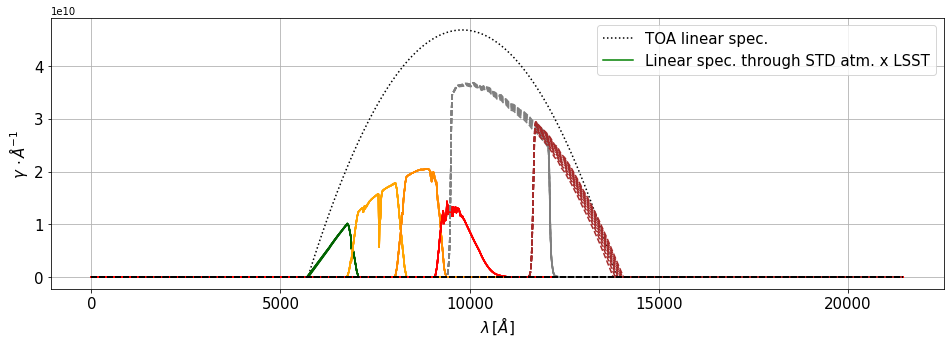

In [172]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)

ax.plot(lin_dict_r[example_id][ref_ind_].wave,lin_dict_r[example_id][ref_ind_].flux*Seff*exptime,ls=':',color='k',alpha=1.0)

for index,filter_ in enumerate(filters):
    print(filter_)
    for isim in range(n_sim):
        obs = std_lin_t_dict_r[example_id][filter_][isim]
        ax.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=1.0)
    
for index,filter_ in enumerate(eu_filters):
    print(filter_)
    for isim in range(n_sim):
        obs = eu_lin_t_dict[example_id][filter_][isim]
        ax.plot(obs.binwave,obs.binflux*Seff*exptime,ls='--',color=eu_colors[filter_],alpha=1.0)

#ax.set_xlim(WLMIN,WLMAX)
#ax.set_ylim(0.,0.5e13)
ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
ax.grid()
ax.plot([],[],ls=':',color='k',label='TOA linear spec.')
ax.plot([],[],ls='-',color='g',label='Linear spec. through STD atm. x LSST')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(fontsize=15)
print(spec.fluxunits)

u
g
r
i
z
Y
photlam


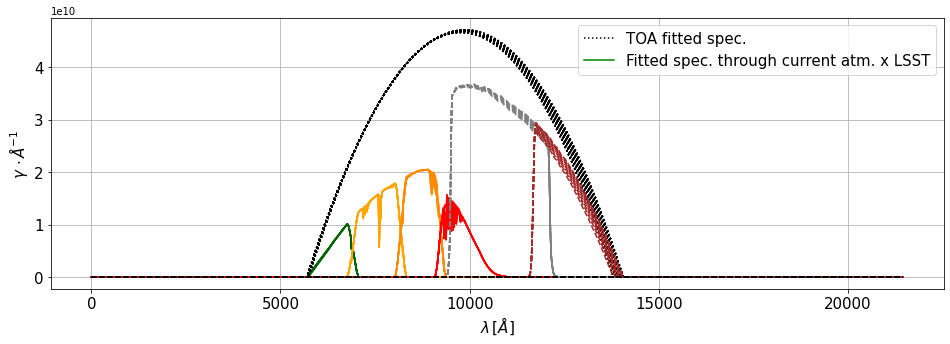

In [173]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)

for index,filter_ in enumerate(filters):
    print(filter_)
    for isim in range(n_sim):
        ax.plot(lin_dict_r[example_id][isim].wave,lin_dict_r[example_id][isim].flux*Seff*exptime,ls=':',color='k',alpha=1.0)
        obs = obs_lin_t_dict_r[example_id][filter_][isim]
        ax.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=1.0)
        
for index,filter_ in enumerate(eu_filters):
    for isim in range(n_sim):
        obs = eu_lin_t_dict[example_id][filter_][isim]
        ax.plot(obs.binwave,obs.binflux*Seff*exptime,ls='--',color=eu_colors[filter_],alpha=1.0)

#ax.set_xlim(WLMIN,WLMAX)
#ax.set_xlim(9000,11000)
#ax.set_ylim(0.,0.2e10)
ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
ax.grid()
ax.plot([],[],ls=':',color='k',label='TOA fitted spec.')
ax.plot([],[],ls='-',color='g',label='Fitted spec. through current atm. x LSST')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(fontsize=15)
print(spec.fluxunits)

#### Plot linear spectra fitter from the blue end 

u
g
r
i
z
Y
photlam


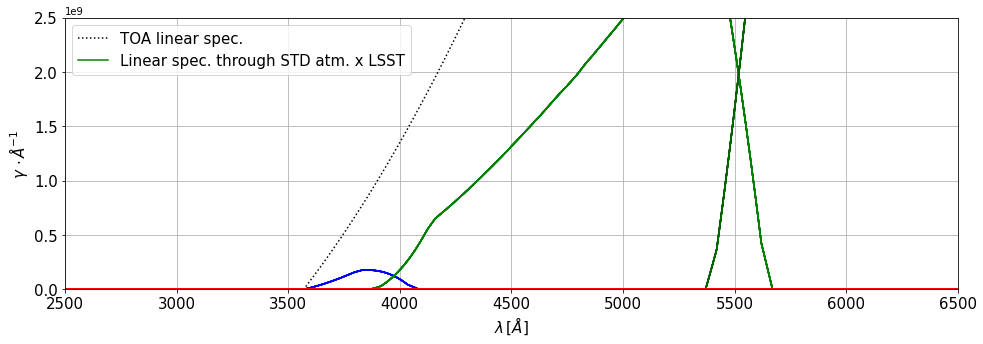

In [174]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)

ax.plot(lin_dict_b[example_id][ref_ind_].wave,lin_dict_b[example_id][ref_ind_].flux*Seff*exptime,ls=':',color='k',alpha=1.0)

for index,filter_ in enumerate(filters):
    print(filter_)
    for isim in range(n_sim):
        obs = std_lin_t_dict_b[example_id][filter_][isim]
        ax.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=1.0)
'''    
for index,filter_ in enumerate(swift_filters):
    print(filter_)
    for isim in range(n_sim):
        obs = swift_lin_t_dict[example_id][filter_][isim]
        ax.plot(obs.binwave,obs.binflux*Seff*exptime,ls='--',color=swift_colors[filter_],alpha=1.0)
'''
ax.set_xlim(2500.,6500.)
ax.set_ylim(0.,0.25e10)
ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
ax.grid()
ax.plot([],[],ls=':',color='k',label='TOA linear spec.')
ax.plot([],[],ls='-',color='g',label='Linear spec. through STD atm. x LSST')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(fontsize=15)
print(spec.fluxunits)

u
g
r


KeyboardInterrupt: 

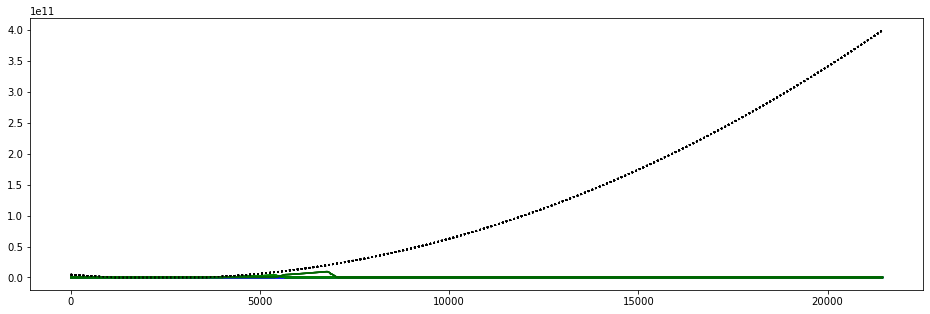

In [175]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)

for index,filter_ in enumerate(filters):
    print(filter_)
    for isim in range(n_sim):
        ax.plot(lin_dict_b[example_id][isim].wave,lin_dict_b[example_id][isim].flux*Seff*exptime,ls=':',color='k',alpha=1.0)
        obs = obs_lin_t_dict_b[example_id][filter_][isim]
        ax.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=1.0)
        
for index,filter_ in enumerate(swift_filters):
    for isim in range(n_sim):
        obs = swift_lin_t_dict[example_id][filter_][isim]
        ax.plot(obs.binwave,obs.binflux*Seff*exptime,ls='--',color=swift_colors[filter_],alpha=1.0)

#ax.set_xlim(WLMIN,WLMAX)
ax.set_xlim(2500.,6500.)
#ax.set_ylim(0.,0.2e10)
ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
ax.grid()
ax.plot([],[],ls=':',color='k',label='TOA fitted spec.')
ax.plot([],[],ls='-',color='g',label='Fitted spec. through current atm. x LSST')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(fontsize=15)
print(spec.fluxunits)

### Calculate integrated fluxes and magnitudes from linear spectra through corresponding current atmosphere 

In [ ]:
lin_Phi_t_dict_r = {}
lin_Mag_t_dict_r = {}
lin_Phi_t_dict_b = {}
lin_Mag_t_dict_b = {}

for ised in sed_dict.keys():
    lin_Phi_t_dict_r[ised] = {}
    lin_Mag_t_dict_r[ised] = {}
    lin_Phi_t_dict_b[ised] = {}
    lin_Mag_t_dict_b[ised] = {}
    for index,filter_ in enumerate(filters):
        lin_Phi_t_dict_r[ised][filter_] = []
        lin_Mag_t_dict_r[ised][filter_] = []
        lin_Phi_t_dict_b[ised][filter_] = []
        lin_Mag_t_dict_b[ised][filter_] = []
        for isim in range(n_sim):
            num_,mag_ = int_flux(lin_dict_r[ised][isim],total_passband[filter_][isim],return_mag=True,PhiAB=Phi_AB[index])
            lin_Phi_t_dict_r[ised][filter_].append(num_)
            lin_Mag_t_dict_r[ised][filter_].append(mag_)
            
            num_,mag_ = int_flux(lin_dict_b[ised][isim],total_passband[filter_][isim],return_mag=True,PhiAB=Phi_AB[index])
            lin_Phi_t_dict_b[ised][filter_].append(num_)
            lin_Mag_t_dict_b[ised][filter_].append(mag_)
        
    
    

### Calculate integrated fluxes and magnitudes from linear spectra through standard atmosphere 

In [ ]:
lin_Phi_std_dict_r = {}
lin_Mag_std_dict_r = {}
lin_Phi_std_dict_b = {}
lin_Mag_std_dict_b = {}

for ised in sed_dict.keys():
    lin_Phi_std_dict_r[ised] = {}
    lin_Mag_std_dict_r[ised] = {}
    lin_Phi_std_dict_b[ised] = {}
    lin_Mag_std_dict_b[ised] = {}
    for index,filter_ in enumerate(filters):
        lin_Phi_std_dict_r[ised][filter_] = []
        lin_Mag_std_dict_r[ised][filter_] = []
        lin_Phi_std_dict_b[ised][filter_] = []
        lin_Mag_std_dict_b[ised][filter_] = []
        for isim in range(n_sim):
            num_,mag_ = int_flux(lin_dict_r[ised][isim],total_passband_ref[filter_],return_mag=True,PhiAB=Phi_AB[index])
            lin_Phi_std_dict_r[ised][filter_].append(num_)
            lin_Mag_std_dict_r[ised][filter_].append(mag_)
            num_,mag_ = int_flux(lin_dict_b[ised][isim],total_passband_ref[filter_],return_mag=True,PhiAB=Phi_AB[index])
            lin_Phi_std_dict_b[ised][filter_].append(num_)
            lin_Mag_std_dict_b[ised][filter_].append(mag_)
        
    

### Calculate integrated fluxes and magnitudes from linear spectra through Euclid's filters 

In [ ]:
lin_Phi_eu_dict = {}
lin_Mag_eu_dict = {}

for ised in sed_dict.keys():
    lin_Phi_eu_dict[ised] = {}
    lin_Mag_eu_dict[ised] = {}
    for index,filter_ in enumerate(eu_filters):
        lin_Phi_eu_dict[ised][filter_] = []
        lin_Mag_eu_dict[ised][filter_] = []
        for isim in range(n_sim):
            num_,mag_ = int_flux(lin_dict_r[ised][isim],euclid_bp[index],return_mag=True,PhiAB=Phi_AB[index])
            lin_Phi_eu_dict[ised][filter_].append(num_)
            lin_Mag_eu_dict[ised][filter_].append(mag_)
        
    
    

### Calculate integrated fluxes and magnitudes from linear spectra through SWIFT's filters 

In [ ]:
lin_Phi_swift_dict = {}
lin_Mag_swift_dict = {}

for ised in sed_dict.keys():
    lin_Phi_swift_dict[ised] = {}
    lin_Mag_swift_dict[ised] = {}
    for index,filter_ in enumerate(swift_filters):
        lin_Phi_swift_dict[ised][filter_] = []
        lin_Mag_swift_dict[ised][filter_] = []
        for isim in range(n_sim):
            num_,mag_ = int_flux(lin_dict_b[ised][isim],swift_bp[index],return_mag=True,PhiAB=Phi_AB[index])
            lin_Phi_swift_dict[ised][filter_].append(num_)
            lin_Mag_swift_dict[ised][filter_].append(mag_)
        
    

### Comparison plots with respect to **standard (reference) atmosphere** (NOTE: only plotting $\tilde{F}_t(\lambda)$ from standard atmosphere) 

In [ ]:
fig=plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111)

ax1.plot(sed_dict[example_id].wave,sed_dict[example_id].flux*Seff*exptime,ls='--',color='orange',alpha=1.0)
ax1.plot(lin_dict_r[example_id]['std'].wave,lin_dict_r[example_id]['std'].flux*Seff*exptime,ls=':',color='k',alpha=1.0)

ax2 = ax1.twinx()
    
#ax1.set_xlim(WLMIN,WLMAX)
#ax1.set_ylim(0.,1.75e10)
#ax2.set_ylim(0,7.5e12)
ax1.plot([],[],ls='--',color='k',label='Real spectrum')
ax1.plot([],[],ls=':',color='k',label='Fitted spectrum')
ax1.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax1.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
ax1.grid()

for index,filter_ in enumerate(filters):
    ax2.scatter(eff_lambda[filter_],phi_std_dict[example_id][filter_],marker='o',color=filter_colors[index])
    ax2.scatter(eff_lambda[filter_]+100.,lin_Phi_std_dict_r[example_id][filter_][ref_ind_],marker='s',color=filter_colors[index])

for index,filter_ in enumerate(eu_filters):
    ax2.scatter(eu_eff_lambda[filter_],phi_eu_dict[example_id][filter_],marker='o',color=eu_colors[filter_])
    ax2.scatter(eu_eff_lambda[filter_]+100.,lin_Phi_eu_dict[example_id][filter_][ref_ind_],marker='s',color=eu_colors[filter_])

ax2.plot([],[],ls='',marker='o',color='k',label=r'$\varphi^{std}_i$')
ax2.plot([],[],ls='',marker='s',color='k',label=r'$\Phi^{std}_i$')
ax2.set_ylabel(r'$\varphi$',fontsize=15)
ax1.legend(fontsize=15)
ax2.legend(fontsize=20,loc='lower right')
plt.tight_layout()
print(spec.fluxunits)

In [ ]:
fig=plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111)

ax1.plot(sed_dict[example_id].wave,sed_dict[example_id].flux*Seff*exptime,ls='--',color='orange',alpha=1.0)
ax1.plot(lin_dict_b[example_id]['std'].wave,lin_dict_b[example_id]['std'].flux*Seff*exptime,ls=':',color='k',alpha=1.0)

ax2 = ax1.twinx()
    
#ax1.set_xlim(WLMIN,WLMAX)
#ax1.set_ylim(0.,1.75e10)
#ax2.set_ylim(0,7.5e12)
ax1.plot([],[],ls='--',color='k',label='Real spectrum')
ax1.plot([],[],ls=':',color='k',label='Fitted spectrum')
ax1.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax1.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
ax1.grid()

for index,filter_ in enumerate(filters):
    ax2.scatter(eff_lambda[filter_],phi_std_dict[example_id][filter_],marker='o',color=filter_colors[index])
    ax2.scatter(eff_lambda[filter_]+100.,lin_Phi_std_dict_b[example_id][filter_][ref_ind_],marker='s',color=filter_colors[index])

for index,filter_ in enumerate(swift_filters):
    ax2.scatter(swift_eff_lambda[filter_],phi_swift_dict[example_id][filter_],marker='o',color=swift_colors[filter_])
    ax2.scatter(swift_eff_lambda[filter_]+100.,lin_Phi_swift_dict[example_id][filter_][ref_ind_],marker='s',color=swift_colors[filter_])

ax2.plot([],[],ls='',marker='o',color='k',label=r'$\varphi^{std}_i$')
ax2.plot([],[],ls='',marker='s',color='k',label=r'$\Phi^{std}_i$')
ax2.set_ylabel(r'$\varphi$',fontsize=15)
ax1.legend(fontsize=15)
ax2.legend(fontsize=20,loc='lower right')
plt.tight_layout()
print(spec.fluxunits)

In [ ]:
phi_std_dict[example_id]['u']

In [ ]:
lin_Phi_std_dict_b[example_id]['u'][ref_ind_]

In [ ]:
(lin_Phi_std_dict_b[example_id]['u'][ref_ind_]-phi_std_dict[example_id]['u'])*100./phi_std_dict[example_id]['u']

In [ ]:
(lin_Phi_std_dict_r[example_id]['Y'][ref_ind_]-phi_std_dict[example_id]['Y'])*100./phi_std_dict[example_id]['Y']

### And now we compare with the integrated fluxes from the real spectrum for each atmospheric situation 

In [ ]:
phi_eu_dict[example_id],phi_swift_dict[example_id]

In [ ]:
fig=plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111)

ax1.plot(sed_dict[example_id].wave,example_spec.flux*Seff*exptime,ls='--',color='orange',alpha=1.0)
ax1.plot(lin_dict_r[example_id]['std'].wave,lin_dict_r[example_id]['std'].flux*Seff*exptime,ls=':',color='k',alpha=1.0)
for isim in range(n_sim):
    ax1.plot(lin_dict_r[example_id]['std'].wave,lin_dict_r[example_id][isim].flux*Seff*exptime,ls=':',color='k',alpha=0.5)

ax2 = ax1.twinx()
    
#ax1.set_xlim(WLMIN,WLMAX)
#ax1.set_xlim(10000,12000)
#ax1.set_ylim(1.387e10,1.389e10)
#ax2.set_ylim(0,7.5e12)
ax1.plot([],[],ls='--',color='k',label='Real spectrum')
ax1.plot([],[],ls=':',color='k',label='Fitted spectrum')
ax1.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax1.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
ax1.grid()

for index,filter_ in enumerate(filters):
    ax2.scatter(eff_lambda[filter_],phi_std_dict[example_id][filter_],marker='o',color=filter_colors[index])
    ax2.scatter(eff_lambda[filter_]+100.,lin_Phi_std_dict_r[example_id][filter_][ref_ind_],marker='s',color=filter_colors[index])
    for isim in range(n_sim):
        ax2.scatter(eff_lambda[filter_],phi_t_dict[example_id][filter_][isim],marker='x',color=filter_colors[index])
        ax2.scatter(eff_lambda[filter_]+100.,lin_Phi_t_dict_r[example_id][filter_][isim],marker='+',color=filter_colors[index])
    
for index,filter_ in enumerate(eu_filters):
    ax2.scatter(eu_eff_lambda[filter_],phi_eu_dict[example_id][filter_],marker='o',color=eu_colors[filter_])
    ax2.scatter(eu_eff_lambda[filter_]+100.,lin_Phi_eu_dict[example_id][filter_][ref_ind_],marker='s',color=eu_colors[filter_])
    for isim in range(n_sim):
        ax2.scatter(eu_eff_lambda[filter_]+100.,lin_Phi_eu_dict[example_id][filter_][isim],marker='+',color=eu_colors[filter_])

ax2.plot([],[],ls='',marker='o',color='k',label=r'$\varphi^{std}_i$')
ax2.plot([],[],ls='',marker='x',color='k',label=r'$\varphi_i($'+'{0})'.format(variable_param))
ax2.plot([],[],ls='',marker='s',color='k',label=r'$\Phi^{std}_i$')
ax2.plot([],[],ls='',marker='+',color='k',label=r'$\Phi_i($'+'{0})'.format(variable_param))
#ax2.set_yscale("log")
ax2.set_ylabel(r'$\varphi$',fontsize=15)
ax1.legend(fontsize=20)
ax2.legend(fontsize=20,loc='lower right')
plt.tight_layout()
print(spec.fluxunits)

In [ ]:
fig=plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111)

ax1.plot(sed_dict[example_id].wave,example_spec.flux*Seff*exptime,ls='--',color='orange',alpha=1.0)
ax1.plot(lin_dict_b[example_id]['std'].wave,lin_dict_b[example_id]['std'].flux*Seff*exptime,ls=':',color='k',alpha=1.0)
for isim in range(n_sim):
    ax1.plot(lin_dict_b[example_id]['std'].wave,lin_dict_b[example_id][isim].flux*Seff*exptime,ls=':',color='k',alpha=0.5)

ax2 = ax1.twinx()
    
#ax1.set_xlim(WLMIN,WLMAX)
#ax1.set_xlim(10000,12000)
#ax1.set_ylim(1.387e10,1.389e10)
#ax2.set_ylim(0,7.5e12)
ax1.plot([],[],ls='--',color='k',label='Real spectrum')
ax1.plot([],[],ls=':',color='k',label='Fitted spectrum')
ax1.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax1.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
ax1.grid()

for index,filter_ in enumerate(filters):
    ax2.scatter(eff_lambda[filter_],phi_std_dict[example_id][filter_],marker='o',color=filter_colors[index])
    ax2.scatter(eff_lambda[filter_]+100.,lin_Phi_std_dict_b[example_id][filter_][ref_ind_],marker='s',color=filter_colors[index])
    for isim in range(n_sim):
        ax2.scatter(eff_lambda[filter_],phi_t_dict[example_id][filter_][isim],marker='x',color=filter_colors[index])
        ax2.scatter(eff_lambda[filter_]+100.,lin_Phi_t_dict_b[example_id][filter_][isim],marker='+',color=filter_colors[index])
    
for index,filter_ in enumerate(swift_filters):
    ax2.scatter(swift_eff_lambda[filter_],phi_swift_dict[example_id][filter_],marker='o',color=swift_colors[filter_])
    ax2.scatter(swift_eff_lambda[filter_]+100.,lin_Phi_swift_dict[example_id][filter_][ref_ind_],marker='s',color=swift_colors[filter_])
    for isim in range(n_sim):
        ax2.scatter(swift_eff_lambda[filter_]+100.,lin_Phi_swift_dict[example_id][filter_][isim],marker='+',color=swift_colors[filter_])

ax2.plot([],[],ls='',marker='o',color='k',label=r'$\varphi^{std}_i$')
ax2.plot([],[],ls='',marker='x',color='k',label=r'$\varphi_i($'+'{0})'.format(variable_param))
ax2.plot([],[],ls='',marker='s',color='k',label=r'$\Phi^{std}_i$')
ax2.plot([],[],ls='',marker='+',color='k',label=r'$\Phi_i($'+'{0})'.format(variable_param))
#ax2.set_yscale("log")
ax2.set_ylabel(r'$\varphi$',fontsize=15)
ax1.legend(fontsize=20)
ax2.legend(fontsize=20,loc='lower right')
plt.tight_layout()
print(spec.fluxunits)

In [ ]:
phi_swift_dict[example_id],lin_Phi_swift_dict[example_id]

### Now, we compute $\hat{F}_t(\lambda)$ by solving the full system which includes estimations from Euclid and SWIFT 

In [ ]:
use_delta_wl = False
use_euclid = False
use_swift = True
eu_use = ['He']
swift_use = ['UVM2']
if use_euclid==False:
    eu_use = []
if use_swift==False:
    swift_use = []

In [ ]:
euclid_bp,swift_bp

In [ ]:
eff_lambda

In [ ]:
eu_eff_lambda,swift_eff_lambda

## Estimation of spectra by piecewise linear fitting 

In this case, we consider the estimated spectrum to be described by a piecewise linear function of the following form: 

$$\hat{F}(\lambda) = \begin{cases} 
      \hat{F}_0(\lambda) = a_0 \lambda & \lambda < \lambda_u \\
      \hat{F}_u(\lambda) = a_u (\lambda - \lambda_u) + a_0 \lambda_u & \lambda_u \leq \lambda < \lambda_g \\
      \hat{F}_g(\lambda) = a_g (\lambda - \lambda_g) + a_0 \lambda_u + a_u (\lambda_g - \lambda_u) & \lambda_g \leq \lambda < \lambda_r \\ 
      \qquad \qquad \qquad \vdots
   \end{cases} \, . $$ 

This can be summarized as 

$$\hat{F}_R(\lambda) = a_R (\lambda - \lambda_R) + \sum_{r=0}^{R-1} a_{r} (\lambda_{r+1} - \lambda_r) = a_R (\lambda - \lambda_R) + S_{R-1} \, , $$ 

where $R = \{0,u,g,r,i,z,Y\}$. Each $\lambda_R$ corresponds to the effective wavelength of each filter (computed only from the telescope's throughput, i.e., without considering the effect of the atmosphere) and we note that $\lambda_0 = 0$. For $\lambda_0$ we have imposed in the equations above the contour condition of $\hat{F}(\lambda_0) = 0$. 

Following a similar reasoning to the polynomial case, for a given band $b$ we will have the integrated flux $\varphi_b$. Then, the function defined above must meet the condition 

$$\varphi_b  = \int_0^{\infty} \hat{F}(\lambda) \, T_b(\lambda) K \frac{d\lambda}{\lambda} \, .$$ 

This integral between 0 and $\infty$ can be divided in the wavelength ranges given by $R$, resulting in  

$$\varphi_b = \sum_R \int_R \hat{F}_R(\lambda) \, T_b(\lambda) K \frac{d\lambda}{\lambda} \, . $$ 

Then, for a fixed $R$, we have that each integral yields the following expression: 

$$\int_R \hat{F}_R(\lambda) \, T_b(\lambda) \, K \frac{d\lambda}{\lambda} = 
a_R \int_R (\lambda - \lambda_R) \, T_b(\lambda) \, K \frac{d\lambda}{\lambda} + S_{R} \int_R T_b(\lambda) \, K \frac{d\lambda}{\lambda} = a_R \cdot I_b^R + S_{R} \cdot Q_b^R \, . $$ 

Then, we have that the integrated flux in the band $b$ is given by 

$$\varphi_b = \sum_R ( a_R \cdot I_b^R + S_{R-1} \cdot Q_b^R ) \, . $$ 

We wish to obtain a system of equations to solved in a similar manner to the polynomial case. For this, the first term on the previous expression can be written in matrix form as $I \cdot \vec{a}$, where $\vec{a}$ is the $(7 \times 1)$ vector of the coefficients we want to determine and the matrix $I$ is $(6 \times 7)$. This way, each $\varphi_b$ is $(1 \times 1)$, as expected. Now, we need to rewrite the second term to factor $a_R$ as well. Using matrix notation, the matrix $Q$ is also $(6 \times 7)$, so in order to have the correct dimensions, we need the object this matrix acts on to be $(7 \times 1)$. Looking at the expanded expression of $S_{R-1}$, we have 

$$S_{R} = \sum_{r=0}^{R-1} a_{r} (\lambda_{r+1} - \lambda_r) \, , $$ 

which we note that does not depend on the band $b$, only on $R$. This means that this quantity is the same for all bands. Also, given that it appears together with the matrix $Q$, multiplying each element $R$ of a fixed row $b$, then we can reinterpret it as $(7 \times 1)$ vector of the form 

$$\vec{k} = \begin{bmatrix} 0 \\ a_0 \cdot \lambda_u \\ a_0 \cdot \lambda_u + a_u \cdot (\lambda_g - \lambda_u) \\ \vdots \end{bmatrix} \, , $$

where the first component is 0 corresponding to $R=0$ (note that $S_{R}$ only runs from 0 to $R-1$ for each $R$). Finally, in order to isolate the $a_R$ coefficients, we can further decompose the vector $\vec{k}$ as the product of a $(7 \times 7)$ matrix by $\vec{a}$, that is, 

$$\vec{k} = \begin{bmatrix} 0 & 0 & 0 & \cdots & 0 \\ \lambda_u & 0 & 0 & \cdots & 0 \\ \lambda_u & \lambda_g-\lambda_u & 0 & \cdots & 0 \\ \vdots & \vdots & \vdots & \ddots & \vdots \\ \lambda_u & \lambda_g-\lambda_u & \lambda_r-\lambda_g & \cdots & 0
\end{bmatrix} \begin{bmatrix} a_0 \\ a_u \\ \vdots \\ a_Y \end{bmatrix} = \mathcal{R} \vec{a} \, . $$

The matrix $\mathcal{R}$ contains the information of the wavelength ranges we consider for our piecewise linear function $\hat{F}(\lambda)$. Its diagonal is formed by zeros and it can be expressed as the Hadamard product of a $(7 \times 7)$ lower triangular matrix of ones by the $(7 \times 7)$ matrix $\Lambda$ whose rows correspond to the wavelength difference for each range $R$, this is 

$$ \mathcal{R} = L_I \odot \Lambda = \begin{bmatrix} 0 & 0 & 0 & \cdots & 0 \\ 1 & 0 & 0 & \cdots & 0 \\ 1 & 1 & 0 & \cdots & 0 \\ \vdots & \vdots & \vdots & \ddots & \vdots \\ 1 & 1 & 1 & \cdots & 0 \end{bmatrix} \odot \begin{bmatrix} \lambda_u & \lambda_g-\lambda_u & \lambda_r-\lambda_g & \cdots & \lambda_Y-\lambda_z \\ \lambda_u & \lambda_g-\lambda_u & \lambda_r-\lambda_g & \cdots & \lambda_Y-\lambda_z \\ \lambda_u & \lambda_g-\lambda_u & \lambda_r-\lambda_g & \cdots & \lambda_Y-\lambda_z \\ \vdots & \vdots & \vdots & \ddots & \vdots \\ \lambda_u & \lambda_g-\lambda_u & \lambda_r-\lambda_g & \cdots & \lambda_Y-\lambda_z \end{bmatrix} \, . $$ 

Writing all together, we have that 

$$\vec{\varphi} = ( I + Q \mathcal{R} ) \vec{a} = \tilde{M}_{\phi} \vec{a} \, . $$ 

However, we note that the matrix $\tilde{M}_{\phi}$ is $(6 \times 7)$, so it is not invertible. Nevertheless, we need to impose one last contour condition for $\lambda \to \infty$. We define $\lambda_{\infty}$ as a very high wavelength at which we impose the last piece of the piecewise $\hat{F}(\lambda)$ function to be 0, that is, $\hat{F}_Y(\lambda_{\infty}) = 0$, which means 

$$ a_Y \cdot (\lambda_{\infty}-\lambda_Y) + \sum_{R^{\prime}=0}^z a_{R^{\prime}} \cdot (\lambda_{R^{\prime}+1}-\lambda_{R^{\prime}}) = \sum_{R^{\prime}} a_{R^{\prime}} \cdot (\lambda_{R^{\prime}+1}-\lambda_{R^{\prime}}) = 0 \, $$

where $\lambda_{Y+1} = \lambda_{\infty}$. This is again the product of a $(1 \times 7)$ vector, $\vec{\Delta \lambda}$, with $\vec{a}$. This product provides the last equation needed, so we can expand $\tilde{M}_{\phi}$ to 

$$ M_{\phi} = \begin{bmatrix} \tilde{M}_{\phi} \\ --- \\ \vec{\Delta \lambda} \end{bmatrix} \, , $$

and $\vec{\varphi}$ to 

$$ \vec{v} = \begin{bmatrix} \vec{\varphi} \\ --- \\ 0 \end{bmatrix} \, . $$ 

This way, we have 

$$\vec{v} = M_{\phi} \vec{a} \, , $$

where $\vec{v}$ is $(7 \times 1)$ by the addition of the zero coming from the last condition and $M_{\phi}$ is $(7 \times 7)$, which means it is invertible. By inverting it, we can obtain the values of the coefficients $a_R$ for each linear sub-function of $\hat{F}(\lambda)$. 

### We define each necessary element to obtain the matrix $M_{\phi}$ 

In [ ]:
K = Seff*exptime

Initial and final wavelengths (at which we set the contour conditions) 

In [ ]:
lambda_0 = 0.
lambda_inf = 1e20

Store the effective wavelengths on a vector 

In [ ]:
eff_wls = [lambda_0]
for filter_ in swift_use:
    eff_wls.append(swift_eff_lambda[filter_])

for filter_ in filters:
    eff_wls.append(eff_lambda[filter_])

for filter_ in eu_use:
    eff_wls.append(eu_eff_lambda[filter_])

eff_wls = np.array(eff_wls)
eff_wls

Set the final filters that we are going to use 

In [ ]:
#X = filters
X = swift_use+filters+eu_use
X

Define the wavelength ranges 

In [ ]:
#r = ['0']+filters
r = ['0']+X

ranges = {}
#ranges['0'] = [lambda_0,eff_lambda[X[0]]]
ranges['0'] = [eff_wls[0],eff_wls[1]]
for i in range(len(X)-1):
    ranges[X[i]] = [eff_wls[i+1],eff_wls[i+2]]
ranges[X[-1]] = [eff_wls[-1],lambda_inf]
Nr = len(ranges.keys())
ranges,Nr

Define the functions to compute $I$ and $Q$ 

In [ ]:
def I_xr(wavelength,wl_range,pb_x):
    
    eff_wl_1 = wl_range[0]
    eff_wl_2 = wl_range[1]
    wl_mask = (wavelength>=eff_wl_1)*(wavelength<eff_wl_2)
    wls_ = wavelength[wl_mask]
    T_x = pb_x.throughput[wl_mask]
    assert len(wls_)==len(T_x)
    
    I_xr = np.trapz((wls_-eff_wl_1)*T_x*K,x=wls_)
    
    return I_xr

In [ ]:
def Q_xr(wavelength,wl_range,pb_x):
    
    eff_wl_1 = wl_range[0]
    eff_wl_2 = wl_range[1]
    wl_mask = (wavelength>=eff_wl_1)*(wavelength<eff_wl_2)
    wls_ = wavelength[wl_mask]
    #print(len(wls_),eff_wl_1,eff_wl_2)
    T_x = pb_x.throughput[wl_mask]
    assert len(wls_)==len(T_x)
    
    Q_xr = np.trapz(T_x*K,x=wls_)
    
    return Q_xr

Define the auxiliary matrix $L_I$ 

In [ ]:
L_i = np.zeros((Nr,Nr))
for i in range(Nr):
    for j in range(Nr):
        if j<i:
            L_i[i,j] = 1.
L_i,L_i.shape

Define auxiliary vector with $\Delta \lambda$'s up to $Y$ 

In [ ]:
Delta_r = np.diff(eff_wls)
Delta_r

And define auxiliary matrix $\Lambda$ 

In [ ]:
Lambda = np.zeros((Nr,Nr))
for i in range(Nr-1):
    Lambda[i+1,:-1] = Delta_r
Lambda

Compute matrix $\mathcal{R}$ 

In [ ]:
R = L_i*Lambda
R

Compute matrices $I$ and $Q$ 

In [ ]:
I = np.zeros((len(X),Nr))

In [ ]:
for i,filter_ in enumerate(X):
    if filter_ in swift_filters:
        bp_ = swift_bp[i]
        wl_ = extended_wl
    elif filter_ in filters:
        bp_ = total_passband_ref[filter_]
        wl_ = wl
    elif filter_ in eu_filters:
        i_ = i-len(X)
        bp_ = euclid_bp[i_]
        wl_ = extended_wl
    for j in range(Nr):
        #I_ij = I_xr(wl,ranges[r[j]],total_passband_ref[filter_])
        I_ij = I_xr(wl_,ranges[r[j]],bp_)
        I[i,j] = I_ij

In [ ]:
I,I.shape

In [ ]:
Q = np.zeros((len(X),Nr))

In [ ]:
for i,filter_ in enumerate(X):
    if filter_ in swift_filters:
        bp_ = swift_bp[i]
        wl_ = extended_wl
    elif filter_ in filters:
        bp_ = total_passband_ref[filter_]
        wl_ = wl
    elif filter_ in eu_filters:
        i_ = i-len(X)
        bp_ = euclid_bp[i_]
        wl_ = extended_wl
    for j in range(Nr):
        #print(filter_,r[j])
        Q_ij = Q_xr(wl_,ranges[r[j]],bp_)
        Q[i,j] = Q_ij
    #print('---------')

In [ ]:
Q,Q.shape

Compute $\tilde{M}_{\phi}$ 

In [ ]:
M_tilde = I + Q@R

In [ ]:
M_tilde,M_tilde.shape

Define vector $\vec{\Delta \lambda}$ 

In [ ]:
l = np.array([list(Delta_r)+[lambda_inf-wl_eff[-1]]])
l,l.shape

Define matrix $M_{\phi}$ and compute $M_{\phi}^{-1}$ 

In [ ]:
M = np.concatenate((M_tilde,l),axis=0)
M.shape

In [ ]:
M_inv = np.linalg.inv(M)

Define vector $\vec{v}$ 

In [ ]:
v_vec = []
for filter_ in swift_use:
    v_vec.append(phi_swift_dict[example_id][filter_])
for filter_ in filters:
    v_vec.append(phi_std_dict[example_id][filter_])
for filter_ in eu_use:
    v_vec.append(phi_eu_dict[example_id][filter_])
v_vec.append(0.)
v_vec = np.array(v_vec)
v_vec.shape

In [ ]:
phi_std_dict

In [ ]:
v_vec

### Compute coefficients 

In [ ]:
a_vec = np.matmul(M_inv,v_vec)
a_vec,a_vec.shape

Set up upper limit wavelength for each range 

In [ ]:
eff_wls_up = np.array(list(eff_wls[1:])+[lambda_inf])
eff_wls_up

# Define piecewise function 

In [ ]:
def piecewise_spec(wl, wl_lims, params, output_funits='photlam'):
    
    #a0,au,ag,ar,ai,az,aY = params
    #wlu,wlg,wlr,wli,wlz,wlY,wlinf = wl_lims
    conditions = []
    for i in range(len(wl_lims)):
        if i==0:
            condi_ = wl<wl_lims[i]
            #func_ = lambda wl: params[i]*wl
        else:
            condi_ = (wl>=wl_lims[i-1])&(wl<wl_lims[i])
            
        conditions.append(condi_)
    
    
    def func_(i,params,wl_lims):
        param_ = params[i]
        if i==0:
            wl_ = 0.
        else:
            wl_ = wl_lims[i-1]
            
        c_ = 0.
        for j in range(i):
            if j==0:
                c_ = c_+params[j]*wl_lims[j]
            else:
                c_ = c_+params[j]*(wl_lims[j]-wl_lims[j-1])
        
        return lambda x: param_*(x-wl_)+c_
    
    functions = []
    for i in range(len(params)):
        functions.append(func_(i,params,wl_lims))
    
    spec_ = np.piecewise(wl, conditions, functions)
    
    if output_funits=='fnu':
        A = h_planck*l
    elif output_funits=='flam':
        A = l**2./c_light
    elif output_funits=='photlam':
        A = 1.
    else:
        A = 1.
    spec_ = A*spec_
    
    return spec_


#### Test with one spectrum 

In [ ]:
piecewise_spec_test_ = piecewise_spec(wl_spec,eff_wls_up,a_vec)
piecewise_spec_test = S.ArraySpectrum(wl_spec,piecewise_spec_test_)
piecewise_spec_test.fluxunits

In [ ]:
plt.plot(wl_spec,piecewise_spec(wl_spec,eff_wls_up,a_vec))

In [ ]:
plt.plot(sed_dict[example_id].wave,sed_dict[example_id].flux*Seff*exptime,ls='--',color='orange')
plt.plot(piecewise_spec_test.wave,piecewise_spec_test.flux*Seff*exptime)
#plt.xlim(WLMIN-500.,WLMAX+500.)

In [ ]:
fig=plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)

ax.plot(sed_dict[example_id].wave,sed_dict[example_id].flux*Seff*exptime,ls=':',color='k',label='TOA real spectrum')
ax.plot(piecewise_spec_test.wave,piecewise_spec_test.flux*Seff*exptime,ls='-',color='orange',label='TOA piecewise fitted spectrum')
#ax.set_xlim(WLMIN-500.,WLMAX+500.)
ax.set_ylim(0.,3.2e10)
ax.grid()

for i,filter_ in enumerate(filters):
    ax.axvline(x=eff_lambda[filter_],ls=':',color=filter_colors[i],alpha=1.0)

ax2 = ax.twinx()
for i,filter_ in enumerate(filters):
    ax2.plot(lsst_bp[i].wave,lsst_bp[i].throughput,label=filter_names[i],color=filter_colors[i])

for i,filter_ in enumerate(eu_filters):
    ax2.plot(euclid_bp[i].wave,euclid_bp[i].throughput,ls='--',color=eu_colors[filter_],label=filter_)
    
for i,filter_ in enumerate(swift_filters):
    ax2.plot(swift_bp[i].wave,swift_bp[i].throughput,ls='--',color=swift_colors[filter_],label=filter_)

ax2.set_ylim(0.,1.)

ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
ax2.set_ylabel(r'$T_b(\lambda)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(loc="lower right",fontsize=15)
ax2.legend(loc="upper left",fontsize=15)


# Compute the matrices for all atmospheres 

In our formalism, only $I$ and $Q$ depend on the atmospheric transparency, while $\mathcal{R}$ depends only on the wavelength ranges that we defined for $\hat{F}(\lambda)$. 


In [ ]:
I_std = np.zeros((len(X),Nr))

for i,filter_ in enumerate(X):
    if filter_ in swift_filters:
        bp_ = swift_bp[i]
        wl_ = extended_wl
    elif filter_ in filters:
        bp_ = total_passband_ref[filter_]
        wl_ = wl
    elif filter_ in eu_filters:
        i_ = i-len(X)
        bp_ = euclid_bp[i_]
        wl_ = extended_wl
    for j in range(Nr):
        #I_ij = I_xr(wl,ranges[r[j]],total_passband_ref[filter_])
        I_ij = I_xr(wl_,ranges[r[j]],bp_)
        I_std[i,j] = I_ij

In [ ]:
I_t_dict = {}

for isim in range(n_sim):
    I_t_ = np.zeros((len(X),Nr))
    for i,filter_ in enumerate(X):
        if filter_ in swift_filters:
            bp_ = swift_bp[i]
            wl_ = extended_wl
        elif filter_ in filters:
            bp_ = total_passband[filter_][isim]
            wl_ = wl
        elif filter_ in eu_filters:
            i_ = i-len(X)
            bp_ = euclid_bp[i_]
            wl_ = extended_wl
        for j in range(Nr):
            #I_ij = I_xr(wl,ranges[r[j]],total_passband_ref[filter_])
            I_ij = I_xr(wl_,ranges[r[j]],bp_)
            I_t_[i,j] = I_ij
        I_t_dict[isim] = I_t_

In [ ]:
Q_std = np.zeros((len(X),Nr))

for i,filter_ in enumerate(X):
    if filter_ in swift_filters:
        bp_ = swift_bp[i]
        wl_ = extended_wl
    elif filter_ in filters:
        bp_ = total_passband_ref[filter_]
        wl_ = wl
    elif filter_ in eu_filters:
        i_ = i-len(X)
        bp_ = euclid_bp[i_]
        wl_ = extended_wl
    for j in range(Nr):
        #print(filter_,r[j])
        Q_ij = Q_xr(wl_,ranges[r[j]],bp_)
        Q_std[i,j] = Q_ij
    #print('---------')

In [ ]:
Q_t_dict = {}

for isim in range(n_sim):
    Q_t_ = np.zeros((len(X),Nr))
    for i,filter_ in enumerate(X):
        if filter_ in swift_filters:
            bp_ = swift_bp[i]
            wl_ = extended_wl
        elif filter_ in filters:
            bp_ = total_passband[filter_][isim]
            wl_ = wl
        elif filter_ in eu_filters:
            i_ = i-len(X)
            bp_ = euclid_bp[i_]
            wl_ = extended_wl
        for j in range(Nr):
            #print(filter_,r[j])
            Q_ij = Q_xr(wl_,ranges[r[j]],bp_)
            Q_t_[i,j] = Q_ij
        #print('---------')
    Q_t_dict[isim] = Q_t_

#### Compute $M_{\phi}^{std}$ and $M_{\phi}(t)$ matrices 

In [ ]:
M_phi_tilde_std = I_std + Q_std@R
M_phi_std = np.concatenate((M_phi_tilde_std,l),axis=0)
M_phi_inv_std = np.linalg.inv(M_phi_std)
M_phi_std.shape

In [ ]:
M_phi_t_dict = {}
M_phi_inv_t_dict = {}

for isim in range(n_sim):
    M_tilde_t_ = I_t_dict[isim]+Q_t_dict[isim]@R
    M_t_ = np.concatenate((M_tilde_t_,l),axis=0)
    M_phi_t_dict[isim] = M_t_
    M_t_inv_ = np.linalg.inv(M_t_)
    M_phi_inv_t_dict[isim] = M_t_inv_

In [ ]:
M_phi_std.shape

In [ ]:
M_phi_t_dict[0].shape

#### Set up $\vec{v}^{std}$ and $\vec{v}(t)$ vectors 

In [ ]:
v_vec_std_dict = {}

for spec_ in sed_dict.keys():
    v_vec_ = []
    for filter_ in swift_use:
        v_vec_.append(phi_swift_dict[spec_][filter_])
    for filter_ in filters:
        v_vec_.append(phi_std_dict[spec_][filter_])
    for filter_ in eu_use:
        v_vec_.append(phi_eu_dict[spec_][filter_])
    v_vec_.append(0.)
    v_vec_= np.array(v_vec_)
    v_vec_std_dict[spec_] = v_vec_

In [ ]:
v_vec_t_dict = {}

for spec_ in sed_dict.keys():
    dict_t_ = {}
    for isim in range(n_sim):
        v_vec_ = []
        for filter_ in swift_use:
            v_vec_.append(phi_swift_dict[spec_][filter_])
        for filter_ in filters:
            v_vec_.append(phi_t_dict[spec_][filter_][isim])
        for filter_ in eu_use:
            v_vec_.append(phi_eu_dict[spec_][filter_])
        v_vec_.append(0.)
        v_vec_= np.array(v_vec_)
        dict_t_[isim] = v_vec_
        
    v_vec_t_dict[spec_] = dict_t_

### Compute the $a_R$ coefficients for both standard and variable atmospheres for each object 

In [ ]:
a_vec_std_dict = {}
a_vec_t_dict = {}

for ised in sed_dict.keys():
    
    a_vec_std_dict[ised] = np.matmul(M_phi_inv_std,v_vec_std_dict[ised])
    
    a_vec_t_dict[ised] = []
    for isim in range(n_sim):
        a_vec_t_dict[ised].append(np.matmul(M_phi_inv_t_dict[isim],v_vec_t_dict[ised][isim]))
    
#print(a_vec_std_dict)

In [ ]:
len(a_vec_t_dict[example_id][0])

In [ ]:
estim_spec_std_dict = {}
estim_spec_t_dict = {}

for ised in sed_dict.keys():
    estim_spec_std_dict[ised] = piecewise_spec(wl_spec,eff_wls_up,a_vec_std_dict[ised])
    
    estim_spec_t_dict[ised] = []
    for isim in range(n_sim):
        estim_spec_t_dict[ised].append(piecewise_spec(wl_spec,eff_wls_up,a_vec_t_dict[ised][isim]))

In [ ]:
example_spec.fluxunits

In [ ]:
estim_spec_std_dict[example_id]

In [ ]:
estim_spec_t_dict[example_id][ref_ind_]

In [ ]:
fig=plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)

ax.plot(wl_spec,estim_spec_std_dict[example_id]*Seff*exptime,ls='-',color='b',label='TOA fitted std. atm.')
for isim in range(n_sim):
    ax.plot(wl_spec,estim_spec_t_dict[example_id][isim]*Seff*exptime,ls='--',alpha=0.7,label='TOA fitted {0} = {1}'.format(variable_param,atm_vals[isim]))

ax.plot(sed_dict[example_id].wave,sed_dict[example_id].flux*Seff*exptime,ls=':',color='k',label='TOA real spectrum')
#ax.set_xlim(WLMIN,WLMAX)
#ax.set_xlim(9000,10500)
ax.set_ylim(0.,3e10)
#ax.set_ylim(0,0.4e10)
ax.grid()
ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(fontsize=15)



### We make the polynomial spectrum pass through the different total passbands 

**NOTE:** for each object $\mu$ and for each atmospheric condition (standard and non-standard) we compute a $\hat{F}_i(\lambda)$, because this is what we will actually have at each moment. That is, $\hat{F}_i(\lambda) = \hat{F}_i(\lambda ; std)$ or $ \hat{F}_i(\lambda ; t)$. 

We pass the **estimated spectra** through the **standard atmosphere**, so we obtain what we call $\vec{\Phi}^{std}_i$. **Note that we will have one $\vec{\Phi}^{std}_i$ from each estimated $\hat{F}_i(\lambda)$, that is, for each $\vec{\varphi}_i(t)$.** 

For the two extreme cases (minimum and maximum total passbands), we pass the corresponding estimated spectra through the corresponding atmosphere, obtaining what we refer to as $\vec{\Phi}_i(t)$, that is, the **estimated spectrum** passing through the **current atmosphere**. It could also happen that the current atmosphere is equal to the standard one. In that case, $\vec{\Phi}_i(t)$ will be equal to $\vec{\Phi}^{std}_i$ and therefore the corrected flux, $\vec{\varphi}^{\, corr}_i$, will be equal to the observed one $\vec{\varphi}_i(t)$. 


### Set up the estimated spectra in pysynphot format 

In [ ]:
estim_dict = {}

for ised in sed_dict.keys():
    estim_dict[ised] = {}
    estim0_ = S.ArraySpectrum(wl_spec,estim_spec_std_dict[ised])
    estim_dict[ised]['std'] = estim0_
    
    for isim in range(n_sim):
        estim0_ = S.ArraySpectrum(wl_spec,estim_spec_t_dict[ised][isim])
        estim_dict[ised][isim] = estim0_
        
    

### Compute the $\hat{F}(\lambda;t)$ through the corresponding **current atmosphere** 

**Note:** we store separately the $\hat{F}(\lambda;std)$ spectra through the standard atmosphere just for checking purposes 

In [ ]:

obs_estim_std_dict = {}
obs_estim_t_dict = {}

for ised in sed_dict.keys():
    obs_estim_std_dict[ised] = {}
    obs_estim_t_dict[ised] = {}
    for filter_ in filters:
        estim_total_ = S.Observation(estim_dict[ised]['std'],total_passband_ref[filter_],force='taper')
        obs_estim_std_dict[ised][filter_] = estim_total_
        
        obs_estim_t_dict[ised][filter_] = []
        for isim in range(n_sim):
            estim_total_ = S.Observation(estim_dict[ised][isim],total_passband[filter_][isim],force='taper')
            obs_estim_t_dict[ised][filter_].append(estim_total_)
            
    

### Compute the $\hat{F}(\lambda;t)$ through the **standard atmosphere** 

In [ ]:
std_estim_t_dict = {}

for ised in sed_dict.keys():
    
    std_estim_t_dict[ised] = {}
    
    for filter_ in filters:
        std_estim_t_dict[ised][filter_] = []
        for isim in range(n_sim):
            estim_cross_ = S.Observation(estim_dict[ised][isim],total_passband_ref[filter_],force='taper')
            std_estim_t_dict[ised][filter_].append(estim_cross_)
        
    

In [ ]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)

ax.plot(estim_dict[example_id][ref_ind_].wave,estim_dict[example_id][ref_ind_].flux*Seff*exptime,ls=':',color='k',alpha=1.0)

for index,filter_ in enumerate(filters):
    print(filter_)
    obs = std_estim_t_dict[example_id][filter_][ref_ind_]
    ax.plot(obs.binwave,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=1.0)
    obs = obs_estim_std_dict[example_id][filter_]
    ax.plot(obs.binwave+100,obs.binflux*Seff*exptime,ls='--',color=filter_colors[index],alpha=1.0)

ax.set_xlim(WLMIN,WLMAX)
#ax.set_ylim(0.,0.5e13)
ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
ax.grid()
ax.plot([],[],ls=':',color='k',label='TOA fitted spec.')
ax.plot([],[],ls='-',color='g',label='Fitted spec. through STD atm. x LSST')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(fontsize=15)
print(spec.fluxunits)

In [ ]:
fig=plt.figure(figsize=(16,5))
ax = fig.add_subplot(111)

ax.plot(estim_dict[example_id][ref_ind_].wave,estim_dict[example_id][ref_ind_].flux*Seff*exptime,ls=':',color='k',alpha=1.0)
#ax.plot(estim_atm_std.binwave,estim_atm_std.binflux*Seff*exptime,ls='--',color='cyan',alpha=1.0)

for index,filter_ in enumerate(filters):
    print(filter_)
    for isim in range(n_sim):
        obs = obs_estim_t_dict[example_id][filter_][isim]
        ax.plot(obs.binwave+100,obs.binflux*Seff*exptime,ls='-',color=filter_colors[index],alpha=1.0)

ax.set_xlim(WLMIN,WLMAX)
#ax.set_xlim(9000,11000)
#ax.set_ylim(0.,0.2e10)
ax.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
ax.grid()
ax.plot([],[],ls=':',color='k',label='TOA fitted spec.')
ax.plot([],[],ls='-',color='g',label='Fitted spec. through current atm. x LSST')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.legend(fontsize=15)
print(spec.fluxunits)

## IMPORTANT NOTE: 

All the following integrated spectra correspond to $\vec{\Phi}_i(t)$, that is, to each estimated $\hat{F}_i(\lambda;t)$ passing through the atmosphere they were inferred from, i.e. the current atmosphere. **This includes the standard atmosphere case.** This is so because, as we mentioned before, one possible situation is that the current atmosphere corresponds to the standard one. WE MUST NOT interpret the following integrated fluxes as the different $\vec{\Phi}_i^{std}$ vectors, which will correspond to the different $\hat{F}_i(\lambda;t)$ passing through the standard atmosphere. 


Compute the $\vec{\Phi}_i(t)$ values. We also compute the magnitudes obtained from $\vec{\Phi}_i(t)$ as 

$$\vec{\mathbb{m}}_i(t) = -2.5 \log_{10} \frac{\vec{\Phi}_i(t)}{\Phi_{AB}} \, . $$ 

In [ ]:
Phi_t_dict = {}
Mag_t_dict = {}

for ised in sed_dict.keys():
    Phi_t_dict[ised] = {}
    Mag_t_dict[ised] = {}
    for index,filter_ in enumerate(filters):
        Phi_t_dict[ised][filter_] = []
        Mag_t_dict[ised][filter_] = []
        for isim in range(n_sim):
            num_,mag_ = int_flux(estim_dict[ised][isim],total_passband[filter_][isim],return_mag=True,PhiAB=Phi_AB[index])
            Phi_t_dict[ised][filter_].append(num_)
            Mag_t_dict[ised][filter_].append(mag_)
        
    
    

Compute the $\vec{\Phi}_i^{std}$ values. Similarly, we also calculate the magnitudes obtained from $\vec{\Phi}_i^{std}$ as 

$$\vec{\mathbb{m}}_i^{std} = -2.5 \log_{10} \frac{\vec{\Phi}_i^{std}}{\Phi_{AB}} \, . $$ 

In [ ]:
Phi_std_dict = {}
Mag_std_dict = {}

for ised in sed_dict.keys():
    Phi_std_dict[ised] = {}
    Mag_std_dict[ised] = {}
    for index,filter_ in enumerate(filters):
        Phi_std_dict[ised][filter_] = []
        Mag_std_dict[ised][filter_] = []
        for isim in range(n_sim):
            num_,mag_ = int_flux(estim_dict[ised][isim],total_passband_ref[filter_],return_mag=True,PhiAB=Phi_AB[index])
            Phi_std_dict[ised][filter_].append(num_)
            Mag_std_dict[ised][filter_].append(mag_)
        
    

### Comparison plots with respect to **standard (reference) atmosphere** 

We compare the integrated flux obtained from the **real spectrum** and the **fitted one** 

In [ ]:
fig=plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111)

ax1.plot(sed_dict[example_id].wave,sed_dict[example_id].flux*Seff*exptime,ls='--',color='orange',alpha=1.0)
ax1.plot(estim_dict[example_id]['std'].wave,estim_dict[example_id]['std'].flux*Seff*exptime,ls=':',color='k',alpha=1.0)

ax2 = ax1.twinx()
    
ax1.set_xlim(WLMIN,WLMAX)
#ax1.set_ylim(0.,1.75e10)
#ax2.set_ylim(0,7.5e12)
ax1.plot([],[],ls='--',color='k',label='Real spectrum')
ax1.plot([],[],ls=':',color='k',label='Fitted spectrum')
ax1.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax1.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
ax1.grid()

for index,filter_ in enumerate(filters):
    ax2.scatter(eff_lambda[filter_],phi_std_dict[example_id][filter_],marker='o',color=filter_colors[index])
    ax2.scatter(eff_lambda[filter_]+100.,Phi_std_dict[example_id][filter_][ref_ind_],marker='s',color=filter_colors[index])

ax2.plot([],[],ls='',marker='o',color='k',label=r'$\varphi^{std}_i$')
ax2.plot([],[],ls='',marker='s',color='k',label=r'$\Phi^{std}_i$')
ax2.set_ylabel(r'$\varphi$',fontsize=15)
ax1.legend(fontsize=15)
ax2.legend(fontsize=20,loc='lower right')
plt.tight_layout()
print(spec.fluxunits)

In [ ]:
example_id

In [ ]:
phi_std_dict[example_id]['Y']

In [ ]:
Phi_std_dict[example_id]['Y'][ref_ind_]

In [ ]:
(Phi_std_dict[example_id]['Y'][ref_ind_]-phi_std_dict[example_id]['Y'])*100./phi_std_dict[example_id]['Y']

In [ ]:
(-2.5*np.log10(1.+0.07384592008880174/100.))*1000.

In [ ]:
(-2.5*np.log10(1.+0.10583758404974399/100.))*1000.

### And now we compare with the integrated fluxes from the real spectrum for each atmospheric situation 

In [ ]:
fig=plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(111)

ax1.plot(sed_dict[example_id].wave,example_spec.flux*Seff*exptime,ls='--',color='orange',alpha=1.0)
ax1.plot(estim_dict[example_id]['std'].wave,estim_dict[example_id]['std'].flux*Seff*exptime,ls=':',color='k',alpha=1.0)
for isim in range(n_sim):
    ax1.plot(estim_dict[example_id]['std'].wave,estim_dict[example_id][isim].flux*Seff*exptime,ls=':',color='k',alpha=0.5)

ax2 = ax1.twinx()
    
ax1.set_xlim(WLMIN,WLMAX)
#ax1.set_ylim(0.,1.75e10)
#ax2.set_ylim(0,7.5e12)
ax1.plot([],[],ls='--',color='k',label='Real spectrum')
ax1.plot([],[],ls=':',color='k',label='Fitted spectrum')
ax1.set_xlabel('$\\lambda \, [$'+wavelabel+']',fontsize=15)
ax1.set_ylabel('$\gamma \, \cdot $'+wavelabel+'$^{-1}$',fontsize=15)
ax1.grid()

for index,filter_ in enumerate(filters):
    ax2.scatter(eff_lambda[filter_],phi_std_dict[example_id][filter_],marker='o',color=filter_colors[index])
    ax2.scatter(eff_lambda[filter_]+100.,Phi_std_dict[example_id][filter_][ref_ind_],marker='s',color=filter_colors[index])
    for isim in range(n_sim):
        ax2.scatter(eff_lambda[filter_],phi_t_dict[example_id][filter_][isim],marker='x',color=filter_colors[index])
        ax2.scatter(eff_lambda[filter_]+100.,Phi_t_dict[example_id][filter_][isim],marker='+',color=filter_colors[index])
    
ax2.plot([],[],ls='',marker='o',color='k',label=r'$\varphi^{std}_i$')
ax2.plot([],[],ls='',marker='x',color='k',label=r'$\varphi_i($'+'{0})'.format(variable_param))
ax2.plot([],[],ls='',marker='s',color='k',label=r'$\Phi^{std}_i$')
ax2.plot([],[],ls='',marker='+',color='k',label=r'$\Phi_i($'+'{0})'.format(variable_param))
#ax2.set_yscale("log")
ax2.set_ylabel(r'$\varphi$',fontsize=15)
ax1.legend(fontsize=20)
ax2.legend(fontsize=20,loc='lower right')
plt.tight_layout()
print(spec.fluxunits)

# Color compensation 

Let us introduce the notation and formalism: 

$$ m_{i,b}(t) = -2.5 \log_{10} \frac{\int F_i(\lambda) \, T_b(\lambda,t) \, S_{eff} \, t_{exp} \frac{d\lambda}{h\lambda}}{\int F_{AB} \, T_{tel,b}(\lambda) \, S_{eff} \, t_{exp} \frac{d\lambda}{h\lambda}} = -2.5 \log_{10} \frac{\varphi_{i,b}(t)}{\Phi_{AB,b}}$$ 

$$T_b (\lambda,t) = T_{tel,b}(\lambda) \cdot T_{atm}(\lambda,t) $$ 

$$T^{std}_b (\lambda) = T_{tel,b}(\lambda) \cdot T^{std}_{atm}(\lambda) $$ 

$$\vec{\varphi}^{\, corr}_i = \vec{\varphi}_i(t) \cdot \frac{\vec{\Phi}^{std}_i}{\vec{\Phi}_i(t)} $$

$$\Phi^{std}_{i,b} = \int \hat{F}_i(\lambda) \, T^{std}_b(\lambda) \, S_{eff} \, t_{exp} \, \frac{d\lambda}{h \lambda} $$

$$\Phi_{i,b}(t) = \int \hat{F}_i(\lambda) \, T_b(\lambda,t) \, S_{eff} \, t_{exp} \, \frac{d\lambda}{h \lambda} $$ 

$$\vec{\varphi}^{\, corr}_{i,\mu+1} = \vec{\varphi}_{i,\mu}(t) \cdot \frac{\vec{\Phi}^{std}_i}{\vec{\Phi}_i(t)} $$ 


We compute the integrated flux correction, 

$$ \vec{\varphi}^{\, corr}_i = \vec{\varphi}_i(t) \cdot \frac{\vec{\Phi}^{std}_i}{\vec{\Phi}_i(t)} \, . $$

In [ ]:
phi_corr_dict = {}

for ised in sed_dict.keys():
    phi_corr_dict[ised] = {}
    for filter in filters:
        phi_corr_dict[ised][filter] = []
        for isim in range(n_sim):
            phi_corr_ = phi_t_dict[ised][filter][isim]*Phi_std_dict[ised][filter][isim]/Phi_t_dict[ised][filter][isim]
            phi_corr_dict[ised][filter].append(phi_corr_)
        

We compare the result of doing $ \vec{\varphi}^{\, corr}_i $ with the *real* result from the real spectrum passing through the *standard atmosphere*, that is, $\vec{\varphi}^{\, std}_i $, which we want to recover (and to which we will not have access in general)  

In [ ]:
example_vec_phi_std = []
example_vec_phi_corr_dict = {}

for filter in filters:
    phi_std_ = phi_std_dict[example_id][filter]
    example_vec_phi_std.append(phi_std_)
example_vec_phi_std = np.array(example_vec_phi_std)

for isim in range(n_sim):
    example_vec_phi_corr_dict[isim] = []
    for filter in filters:
        phi_corr_ = phi_corr_dict[example_id][filter][isim]
        example_vec_phi_corr_dict[isim].append(phi_corr_)
    example_vec_phi_corr_dict[isim] = np.array(example_vec_phi_corr_dict[isim])
    

In [ ]:
example_vec_phi_std

In [ ]:
example_vec_phi_corr_dict[n_sim-1]

In [ ]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
for isim in range(n_sim):
    ax.plot(np.arange(len(filters)),(example_vec_phi_corr_dict[isim]-example_vec_phi_std)*100./example_vec_phi_std,label='{0} = {1}'.format(variable_param,atm_vals[isim]))
ax.axhline(y=-0.5,ls='--',color='r')
ax.axhline(y=0.5,ls='--',color='r')
ax.set_ylim(-0.7,0.7)
ax.grid()
ax.set_xlabel('Band',fontsize=20)
xticks = ax.get_xticks()
yticks = np.round(ax.get_yticks(),3)
ax.set_xticks(ticks=xticks[1:-1])
ax.set_xticklabels(labels=filters,fontsize=15)
ax.set_yticklabels(labels=yticks,fontsize=15)
ax.set_ylabel(r'$(\varphi_{i,b}^{corr}-\varphi_{i,b}^{std}) \cdot 100 / \varphi_{i,b}^{std}$',fontsize=20)
ax.legend(loc="best",fontsize=15)
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
for isim in range(n_sim):
    ax.plot(np.arange(len(filters)),(example_vec_phi_corr_dict[isim]/example_vec_phi_std),label='{0} = {1}'.format(variable_param,atm_vals[isim]))
#ax.axhline(y=-0.5,ls='--',color='r')
#ax.axhline(y=0.5,ls='--',color='r')
#ax.set_ylim(-0.7,0.7)
ax.grid()
ax.set_xlabel('Band',fontsize=20)
xticks = ax.get_xticks()
#yticks = np.round(ax.get_yticks(),)
ax.set_xticks(ticks=xticks[1:-1])
ax.set_xticklabels(labels=filters,fontsize=15)
#ax.set_yticklabels(labels=yticks,fontsize=15)
ax.set_ylabel(r'$\varphi_{i,b}^{corr}/\varphi_{i,b}^{std}$',fontsize=20)
ax.legend(loc="best",fontsize=15)
plt.tight_layout()

### We now work with magnitudes 

If we express the correction in magnitudes, we have 

$$\vec{m}^{\, corr}_i = \vec{m}_i(t)+\vec{\mathbb{m}}^{std}_i - \vec{\mathbb{m}}_i(t) $$

In [ ]:
mag_corr_dict = {}

for ised in sed_dict.keys():
    mag_corr_dict[ised] = {}
    for filter in filters:
        mag_corr_dict[ised][filter] = []
        for isim in range(n_sim):
            mag_corr_ = mag_t_dict[ised][filter][isim]+Mag_std_dict[ised][filter][isim]-Mag_t_dict[ised][filter][isim]
            mag_corr_dict[ised][filter].append(mag_corr_)
        

In [ ]:
example_vec_mag_std = []
example_vec_mag_corr_dict = {}

for filter in filters:
    mag_std_ = mag_std_dict[example_id][filter]
    example_vec_mag_std.append(mag_std_)
example_vec_mag_std = np.array(example_vec_mag_std)

for isim in range(n_sim):
    example_vec_mag_corr_dict[isim] = []
    for filter in filters:
        mag_corr_ = mag_corr_dict[example_id][filter][isim]
        example_vec_mag_corr_dict[isim].append(mag_corr_)
    example_vec_mag_corr_dict[isim] = np.array(example_vec_mag_corr_dict[isim])
    

In [ ]:
example_vec_mag_std

In [ ]:
example_vec_mag_corr_dict[n_sim-1]

In [ ]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
for isim in range(n_sim):
    ax.plot(np.arange(len(filters)),(example_vec_mag_corr_dict[isim]-example_vec_mag_std)*1000.,label='{0} = {1}'.format(variable_param,atm_vals[isim]))
ax.axhline(y=5.0,ls='--',color='r')
ax.axhline(y=-5.0,ls='--',color='r')
ax.grid()
ax.set_xlabel('Band',fontsize=20)
xticks = ax.get_xticks()
yticks = np.round(ax.get_yticks(),3)
ax.set_xticks(ticks=xticks[1:-1])
ax.set_xticklabels(labels=filters,fontsize=15)
ax.set_yticklabels(labels=yticks,fontsize=15)
ax.set_ylabel(r'$m_{i,b}^{corr}-m_{i,b}^{std} \, [mmag]$',fontsize=20)
ax.legend(loc="best",fontsize=15)
plt.tight_layout()

### Impact of different atmospheres with respect to standard one 

In [ ]:
Mag_diff_dict = {}

for ised in sed_dict.keys():
    Mag_diff_dict[ised] = {}
    for filter in filters:
        Mag_diff_dict[ised][filter] = []
        for isim in range(n_sim):
            Mag_diff_ = Mag_std_dict[ised][filter][isim]-Mag_t_dict[ised][filter][isim]
            Mag_diff_dict[ised][filter].append(Mag_diff_)

In [ ]:
example_vec_Mag_diff_dict = {}

for isim in range(n_sim):
    example_vec_Mag_diff_dict[isim] = []
    for filter in filters:
        Mag_diff_ = Mag_diff_dict[example_id][filter][isim]
        example_vec_Mag_diff_dict[isim].append(Mag_diff_)
    example_vec_Mag_diff_dict[isim] = np.array(example_vec_Mag_diff_dict[isim])
    

In [ ]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
for isim in range(n_sim):
    ax.plot(np.arange(len(filters)),example_vec_Mag_diff_dict[isim]*1000.,label='{0} = {1}'.format(variable_param,atm_vals[isim]))
ax.axhline(y=5.0,ls='--',color='r')
ax.axhline(y=-5.0,ls='--',color='r')
ax.grid()
ax.set_xlabel('Band',fontsize=20)
xticks = ax.get_xticks()
yticks = np.round(ax.get_yticks(),3)
ax.set_xticks(ticks=xticks[1:-1])
ax.set_xticklabels(labels=filters,fontsize=15)
ax.set_yticklabels(labels=yticks,fontsize=15)
ax.set_ylabel(r'$\mathbb{m}_{i,b}^{std}-\mathbb{m}_{i,b}(t) \, [mmag]$',fontsize=22)
ax.legend(loc="best",fontsize=15)
plt.tight_layout()

In [ ]:
ratio_phi_dict = {}

for ised in sed_dict.keys():
    ratio_phi_dict[ised] = {}
    for filter in filters:
        ratio_phi_dict[ised][filter] = []
        for isim in range(n_sim):
            ratio_phi_ = phi_corr_dict[ised][filter][isim]/phi_std_dict[ised][filter]
            ratio_phi_dict[ised][filter].append(ratio_phi_)

In [ ]:
delta_mag_dict = {}

for ised in sed_dict.keys():
    delta_mag_dict[ised] = {}
    for filter in filters:
        delta_mag_dict[ised][filter] = []
        for isim in range(n_sim):
            delta_mag_ = mag_corr_dict[ised][filter][isim]-mag_std_dict[ised][filter]
            delta_mag_dict[ised][filter].append(delta_mag_)

In [ ]:
#delta_mag_dict

In [ ]:
#id_by_type

In [ ]:
#delta_mag_dict[example_id]

In [ ]:
type_colors

In [ ]:
fig = plt.figure(figsize=(12,40))

for i,filter in enumerate(filters):
    print(filter)
    pos_ = int('{0}1{1}'.format(len(filters),i+1))
    ax = fig.add_subplot(pos_)
    
    for isim in range(n_sim):
        for type_ in spectral_types:
            
            ids_ = id_by_type[type_]
            for id_ in ids_:
                delta_mag_ = delta_mag_dict[id_][filter][isim]*1000.
                
                if id_==example_id:
                    alpha = 1.0
                    marker = 'o'
                    
                    ax.scatter(atm_vals[isim],delta_mag_,marker=marker,color=type_colors[type_],alpha=alpha)
                    ax.grid()
                


In [ ]:
id_by_type

In [ ]:
fig = plt.figure(figsize=(12,40))

for i,filter_ in enumerate(filters):
    print(filter_)
    pos_ = int('{0}1{1}'.format(len(filters),i+1))
    ax = fig.add_subplot(pos_)
    
    for isim in range(n_sim):
        for type_ in spectral_types:
            
            ids_ = id_by_type[type_]
            for id_ in ids_:
                ratio_phi_ = ratio_phi_dict[id_][filter_][isim]

                ax.scatter(atm_vals[isim],ratio_phi_,marker='o',color=type_colors[type_],alpha=0.3)
                ax.grid()
                ax.set_xlabel(variable_param,fontsize=20)
                ax.set_ylabel(r'$\varphi_{i,'+r'{0}'.format(filter_)+r'}(t) / \varphi^{std}_{i,'+r'{0}'.format(filter_)+r'}$',fontsize=20)
    
    for type_ in spectral_types:
        ax.plot([],[],ls='',marker='o',color=type_colors[type_],label=type_)
        
    ax.legend(loc="best",fontsize=14)


In [ ]:
fig = plt.figure(figsize=(12,40))

for i,filter_ in enumerate(filters):
    print(filter_)
    pos_ = int('{0}1{1}'.format(len(filters),i+1))
    ax = fig.add_subplot(pos_)
    
    for isim in range(n_sim):
        for type_ in spectral_types:
            
            ids_ = id_by_type[type_]
            for id_ in ids_:
                delta_mag_ = delta_mag_dict[id_][filter_][isim]*1000.

                ax.scatter(atm_vals[isim],delta_mag_,marker='o',color=type_colors[type_],alpha=0.3)
                ax.grid()
                ax.set_xlabel(variable_param,fontsize=20)
                ax.set_ylabel(r'$\delta '+r'm_{i,'+r'{0}'.format(filter_)+r'}(t) [mmag]$',fontsize=20)
    
    for type_ in spectral_types:
        ax.plot([],[],ls='',marker='o',color=type_colors[type_],label=type_)
        
    ax.legend(loc="best",fontsize=14)


In [ ]:
10**((1.5e-2)/2.5)

In [ ]:
id_by_type['M']

In [ ]:
fig = plt.figure(figsize=(12,40))
type_ = 'M'

for i,filter_ in enumerate(filters):
    print(filter_)
    pos_ = int('{0}1{1}'.format(len(filters),i+1))
    ax = fig.add_subplot(pos_)

    ids_ = id_by_type[type_]
    for i,id_ in enumerate(ids_):
        ratio_phi_min_ = ratio_phi_dict[id_][filter_][min_ind_]
        ratio_phi_max_ = ratio_phi_dict[id_][filter_][max_ind_]
        
        ax.scatter(i,ratio_phi_min_,marker='o',color=type_colors[type_],alpha=1.0)
        ax.scatter(i,ratio_phi_max_,marker='s',color=type_colors[type_],alpha=1.0)
        ax.grid()
        ax.set_xlabel('{0} stars'.format(type_),fontsize=20)
        ax.set_ylabel(r'$\varphi_{i,'+r'{0}'.format(filter_)+r'}(t) / \varphi^{std}_{i,'+r'{0}'.format(filter_)+'}$',fontsize=20)
    ax.plot([],[],ls='',marker='o',color=type_colors[type_],label='{0} = {1}'.format(variable_param,atm_vals[min_ind_]))
    ax.plot([],[],ls='',marker='s',color=type_colors[type_],label='{0} = {1}'.format(variable_param,atm_vals[max_ind_]))
    '''
    ax.axhline(y=-5.0,ls='--',color='k')
    ax.axhline(y=5.0,ls='--',color='k')
    ax.axhline(y=-2.0,ls='--',color='k')
    ax.axhline(y=2.0,ls='--',color='k')
    '''
    ax.grid()
    xticks_ = np.arange(len(ids_))
    ax.set_xticks(ticks=xticks_)
    ax.set_xticklabels(labels=ids_,fontsize=15,rotation=45,ha='right')
    ax.legend(loc="best")


In [ ]:
fig = plt.figure(figsize=(12,40))
type_ = 'M'

for i,filter_ in enumerate(filters):
    print(filter_)
    pos_ = int('{0}1{1}'.format(len(filters),i+1))
    ax = fig.add_subplot(pos_)

    ids_ = id_by_type[type_]
    for i,id_ in enumerate(ids_):
        delta_mag_min_ = delta_mag_dict[id_][filter_][min_ind_]*1000.
        delta_mag_max_ = delta_mag_dict[id_][filter_][max_ind_]*1000.

        ax.scatter(i,delta_mag_min_,marker='o',color=type_colors[type_],alpha=1.0)
        ax.scatter(i,delta_mag_max_,marker='s',color=type_colors[type_],alpha=1.0)
        ax.grid()
        ax.set_xlabel('{0} stars'.format(type_),fontsize=20)
        ax.set_ylabel(r'$\delta '+r'm_{i,'+r'{0}'.format(filter_)+r'}(t) [mmag]$',fontsize=20)
    
    ax.plot([],[],ls='',marker='o',color=type_colors[type_],label='{0} = {1}'.format(variable_param,atm_vals[min_ind_]))
    ax.plot([],[],ls='',marker='s',color=type_colors[type_],label='{0} = {1}'.format(variable_param,atm_vals[max_ind_]))
    ax.axhline(y=-5.0,ls='--',color='k')
    ax.axhline(y=5.0,ls='--',color='k')
    ax.axhline(y=-2.0,ls='--',color='k')
    ax.axhline(y=2.0,ls='--',color='k')
    ax.grid()
    xticks_ = np.arange(len(ids_))
    ax.set_xticks(ticks=xticks_)
    ax.set_xticklabels(labels=ids_,fontsize=15,rotation=45,ha='right')
    ax.legend(loc="best")


In [ ]:
example_id

In [ ]:
#bad_ids_ = ['pickles_uk_44','pickles_uk_101','pickles_uk_102','pickles_uk_103','pickles_uk_104','pickles_uk_105','pickles_uk_131']
bad_ids_ = [example_id]

In [ ]:
num_rows = len(spectral_types)+1
fig, axs = plt.subplots(num_rows, 1, figsize=(16,28))

for row,st in enumerate(spectral_types):
    ids_ = id_by_type[st]
    for id_ in bad_ids_:
        spec_ = sed_dict[id_]
        estim_spec_ = estim_dict[id_]['std']
        spec_.convert('photlam')
        estim_spec_.convert('photlam')
        axs[row].plot(spec_.wave,spec_.flux,color=type_colors[st],alpha=0.5)
        axs[row].plot(estim_spec_.wave,estim_spec_.flux,ls='--',color=type_colors[st],alpha=0.5)
    axs[row].plot([],[],label=st,color=type_colors[st])
    axs[row].axvline(x=WLMIN,ls=':',color='k')
    axs[row].axvline(x=WLMAX,ls=':',color='k')
    axs[row].grid()
    #axs[row].set_yscale("log")
    axs[row].set_xlabel(wavelabel)
    axs[row].set_ylabel(spec.fluxunits)
    axs[row].legend()
    axs[row].set_xlim(3000,11000)
    axs[row].set_ylim(0.001,1e7)
    axs[row].set_yscale("log")
            

In [ ]:
test_type_ = 'M'
test_band_ = 'Y'
ids_ = id_by_type[test_type_]
print(len(ids_))

In [ ]:

fig,axs = plt.subplots(len(bad_ids_)+1,figsize=(12,len(bad_ids_)*4))

for i,id_ in enumerate(bad_ids_):
    
    #estim_spec_ = estim_dict[id_]['std']
    estim_spec_ = estim_dict[id_][max_ind_]
    #spec_ = spec_by_type[test_type_][i]
    spec_ = sed_dict[id_]
    spec.convert('photlam')
    axs[i].plot(spec_.wave,spec_.flux,ls='--',color=type_colors[test_type_],alpha=1.0)
    axs[i].plot(estim_spec_.wave,estim_spec_.flux,ls='-',color=type_colors[test_type_],alpha=1.0,label=id_)
    axs[i].plot([],[],ls='',marker='',label=r'$\delta m_{0} ='.format(test_band_)+' $'+str(np.round(delta_mag_dict[id_][test_band_][max_ind_]*1000.,4)))
    axs[i].axvline(x=WLMIN,ls=':',color='k')
    axs[i].axvline(x=WLMAX,ls=':',color='k')
    axs[i].set_xlim(3000,4000)
    axs[i].set_ylim(-100,500)
    #axs[i].set_yscale("log")
    axs[i].grid()
    axs[i].set_xlabel(wavelabel)
    axs[i].set_ylabel(spec.fluxunits)
    axs[i].legend(loc="center right")
    '''
    axs2 = axs[i].twinx()
    for i,filter_ in enumerate(filters):
        axs2.plot(lsst_bp[i].wave,lsst_bp[i].throughput,label=filter_names[i],color=filter_colors[i])
        axs2.axvline(x=eff_lambda[filter_],ls=':',color=filter_colors[i],alpha=1.0)
    
    for i,filter_ in enumerate(eu_filters):
        axs2.plot(euclid_bp[i].wave,euclid_bp[i].throughput,ls='--',color=eu_colors[filter_],label=filter_+r'$_E$')
        axs2.axvline(x=eu_eff_lambda[filter_],ls=':',color=eu_colors[filter_],alpha=1.0)
    
    for i,filter_ in enumerate(swift_filters):
        axs2.plot(euclid_bp[i].wave,swift_bp[i].throughput,ls='--',color=swift_colors[filter_],label=filter_)
        axs2.axvline(x=swift_eff_lambda[filter_],ls=':',color=swift_colors[filter_],alpha=1.0)
    '''
    #axs2.set_ylabel(r'$T_b(\lambda)$')


In [ ]:
WLMAX

In [ ]:
total_passband_ref['u'].wave.max(),total_passband_ref['u'].throughput[-1]

In [ ]:
eff_lambda

In [ ]:

fig,axs = plt.subplots(len(bad_ids_)+1,figsize=(8,(len(bad_ids_)+1)*4))

for i,id_ in enumerate(bad_ids_):
    axs[i].grid()
    axs2 = axs[i].twinx()
    for j,filter_ in enumerate(filters):
        
        estim_spec_ = obs_estim_std_dict[id_][filter_]
        spec_ = obs_flux_std_dict[id_][filter_]
        spec.convert('photlam')
        axs[i].plot(spec_.wave,spec_.flux,ls='--',color=filter_colors[j],alpha=1.0)
        axs[i].plot(estim_spec_.wave,estim_spec_.flux,ls='-',color=filter_colors[j],alpha=1.0)
        axs[i].axvline(x=WLMIN,ls=':',color='k')
        axs[i].axvline(x=WLMAX,ls=':',color='k')
        axs[i].set_xlim(3000,11000)
        #axs[i].set_ylim(10,10000)
        axs[i].set_yscale("log")
        axs[i].set_xlabel(wavelabel)
        axs[i].set_ylabel(spec.fluxunits)
        
        axs[i].axvline(x=eff_lambda[filter_],ls='--',color='k')
        
        axs2.scatter(eff_lambda[filter_],phi_std_dict[id_][filter_],marker='o',color=filter_colors[j])
        axs2.scatter(eff_lambda[filter_]-150.,Phi_std_dict[id_][filter_][max_ind_],marker='s',color=filter_colors[j])
        axs2.scatter(eff_lambda[filter_]+150.,phi_corr_dict[id_][filter_][max_ind_],marker='^',color=filter_colors[j])
        
    axs[i].plot([],[],ls='--',color='k',label='Real')
    axs[i].plot([],[],ls='-',color='k',label='Estimated')
    axs[i].plot([],[],ls='',marker='',label=id_)
    axs[i].legend(loc="lower right")
    
    


In [ ]:
a_vec_std_dict

In [ ]:
estim_spec_ = obs_estim_std_dict['pickles_uk_131']['u']
spec_ = obs_flux_std_dict['pickles_uk_131']['u']

In [ ]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.plot(estim_spec_.wave,estim_spec_.flux,ls='-',color=type_colors[test_type_],alpha=1.0)
ax.plot(spec_.wave,spec_.flux,ls='--',color=type_colors[test_type_],alpha=1.0)
ax.set_xlim(0,4000)
ax.set_ylim(0,50)
ax.grid()

ax2 = ax.twinx()
ax2.plot(total_passband_ref['u'].wave,total_passband_ref['u'].throughput)
ax2.set_ylim(0,1)

In [ ]:
np.trapz(spec_.flux,x=spec_.wave),np.trapz(estim_spec_.flux,x=estim_spec_.wave)

In [ ]:
spec_.fluxunits,estim_spec_.fluxunits

In [ ]:
phi_std_dict['pickles_uk_131']['u']/Seff/exptime

In [ ]:
Phi_std_dict['pickles_uk_131']['u'][ref_ind_]/Seff/exptime

In [ ]:
int_flux(sed_dict['pickles_uk_131'],total_passband_ref['u'])/Seff/exptime

In [ ]:
int_flux(estim_dict['pickles_uk_131']['std'],total_passband_ref['u'])/Seff/exptime

In [ ]:
prob_spec = 'pickles_uk_131'

In [ ]:
phi_std_dict[prob_spec]['u']

In [ ]:
Phi_std_dict[prob_spec]['u'][ref_ind_]

In [ ]:
int_flux(estim_dict[prob_spec]['std'],total_passband_ref['u'])

In [ ]:
len(sed_dict[prob_spec].wave),len(estim_spec_std_dict[prob_spec]),len(estim_dict[prob_spec]['std'].wave)

In [ ]:
plt.plot(estim_dict[prob_spec]['std'].wave,sed_dict[prob_spec].flux,ls=':')
plt.plot(estim_dict[prob_spec]['std'].wave,estim_spec_std_dict[prob_spec])
plt.plot(estim_dict[prob_spec]['std'].wave,estim_dict[prob_spec]['std'].flux,ls='--')
#plt.xlim(0,eff_wls[3])
#plt.yscale("log")
#plt.ylim(0,200)

In [ ]:
len(total_passband_ref['u'].wave)

In [ ]:
inter_spec = interp1d(sed_dict[prob_spec].wave,sed_dict[prob_spec].flux,bounds_error=False,fill_value=0.)
Spec = inter_spec(total_passband_ref['u'].wave)

In [ ]:
inter_estim = interp1d(estim_dict[prob_spec]['std'].wave,estim_dict[prob_spec]['std'].flux,bounds_error=False,fill_value=0.)
Estim = inter_estim(total_passband_ref['u'].wave)

In [ ]:
plt.plot(estim_dict[prob_spec]['std'].wave,sed_dict[prob_spec].flux,ls=':')
plt.plot(total_passband_ref['u'].wave,Spec,ls='--')
plt.plot(total_passband_ref['u'].wave,Estim,ls='--')

In [ ]:
np.trapz(Spec*total_passband_ref['u'].throughput,x=total_passband_ref['u'].wave)

In [ ]:
np.trapz(Estim*total_passband_ref['u'].throughput,x=total_passband_ref['u'].wave)

In [ ]:
plt.plot(estim_dict[prob_spec]['std'].wave,sed_dict[prob_spec].flux,ls=':')
plt.plot(total_passband_ref['u'].wave,Spec,ls='--')
plt.plot(total_passband_ref['u'].wave,Estim,ls='--')
plt.xlim(0,5000)

In [ ]:
swift_eff_lambda

In [ ]:
np.trapz(Spec*swift_bp[1].throughput,x=swift_bp[1].wave)

In [ ]:
sed_

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
for sed_ in sed_dict.keys():
    if sed_ not in bad_ids_:
        ax.plot(sed_dict[sed_].wave,sed_dict[sed_].flux,ls='--',alpha=0.5)
    else:
        ax.plot(sed_dict[sed_].wave,sed_dict[sed_].flux,ls='-',alpha=0.7)
ax.grid()

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
for sed_ in sed_dict.keys():
    if sed_ not in bad_ids_:
        ax.plot(sed_dict[sed_].wave,sed_dict[sed_].flux,ls='--',alpha=1)
ax.set_xlim(0,5000)
#ax.set_ylim(0,1000)
ax.set_yscale("log")
ax.grid()

ax2=ax.twinx()
ax2.plot(total_passband_ref['u'].wave,total_passband_ref['u'].throughput)
ax2.set_ylim(0,1)

In [ ]:
prob_specs = ['pickles_uk_44','pickles_uk_131']

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
for sed_ in sed_dict.keys():
    if sed_ in bad_ids_:
        #if sed_ in prob_specs:
        ax.plot(sed_dict[sed_].wave,sed_dict[sed_].flux,ls='--')
ax.set_xlim(0,5000)
#ax.set_ylim(0,1000)
ax.set_yscale("log")
ax.grid()

ax2=ax.twinx()
ax2.plot(total_passband_ref['u'].wave,total_passband_ref['u'].throughput)
ax2.set_ylim(0,1)

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
for sed_ in sed_dict.keys():
    if sed_ not in bad_ids_:
        ax.plot(estim_dict[sed_]['std'].wave,estim_dict[sed_]['std'].flux,ls='--',alpha=0.5)
ax.set_xlim(0,5000)
#ax.set_ylim(0,1000)
ax.set_yscale("log")
ax.grid()

ax2=ax.twinx()
ax2.plot(total_passband_ref['u'].wave,total_passband_ref['u'].throughput)
ax2.set_ylim(0,1)

In [ ]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
for sed_ in sed_dict.keys():
    if sed_ in bad_ids_:
        #if sed_ in prob_specs:
        ax.plot(estim_dict[sed_]['std'].wave,estim_dict[sed_]['std'].flux,ls='--')
ax.set_xlim(0,5000)
#ax.set_ylim(0,1000)
ax.set_yscale("log")
ax.grid()

ax2=ax.twinx()
ax2.plot(total_passband_ref['u'].wave,total_passband_ref['u'].throughput)
ax2.set_ylim(0,1)

In [ ]:
estim_dict[ids_[0]]['std'].wave,spec_by_type[test_type_][0].wave

In [ ]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.plot(estim_dict['pickles_uk_131']['std'].wave,estim_dict['pickles_uk_131']['std'].flux,ls='-',color=type_colors[test_type_],alpha=1.0)
ax.plot(sed_dict['pickles_uk_131'].wave,sed_dict['pickles_uk_131'].flux,ls='--',color=type_colors[test_type_],alpha=1.0)
ax.set_xlim(3000,4300)
ax.set_ylim(-50,200)
ax.grid()

ax2 = ax.twinx()
ax2.plot(total_passband_ref['u'].wave,total_passband_ref['u'].throughput)
ax2.set_ylim(0,1)

In [ ]:
eff_wls

In [ ]:
estim_dict['pickles_uk_131']['std'].flux[estim_dict['pickles_uk_131']['std'].wave<=eff_wls[1]]

In [ ]:
estim_dict['pickles_uk_101']['std'].flux[estim_dict['pickles_uk_101']['std'].wave<=eff_wls[1]]

In [ ]:
id_by_type['O']

In [ ]:
#problem_spec = [45,101,102,103,104,105]
#problem_ids = ['pickles_uk_{0}'.format(i) for i in problem_spec]
#problem_ids
problem_type = 'M'
problem_ids = id_by_type[problem_type]
problem_ids

In [ ]:

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax3 = ax1.twinx()
ax4 = ax2.twinx()

for i,id_ in enumerate(problem_ids):
    print(id_)
    alpha = 1.0
    poly_spec_ = poly_dict[id_]['std']
    spec_ = spec_by_type[problem_type][i]
    spec.convert('photlam')
    ax1.plot(spec_.wave,spec_.flux,ls='--',alpha=alpha)
    ax1.axvline(x=WLMIN,ls=':',color='k')
    ax1.axvline(x=WLMAX,ls=':',color='k')
    ax1.set_xlim(3000,11000)
    #ax1.set_xlim(3000,6000)
    ax1.set_ylim(1e-2,1e5)
    ax1.set_yscale("log")
    ax1.grid()
    ax2.set_xlabel(wavelabel)
    ax2.set_ylabel(spec.fluxunits)

    ax2.plot(poly_spec_.wave,poly_spec_.flux,ls='-',alpha=alpha,label=id_)
    ax2.axvline(x=WLMIN,ls=':',color='k')
    ax2.axvline(x=WLMAX,ls=':',color='k')
    ax2.set_xlim(3000,11000)
    #ax2.set_xlim(3000,6000)
    ax2.set_ylim(1e-2,1e5)
    ax2.set_yscale("log")
    ax2.grid()
    ax2.set_xlabel(wavelabel)
    ax2.set_ylabel(poly_spec_.fluxunits)
    ax2.legend(loc="upper right")
    
    
for i,filter in enumerate(filters):
    ax3.plot(total_passband_ref[filter].wave,total_passband_ref[filter].throughput,ls='-',color=filter_colors[i])
    ax3.set_ylim(0.,1.0)
    ax4.plot(total_passband_ref[filter].wave,total_passband_ref[filter].throughput,ls='-',color=filter_colors[i])
    ax4.set_ylim(0.,1.0)
    